### Trabajo realizado por Oscar Calvet Sisó y Javier Alarcón Caracena

# Análisis de datos neuronales

## Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pickle
#from tslearn.piecewise import PiecewiseAggregateApproximation as PAA
#from tslearn.piecewise import SymbolicAggregateApproximation as SAX
#from tslearn.preprocessing import TimeSeriesScalerMeanVariance as TSSMV
#from tslearn.utils import to_time_series
from scipy.stats import norm


## Cargar datos

In [18]:
trozoC = pd.read_csv('TrozoC.txt', names = ["LP", "VD"], delimiter = '\t',
                     skiprows = range(3), index_col = False, decimal = ",")
trozoG = pd.read_csv('TrozoG.txt', names = ["LP", "VD"], delimiter = '\t',
                     skiprows = range(3), index_col = False, decimal = ",")
trozoR = pd.read_csv('TrozoR.txt', names = ["LP", "VD"], delimiter = '\t',
                     skiprows = range(3), index_col = False, decimal = ",")

C:\Users\Javier\AppData\Local\Temp\ipykernel_13636\2294998491.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  trozoG = pd.read_csv('TrozoG.txt', names = ["LP", "VD"], delimiter = '\t',


Comprobamos que la lectura se ha hecho correctamente observando las primeras entradas de nuestros dataframes.

In [3]:
trozoC.head()

LP        VD
0  0.004883  0.015259
1  0.001526  0.024109
2 -0.010681  0.031128
3 -0.022278  0.041809
4 -0.028076  0.045471

Realizamos una visualización de un segmento de la serie temporal para cada trozo.

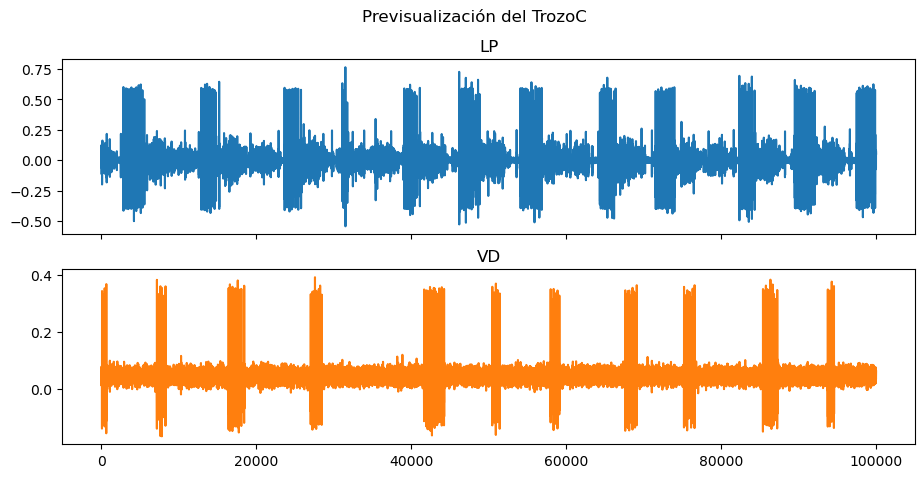

In [4]:
cant = 100000
partC = trozoC[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Previsualización del TrozoC')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'])
ax2.plot(range(cant), partC['VD'], 'tab:orange')
ax2.set_title('VD');

## Selección del umbral

Para hallar el valor del umbral para el cuál detectar la aparición de un *spike* debemos tener en cuenta la distribución de nuestras series temporales y fijarnos en los valores extremos puesto que estos se dan los eventos que deseamos encontrar

In [5]:
trozoC.describe()

LP            VD
count  1.984770e+07  1.984770e+07
mean  -2.253853e-08  4.385849e-02
std    8.214042e-02  3.287948e-02
min   -7.101440e-01 -2.170715e+00
25%   -2.288800e-02  3.295900e-02
50%    3.050000e-04  4.364000e-02
75%    2.410900e-02  5.401600e-02
max    9.344480e-01  1.351624e+00

Podemos comprobar que los datos poseen una gran dispersión ya que el caso de la neurona LP su varianza es seis órdenenes de magnitud superior a su media y la diferencia del mínimo y el máximo con la media es de siete órdenes de magnitud. Por otro lado, VD posee una menor dispersión puesto que los tres primeros cuartiles contienen valores en el mismo orden de magnitud indicando que el grueso de la distribución se encuentra próximo a la media pero posee valores dos órdenes de magnitud superior a la media en los máximos y mínimos.

Pasamos a observar estas distribuciones mediante histogramas.

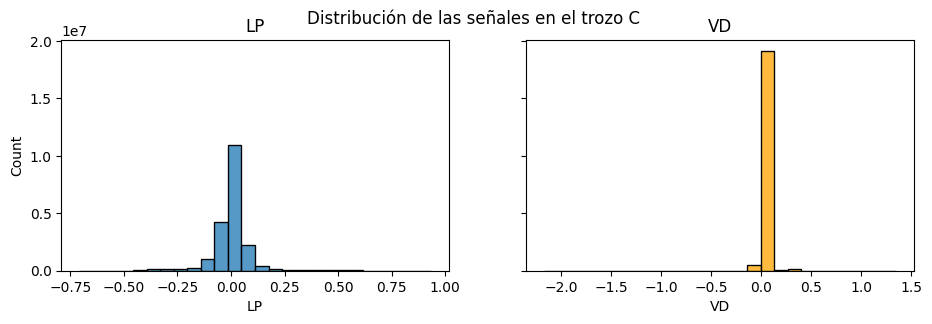

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (11,3))
fig.suptitle('Distribución de las señales en el trozo C')
ax1.set_title('LP')
ax2.set_title('VD')
sns.histplot(data = trozoC['LP'], ax = ax1, bins = int(np.floor(np.log(len(trozoC)))) + 10)
sns.histplot(data = trozoC['VD'], ax = ax2, bins = int(np.floor(np.log(len(trozoC)))) + 10, color = 'orange');

Como podemos ver, las distribuciones poseen la mayor parte del peso alrededor de la media y los *spikes* se concentran en las colas de las distribuciones. Para establecer el umbral nos quedaremos con el 1% de los datos que se encuentren la derecha de cada distribución.

In [38]:
q99C_lp = trozoC['LP'].quantile(.99)
q99C_vd = trozoC['VD'].quantile(.99)

Observamos el valor de las muestras dado junto a estos umbrales.

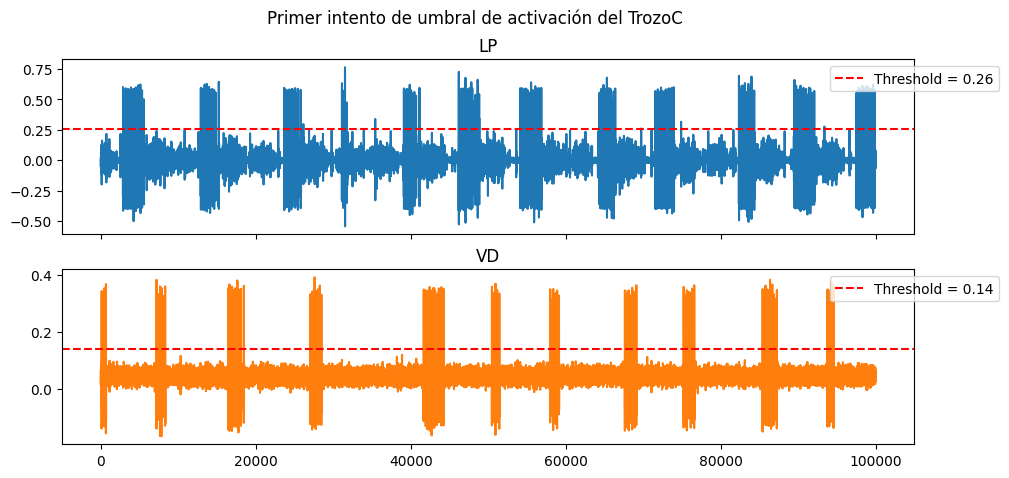

In [39]:
cant = 100000
partC = trozoC[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Primer intento de umbral de activación del TrozoC')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'])
ax1.axhline(y = q99C_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99C_lp,2)))
ax2.plot(range(cant), partC['VD'], 'tab:orange')
ax2.set_title('VD')
ax2.axhline(y = q99C_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99C_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center');

Como podemos observar, estos umbrales (en especial el de la neurona LP) no son lo suficientemente altos como para evitar categorizar algunas observaciones de ruido como *spikes*. Vamos a aumentarlos para evitar este efecto, quedándonos con el 0.7% de las muestras totales.

In [40]:
q99C_lp = trozoC['LP'].quantile(.994)
q99C_vd = trozoC['VD'].quantile(.993)

Y volvemos a observar las series para ver si hemos conseguido evitar el ruido.

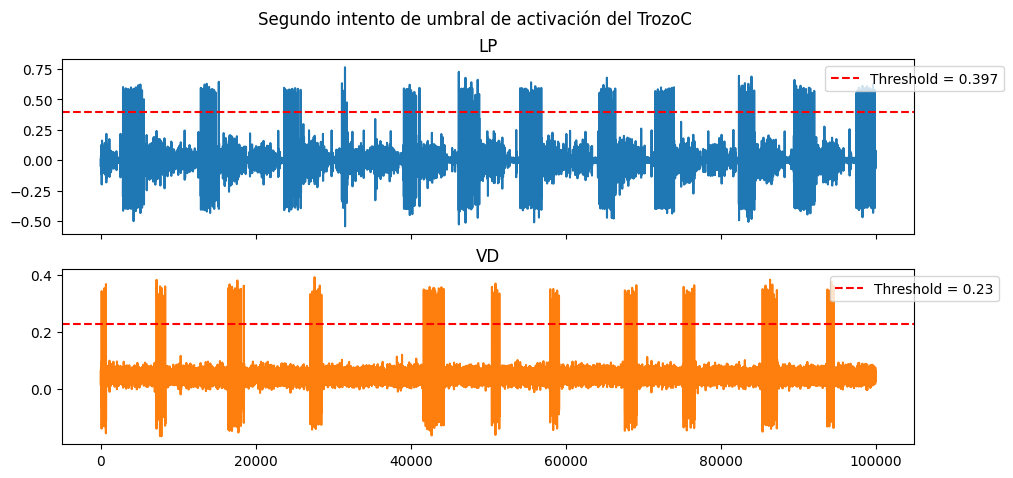

In [41]:
cant = 100000
partC = trozoC[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Segundo intento de umbral de activación del TrozoC')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'])
ax1.axhline(y = q99C_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99C_lp,3)))
ax2.plot(range(cant), partC['VD'], 'tab:orange')
ax2.set_title('VD')
ax2.axhline(y = q99C_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99C_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center');

Como podemos ver, ahora los umbrales se ajustan a los eventos que queremos estudiar. Creamos una función para encontrar estos umbrales en el resto de señales.

In [35]:
def find_threshold(series):
    q_lp = series['LP'].quantile(.994)
    q_vd = series['VD'].quantile(.993)
    return q_lp, q_vd

## Transformación de la señal
A continuación procedemos a crear una función que transforma las señales en señales binarias para poder realizar el tratamiento de la información.

In [33]:
def series_to_bin(series, thresh):
    return series.apply(lambda x : 0 if x < thresh else 1)

Aplicamos la transformación y comparamos con la original.

In [42]:
trozoC_transf = trozoC.copy()
trozoC_transf['LP'] = series_to_bin(trozoC_transf['LP'], q99C_lp)
trozoC_transf['VD'] = series_to_bin(trozoC_transf['VD'], q99C_vd)

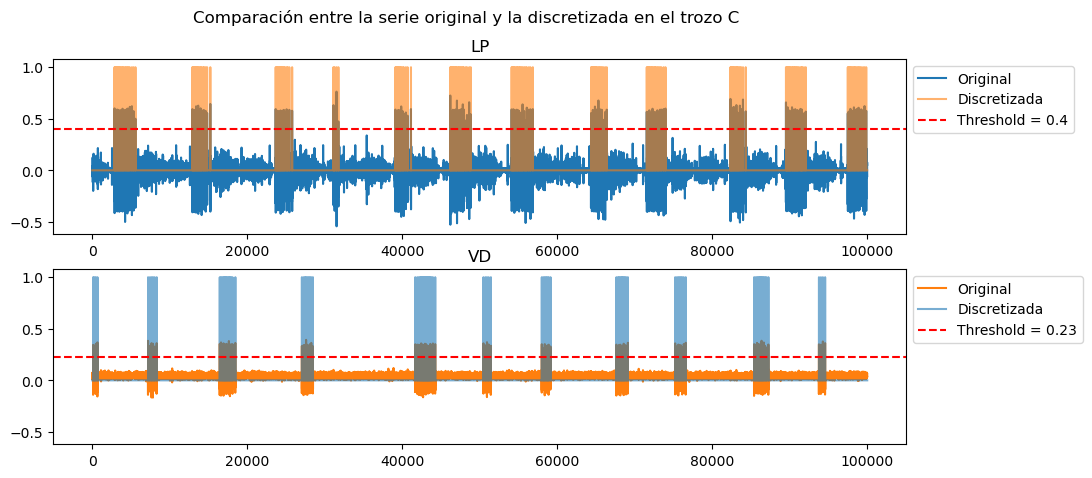

In [14]:
cant = 100000
partC = trozoC[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
fig.suptitle('Comparación entre la serie original y la discretizada en el trozo C')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'], label = 'Original')
ax1.plot(range(cant), trozoC_transf['LP'][0:cant], alpha = 0.6, label = 'Discretizada')
ax1.axhline(y = q99C_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99C_lp,2)))
ax2.set_title('VD')
ax2.plot(range(cant), partC['VD'],'tab:orange',label = 'Original')
ax2.plot(range(cant), trozoC_transf['VD'][0:cant], alpha = 0.6, label = 'Discretizada')
ax2.axhline(y = q99C_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99C_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

## Etiquetado de los spikes

Pasamos ahora a combinar los grupos de *spikes*, es decir, los grupos de unos en nuestras series transformadas de manera que solamente guardemos un único uno en el centro de la cadena.

In [15]:
index_lp = find_peaks(trozoC_transf['LP'])[0]
index_vd = find_peaks(trozoC_transf['VD'])[0]
trozoC_def = trozoC_transf.copy()
trozoC_def['LP'] = 0
trozoC_def['VD'] = 0
trozoC_def.loc[index_lp,['LP']] = 1
trozoC_def.loc[index_vd,['VD']] = 1

Comprobamos ahora que se hallan etiquetado correctamento los picos.

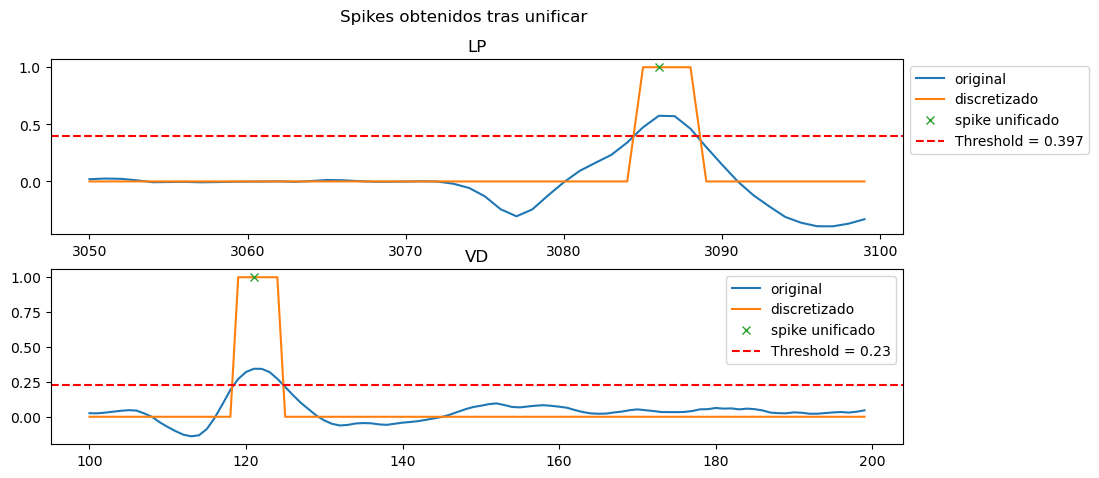

In [16]:
cant = 10000
partC = trozoC_transf[3050:3100]
index_lp_low = index_lp[(index_lp > 3050) & (index_lp<3100)]
index_vd_low = index_vd[(index_vd > 100) & (index_vd<200)]
fig, (ax1, ax2) = plt.subplots(2, sharex = False, figsize = (11,5))
fig.suptitle('Spikes obtenidos tras unificar')
ax1.set_title('LP')
ax1.plot(range(3050,3100), trozoC['LP'][3050:3100], label = 'original')
ax1.plot(range(3050,3100), partC['LP'], label = 'discretizado')
ax1.plot(index_lp_low, trozoC_def.loc[index_lp_low,['LP']], 'x', label = 'spike unificado')
ax1.axhline(y = q99C_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99C_lp,3)))
ax2.plot(range(100,200), trozoC['VD'][100:200], label = 'original')
ax2.plot(range(100,200), trozoC_transf['VD'][100:200], label = 'discretizado')
ax2.plot(index_vd_low, trozoC_def.loc[index_vd_low,['VD']], 'x', label = 'spike unificado')
ax2.set_title('VD')
ax2.axhline(y = q99C_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99C_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

## Selección de la ventana

Para seleccionar el tamaño de ventana vamos a seguir el criterio de que menos del 5% de los *spikes* aparezcan en la misma sección. Para ello vamos a calcular la distancia mínima entre *spikes* en nuestras series y tener en cuenta que debemos mantener el mismo tamaño para las dos muestras. Para ello calculamos los indices de cada *spike* en cada neurona y creamos un vector con las distancias entre estos.

In [17]:
def finddist_spike(indexes):
    dist = np.asarray(indexes[0:len(indexes)-1])
    for i in range(len(indexes) - 1):
        dist[i] = indexes[i+1] - indexes[i]
    return dist

In [18]:
dist_lp = finddist_spike(trozoC_def[trozoC_def['LP'] == 1].index)
dist_vd = finddist_spike(trozoC_def[trozoC_def['VD'] == 1].index)
q05_lp = np.quantile(dist_lp, 0.05)
q05_vd = np.quantile(dist_vd, 0.05)
print('El tamaño de ventana mínimo para tener el 5% de spikes en LP en la misma bin es: ' + str(q05_lp))
print('El tamaño de ventana mínimo para tener el 5% de spikes en VD en la misma bin es: ' + str(q05_vd))
print('El tamaño de ventana que tomaremos será ' + str(min(q05_lp, q05_vd)))

El tamaño de ventana mínimo para tener el 5% de spikes en LP en la misma bin es: 108.0
El tamaño de ventana mínimo para tener el 5% de spikes en VD en la misma bin es: 87.0
El tamaño de ventana que tomaremos será 87.0


Consecuentemente, vamos a observar la división de nuestras series temporales que genera este valor.

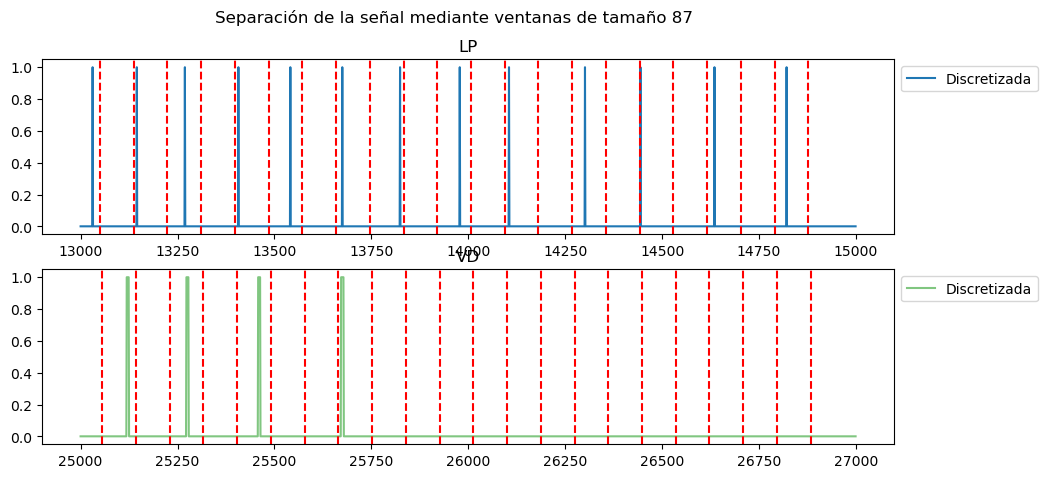

In [19]:
ini = 13000
fin = 15000
cant = fin - ini
ventana = 87
partC = trozoC_def[ini:fin]
fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
fig.suptitle('Separación de la señal mediante ventanas de tamaño 87')
ax1.set_title('LP')
ax1.plot(range(ini, fin), partC['LP'], label = 'Discretizada')
for i in range(ini + (-ini % ventana),fin - (fin%ventana),ventana):
    ax1.axvline(x = i, color = 'red', linestyle = '--')
    

ax2.set_title('VD')
ini = 25000
fin = 27000
cant = fin - ini
partC = trozoC_def[ini:fin]
ax2.plot(range(ini, fin), trozoC_transf['VD'][0:cant], 'tab:green' , alpha = 0.6, label = 'Discretizada')
for i in range(ini + (-ini % ventana),fin - (fin%ventana),ventana):
    ax2.axvline(x = i, color = 'red', linestyle = '--')
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

Una vez discretizadas las señales y fijado el tamaño de la ventana, vamos a crear una nueva lista para cada neurona, donde se colocará un 1 si aparece un spike en la ventana y un 0 si no aparece.

In [10]:
def agrup_ventana (dataframe, ventana):
    return dataframe.groupby(dataframe.index // ventana).max().copy()

Procedemos a describir la función que genera cada serie para cada tamaño de ventana.

In [43]:
lista_ventanas = [agrup_ventana(trozoC_transf, i) for i in range(1,88)]

## Cálculo de las medidas de información



Antes de empezar a calcular las medidas de información necesitamos tener las probabilidades tanto separadas como en conjunto de las neuronas LP y VD, además, el cálculo de estas probabilidades va a estar en función de la longitud de las palabras.

In [65]:
def prob(DataFrame, bits):
    """Introducir el DataFrame con las frecuencias discretizadas y los bits que tendrá cada palabra. 
    Retorna una lista formada por [prob(LP), prob(VD), prob(LP,VD)]"""
    palabras=int(len(DataFrame['LP'])/bits)
    df=DataFrame.iloc[:palabras*bits].copy()
    df['LP']=df['LP'].astype(str)
    df['VD']=df['VD'].astype(str)
    df2=df.groupby(df.index // bits).VD.sum().copy()
    df3=df.groupby(df.index // bits).LP.sum().copy()
    df4=df3 + ',' + df2
    return [df3.value_counts().sort_index()/len(df3), df2.value_counts().sort_index()/len(df2), df4.value_counts().sort_index()/len(df4) ]

### Cálculo de la entropía y la información mutua

Recordemos que la entropía de una variable aleatoria $X$ podía calcularse mediante la fórmula: 
\begin{equation}
H(X)=-\sum_x p(x)\log_2(p(x))
\end{equation}
En caso de calcular la entropía conjunta de dos variables $X,Y$ usaremos la fórmula:
\begin{equation}
H(X,Y)=-\sum_{x,y} p(x,y)\log_2(p(x,y))
\end{equation}

Destacar además que el cálculo de la entropía lo vamos a hacer en función de la longitud de las palabras.

In [7]:
def entropia(DataFrame, listaBits):
    """Calcula las entropías de las neuronas LP y VD separando las señanes el palabras de distinto tamaño.
       Retorna una lista del tipo [[S_LP_1bit, S_VD_1bit, S_LP_VD_1bit], [S_LP_2bits, S_VD_2bits, S_LP_VD_2bits],... ]"""
    H = [ [-np.sum(prob * np.log2(prob)) for prob in prob(DataFrame, bit)]  for bit in listaBits]
    return np.asarray(H) 

In [6]:
#Solo hemos calculado las entropias una vez
#lista_entropy = [entropia(frame, range(1,9)) for frame in lista_ventanas]
#with open('lista_entropias', 'wb') as f:
    #pickle.dump(lista_entropy, f)
with open('lista_entropias', 'rb') as f:
    lista_entropy = pickle.load(f)

Como ya tenemos las entropias, para calcular la información mutua (MI) vamos a usar la fórmula 
\begin{equation}
    MI(X,Y)= H(X)+H(Y)-H(X,Y)
\end{equation}
Igual que en el caso anterior, esta información mutua va a estar en función de la longitud de las palabras elegida.

In [8]:
def MI(ventana, listaBits, lista_entropy=lista_entropy):
    """Calcula la información mutua entre las neuronas LP y VD en funcion de la longitud de palabra elegida.
       Retorna una lista del tipo [MI_1bit, MI_2bits,...]"""
    lista_S=[lista_entropy[ventana][i-1] for i in listaBits]
    MI=[S[0]+S[1]-S[2] for S in lista_S]
    return MI
        

Finalmente vamos a calcular la entropía normalizada, recordemos que para calcularla usábamos la fórmula:
\begin{equation}
H_{X \rightarrow Y}=\frac{H(X,Y)}{H(X)}
\end{equation}

In [16]:
def S_norm(ventana, listaBits, lista_entropy=lista_entropy):
    """Calcula la entropía normalizada entre las neuronas LP y VD.
    Retorna una lista de la forma [[LP_to_VD_1bit, VD_to_LP_1bit],[LP_to_VD_2bits, VD_to_LP_2bits],...]"""
    S_norm=[]
    IM=MI(ventana,listaBits,lista_entropy)
    S=[lista_entropy[ventana][i-1] for i in listaBits]
    for i in range(0,len(IM)):
        S_norm.append([IM[i]/S[i][0],IM[i]/S[i][1]])
    return np.asarray(S_norm)

## Visualización de los resultados

In [17]:
def imprimir_todo(ventana, dataframe):

    fig, ax = plt.subplots(2,2, sharex = True, figsize = (11,5))
    fig.suptitle(f'Información mutua y entropias en función del número de bits, con tamaño de ventana {ventana}')

    ax[0,0].set_title('Información mutua')
    ax[0,0].plot(range(1,9), MI(dataframe,range(1,9)))

    ax[1,0].set_title('Entropías')
    ax[1,0].plot(range(1,9), entropia(dataframe,range(1,9))[:,0], label="S(LP)",  linestyle = '--')
    ax[1,0].set_title('Entropía VD')
    ax[1,0].plot(range(1,9), entropia(dataframe,range(1,9))[:,1], label="S(VD)", linestyle = 'dotted')
    ax[1,0].set_title('Entropía conjunta')
    ax[1,0].plot(range(1,9), entropia(dataframe,range(1,9))[:,2], label="S(LP,VD)")
    ax[1, 0].legend()

    ax[0,1].set_title('Entropía normalizada de LP a VD')
    ax[0,1].plot(range(1,9), S_norm(dataframe,range(1,9))[:,0], 'orange')

    ax[1,1].set_title('Entropía normalizada de VD a LP')
    ax[1,1].plot(range(1,9), S_norm(dataframe,range(1,9))[:,1], 'red')

In [18]:
def display_MI(lista):
    fig, ax = plt.subplots(2,4, sharex = False, sharey=True, figsize = (11,5), constrained_layout=True)
    fig.suptitle('Información mutua por número de bits en función del tamaño de ventana')
    
    for j in range(0,8):
        ax[j//4,j%4].set_title(f'Longitud = {j+1}')
        list_MI=np.array([MI(i,[j+1]) for i in range(1,len(lista))])
        ax[j//4,j%4].plot(range(1,len(lista)), list_MI/(j+1))


In [9]:
def display_MI_togh(lista, lista_entropy=lista_entropy):
    for j in range(0,8):
        list_MI=np.array([MI(i,[j+1],lista_entropy) for i in range(1,len(lista))])
        plt.plot(range(1,len(lista)), list_MI/(j+1), label=f'{j+1}')
    plt.xlabel('Tamaño de ventana')
    plt.ylabel('Información mutua')
    plt.title('Información mutua por número de bits en función del tamaño de ventana')
    plt.legend(title='Número de bits', loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True)

In [20]:
def display_Snorm_togh(lista, lista_entropy=lista_entropy):
    fig, ax = plt.subplots(ncols=2, sharex = True, sharey=True, figsize = (20,5))
    fig.suptitle(f'Transferencia de entropía por número de bits según la ventana')
    ax[0].set_title('Transferencia de LP a VD')
    ax[1].set_title('Transferencia de VD a LP')

    for i in range(8):
        list_Snorm=[S_norm(j, [i+1],lista_entropy) for j in range(1,len(lista))]
        list_Snorm=np.array(list_Snorm)
        ax[0].plot(range(1,len(lista)), list_Snorm[:,0,0]/(i+1), label=f'{i+1}')
        ax[1].plot(range(1,len(lista)), list_Snorm[:,0,1]/(i+1), label=f'{i+1}')
    ax[0].set(xlabel='Tamaño de ventana', ylabel='Transferencia de entropía')
    ax[1].set(xlabel='Tamaño de ventana')

    plt.legend(title='Número de bits', loc='lower center', bbox_to_anchor=(-0.1, -0.3), ncol=4, fancybox=True)

    

In [21]:
def display_Entropy_togh(lista, lista_entropy=lista_entropy):
    fig, ax = plt.subplots(ncols=3, sharex = True, sharey=True, figsize = (20,5))
    fig.suptitle(f'Entropía por número de bits según la ventana')
    ax[0].set_title('Entropía de LP')
    ax[1].set_title('Entropía de VD')
    ax[2].set_title('Entropía conjunta')

    for i in range(8):
        new_lista_entropy=np.array(lista_entropy)
        ax[0].plot(range(1,len(lista)+1), new_lista_entropy[:,i,0]/(i+1), label=f'{i+1}')
        ax[1].plot(range(1,len(lista)+1), new_lista_entropy[:,i,1]/(i+1), label=f'{i+1}')
        ax[2].plot(range(1,len(lista)+1), new_lista_entropy[:,i,2]/(i+1), label=f'{i+1}')
    ax[0].set(xlabel='Tamaño de ventana', ylabel='Entropía')
    ax[1].set(xlabel='Tamaño de ventana')

    plt.legend(title='Número de bits', loc='lower center', bbox_to_anchor=(-0.7, -0.35), ncol=4, fancybox=True)

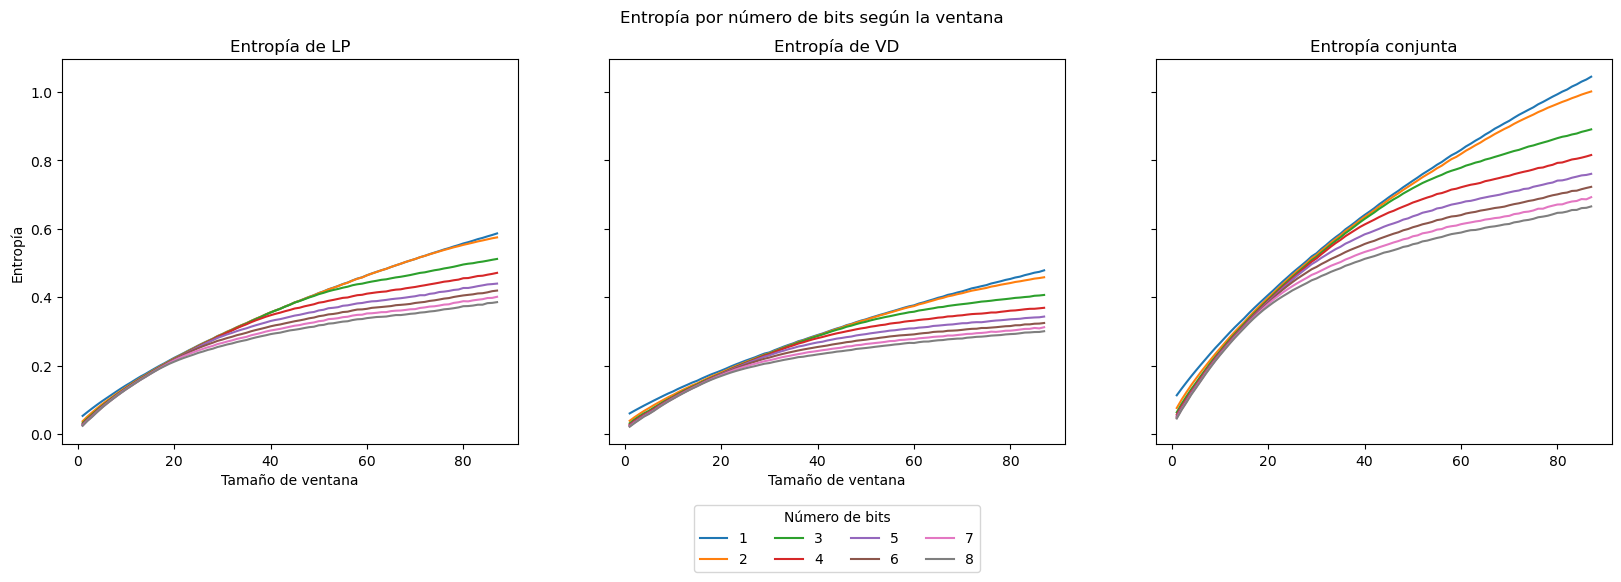

In [32]:
display_Entropy_togh(lista_ventanas)

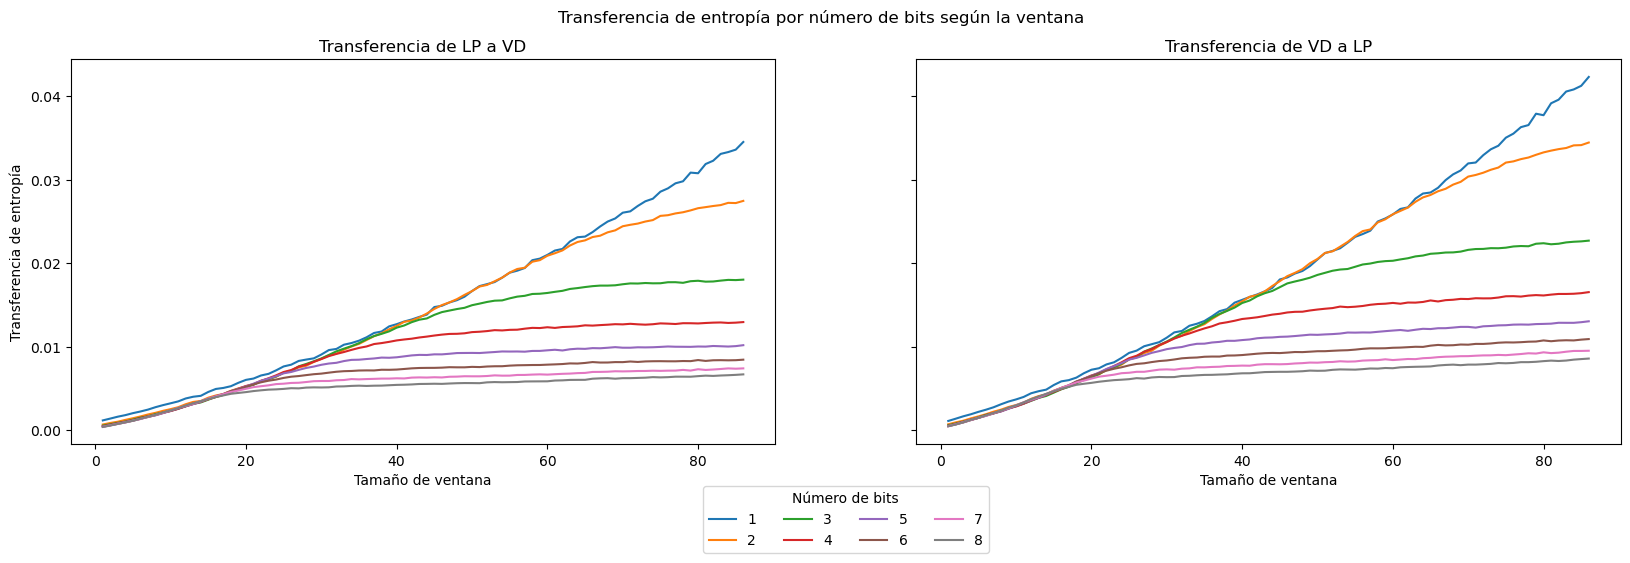

In [33]:
display_Snorm_togh(lista_ventanas)

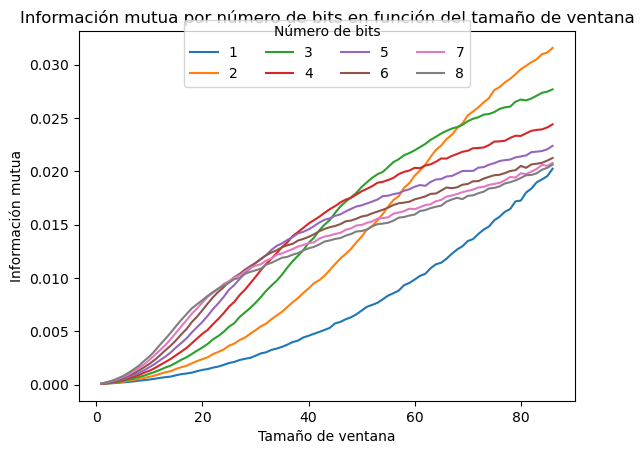

In [34]:
display_MI_togh(lista_ventanas)

### Añadir explicaciones

## Codificación SAX

### Escalando series temporales

In [29]:
PAA_trozoC = trozoC.copy()
PAA_trozoC['LP'] = (PAA_trozoC['LP'] - PAA_trozoC['LP'].mean())/PAA_trozoC['LP'].std()
PAA_trozoC['VD'] = (PAA_trozoC['VD'] - PAA_trozoC['VD'].mean())/PAA_trozoC['VD'].std()

def PAA_window(dataframe, window):
    return dataframe.groupby(dataframe.index // window).mean()

def sax(dataframe, n=3):
    aux=dataframe.copy()
    anterior = float('-inf')
    valact = 'a'
    for i in range(1, n+1):
        q=norm.ppf(i/n)
        aux.loc[(dataframe['LP'] <= q) & (anterior < dataframe['LP']), 'LP'] = valact
        aux.loc[(dataframe['VD']<=q) & (anterior < dataframe['VD']), 'VD']  = valact

        anterior = q
        valact=chr(ord(valact) + 1)
    return aux

In [36]:
#list_PAA = [sax(PAA_window(PAA_trozoC, i)) for i in range(1,88)

In [2]:
#with open('list_PAA', 'wb') as f:
#   pickle.dump(list_PAA, f)
with open('list_PAA', 'rb') as f:
    list_PAA = pickle.load(f)

In [38]:
#lista_entropia_SAX= [entropia(frame,range(1,9)) for frame in list_PAA] 

In [3]:
#with open('lista_entropia_SAX', 'wb') as f:
#    pickle.dump(lista_entropia_SAX, f)
with open('lista_entropia_SAX', 'rb') as f:
    lista_entropia_SAX = pickle.load(f)

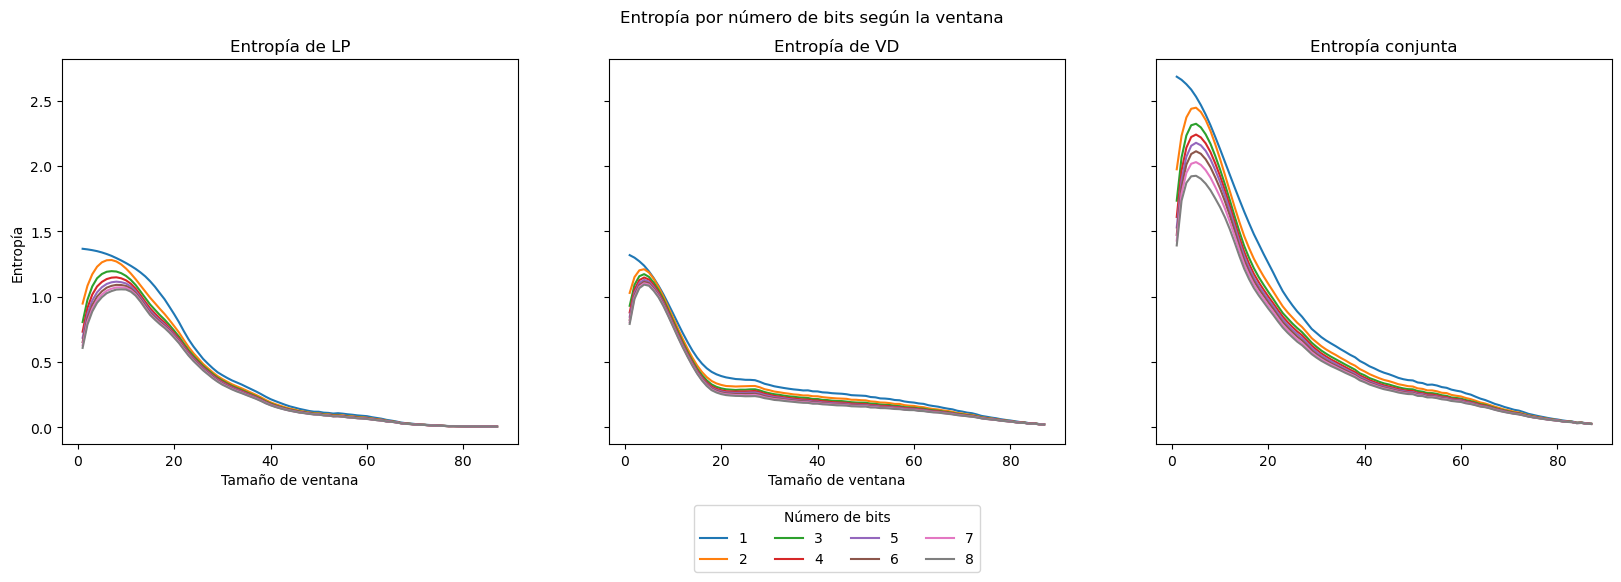

In [40]:
display_Entropy_togh(list_PAA, lista_entropia_SAX) 

In [28]:
def prob_conj(dataframe1, dataframe2, bit):
    palabras1=int(len(dataframe1['LP'])/bit)
    palabras2=int(len(dataframe2['LP'])/bit)
    df1=dataframe1.iloc[:palabras1*bit].copy()
    df2=dataframe2.iloc[:palabras2*bit].copy()
    df1['LP'] = df1['LP'].astype(str)
    df1['VD'] = df1['VD'].astype(str)
    binaryLP = df1.groupby(df1.index //bit).LP.sum().copy()
    binaryVD = df1.groupby(df1.index //bit).VD.sum().copy()
    saxLP = df2.groupby(df2.index // bit).LP.sum().copy()
    saxVD = df2.groupby(df2.index // bit).VD.sum().copy()
    df3 = binaryLP + saxLP
    df4 = binaryVD + saxVD
    return [df3.value_counts().sort_index()/len(df3), df4.value_counts().sort_index()/len(df4)]

In [29]:
def entropia_conj(dataframe1, dataframe2,listaBits):
    H = [ [-np.sum(prob * np.log2(prob)) for prob in prob_conj(dataframe1, dataframe2, bit)]  for bit in listaBits]
    return np.asarray(H)


In [43]:
#entropy_thog = [entropia_conj(lista_ventanas[i],list_PAA[i],range(1,9)) for i in range(0,87) ]

In [44]:
#with open('entropy_thog', 'wb') as f:
#    pickle.dump(entropy_thog, f)
with open('entropy_thog', 'rb') as f:
    entropy_thog = pickle.load(f)

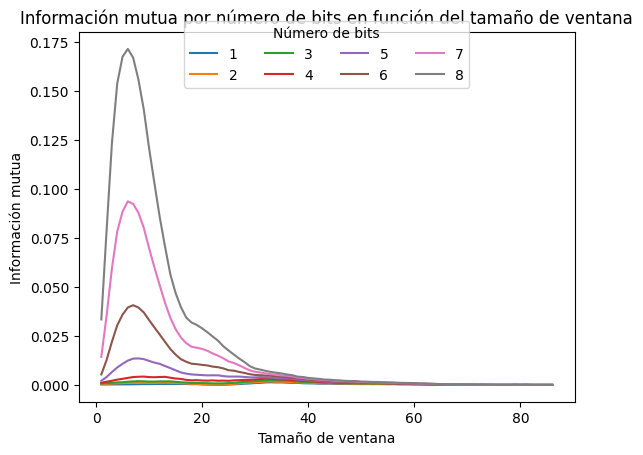

In [10]:
display_MI_togh(list_PAA, lista_entropia_SAX)

In [47]:
def display_heatmap(lista_entropy, lista_entropia_SAX, entropy_thog):
    LP=[]
    VD=[]
    for ventana in range(0,len(lista_entropy)):
        lista_S=[lista_entropy[ventana][i-1] for i in range(1,9)]
        lista_S_sax=[lista_entropia_SAX[ventana][i-1] for i in range(1,9)]
        lista_S_thog=[entropy_thog[ventana][i-1] for i in range(1,9)]
        LP.append([lista_S[i][0]+lista_S_sax[i][0]-lista_S_thog[i][0] for i in range(0,8)])
        VD.append([lista_S[i][1]+lista_S_sax[i][1]-lista_S_thog[i][1] for i in range(0,8)])
    LP=np.array(LP)
    VD=np.array(VD)
    fig, ax = plt.subplots(ncols=2, sharex = True, sharey=True, figsize = (20,5))
    fig.suptitle(f'Información mutua por bit en función del tamaño de ventana')
    ax[0].set_title('Información mutua LP')
    ax[1].set_title('Información mutua VD')
    for i in range(8):
        ax[0].plot(range(1,len(lista_entropy)+1), LP[:,i]/(i+1), label=f'{i+1}')
        ax[1].plot(range(1,len(lista_entropy)+1), VD[:,i]/(i+1), label=f'{i+1}')
        print(f'La información mútua máxima para LP con {i+1} bits es {max(LP[:,i])/(i+1)} y se alcanza en la ventana {np.argmax(LP[:,i]/(i+1)) + 1}')
    for i in range(8):
        print(f'La información mútua máxima para VD con {i+1} bits es {max(VD[:,i])/(i+1)} y se alcanza en la ventana {np.argmax(VD[:,i]/(i+1)) + 1}')

    ax[0].set(xlabel='Tamaño de ventana', ylabel='Información Mutua')
    ax[1].set(xlabel='Tamaño de ventana')
    plt.legend(title='Número de bits', loc='lower center', bbox_to_anchor=(-0.1, -0.35), ncol=4, fancybox=True)
    plt.xlabel('Tamaño de ventana')
    plt.ylabel('Información mutua')

La información mútua máxima para LP con 1 bits es 0.05092328962103876 y se alcanza en la ventana 20
La información mútua máxima para LP con 2 bits es 0.08977963795477473 y se alcanza en la ventana 28
La información mútua máxima para LP con 3 bits es 0.10953718758776576 y se alcanza en la ventana 28
La información mútua máxima para LP con 4 bits es 0.11917766989437417 y se alcanza en la ventana 28
La información mútua máxima para LP con 5 bits es 0.12597657626651476 y se alcanza en la ventana 28
La información mútua máxima para LP con 6 bits es 0.12973099545238753 y se alcanza en la ventana 28
La información mútua máxima para LP con 7 bits es 0.13015920453194862 y se alcanza en la ventana 28
La información mútua máxima para LP con 8 bits es 0.13132309310587653 y se alcanza en la ventana 28
La información mútua máxima para VD con 1 bits es 0.14053992388174352 y se alcanza en la ventana 27
La información mútua máxima para VD con 2 bits es 0.15180185177659805 y se alcanza en la ventana 27


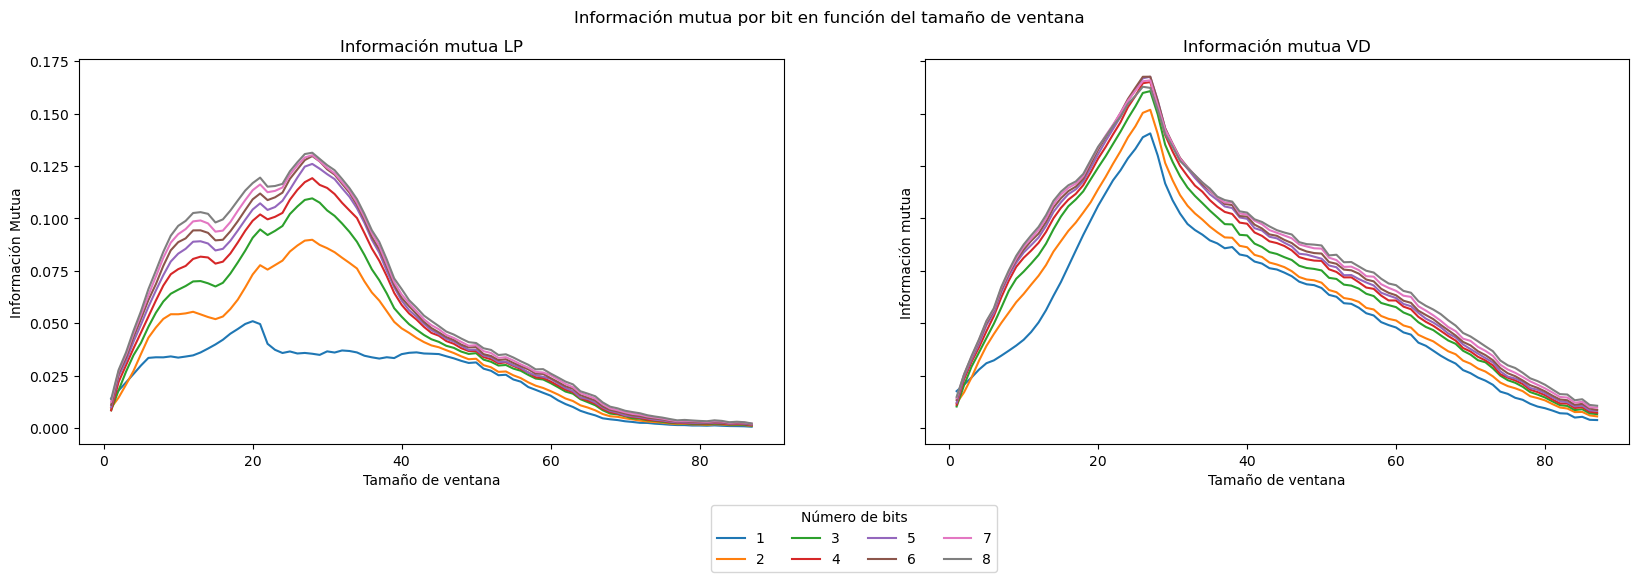

In [46]:
display_heatmap(lista_entropy, lista_entropia_SAX, entropy_thog)

Como en el caso de la señal LP hemos añadido un umbral para descartar pseudo spikes que no formaban parte de las señales que queríamos estudiar, procedemos a hacer un estudio de la señal LP para tratar de compensar este fenómeno que no hemos tenido en cuenta a la hora de realizar la transformación.

In [51]:
def superponer(listaSAX, lista1, rango, ventana):
    x = rango[0]
    y = rango[1]
    copia2 = lista1.copy()
    copia2['aux'] = copia2.index // ventana
    copia = listaSAX.copy()
    copia['aux'] = copia.index
    copia = copia.merge(copia2, how='left', left_on=['aux'], right_on=['aux'])
    copia['LP_new'] = -0.5
    copia['LP_new'].loc[copia['LP_x'] == 'b'] = 0
    copia['LP_new'].loc[copia['LP_x'] == 'c'] = 0.5
    plt.figure(figsize=(11,5));
    plt.plot(range(x,y), copia['LP_new'][x:y], label = 'SAX')
    plt.plot(range(x,y), lista1['LP'][x:y], label = 'Original')
    plt.legend(title='Tipo de series')
    plt.title('Comparación entre la serie original LP y su transformación SAX con tamaño de ventana: ' +str(ventana) )
superponer(list_PAA[15], trozoC, (3300,4000), 16);

Como podemos apreciar, lo que la codificación SAX está haciendo es codificar como a *c* al diferencial positivo, como *b* los valores cercanos al cero y como *a* al diferencial negativo. No obstante, vemos que con el tamaño de ventana anterior consideramos el ruido como spike. Comprobamos para la otra serie si la codificación resulta similar.

In [50]:
def superponerVD(listaSAX, lista1, rango, ventana):
    x = rango[0]
    y = rango[1]
    copia2 = lista1.copy()
    copia2['aux'] = copia2.index // ventana
    copia = listaSAX.copy()
    copia['aux'] = copia.index
    copia = copia.merge(copia2, how='left', left_on=['aux'], right_on=['aux'])
    copia['VD_new'] = -0.5
    copia['VD_new'].loc[copia['VD_x'] == 'b'] = 0
    copia['VD_new'].loc[copia['VD_x'] == 'c'] = 0.5
    plt.figure(figsize=(11,5));
    plt.plot(range(x,y), copia['VD_new'][x:y], label = 'SAX')
    plt.plot(range(x,y), lista1['VD'][x:y], label = 'Original')
    plt.legend(title='Tipo de series')
    plt.title('Comparación entre la serie original VD y su transformación SAX con tamaño de ventana: ' +str(ventana) )
superponerVD(list_PAA[20], trozoC, (7000,8000), 21);

Estábamos en lo correcto, la codificación SAX sigue el mismo patrón en las dos señales. En vista a estos resultados consideramos oportuno calcular la información mútua entre las dos codificaciones pero modificando las señales SAX para que los niveles de potencial negativo se asocien al potencial cero (lo cual se traduce a convertir las *a* en *b*).

In [11]:
list_SAX_bin = list_PAA.copy()
for i in range(len(list_SAX_bin)):
    list_SAX_bin[i]['LP'].loc[list_SAX_bin[i]['LP'] == 'a'] = 'b'
    list_SAX_bin[i]['VD'].loc[list_SAX_bin[i]['VD'] == 'a'] = 'b'

Calculamos de nuevo las entropías.

In [66]:
lista_entropia_SAX_bin = [entropia(frame,range(1,9)) for frame in list_SAX_bin] 

In [67]:
with open('lista_entropia_SAX_bin', 'wb') as f:
    pickle.dump(lista_entropia_SAX_bin, f)
with open('lista_entropia_SAX_bin', 'rb') as f:
    lista_entropia_SAX_bin = pickle.load(f)

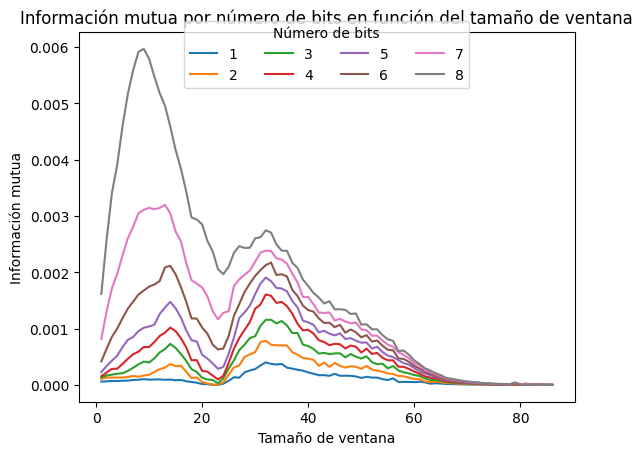

In [68]:
display_MI_togh(list_SAX_bin, lista_entropia_SAX_bin)

Y también calculamos de nuevo las entropías conjuntas:

In [52]:
#entropy_thog_bin = [entropia_conj(lista_ventanas[i],list_SAX_bin[i],range(1,9)) for i in range(0,87)]

In [20]:
#with open('entropy_thog_bin', 'wb') as f:
#    pickle.dump(entropy_thog_bin, f)
with open('entropy_thog_bin', 'rb') as f:
    entropy_thog_bin = pickle.load(f)

Observamos los valores de la información mútua de nuevo.

La información mútua máxima para LP con 1 bits es 0.04309604758853658 y se alcanza en la ventana 20
La información mútua máxima para LP con 2 bits es 0.06907857270753276 y se alcanza en la ventana 28
La información mútua máxima para LP con 3 bits es 0.08165099390579049 y se alcanza en la ventana 28
La información mútua máxima para LP con 4 bits es 0.0896935871397096 y se alcanza en la ventana 28
La información mútua máxima para LP con 5 bits es 0.0949118171212496 y se alcanza en la ventana 28
La información mútua máxima para LP con 6 bits es 0.09750529951819102 y se alcanza en la ventana 28
La información mútua máxima para LP con 7 bits es 0.0983265710293272 y se alcanza en la ventana 28
La información mútua máxima para LP con 8 bits es 0.09842110462115256 y se alcanza en la ventana 28
La información mútua máxima para VD con 1 bits es 0.12872917020280272 y se alcanza en la ventana 27
La información mútua máxima para VD con 2 bits es 0.1394755802551788 y se alcanza en la ventana 27
La i

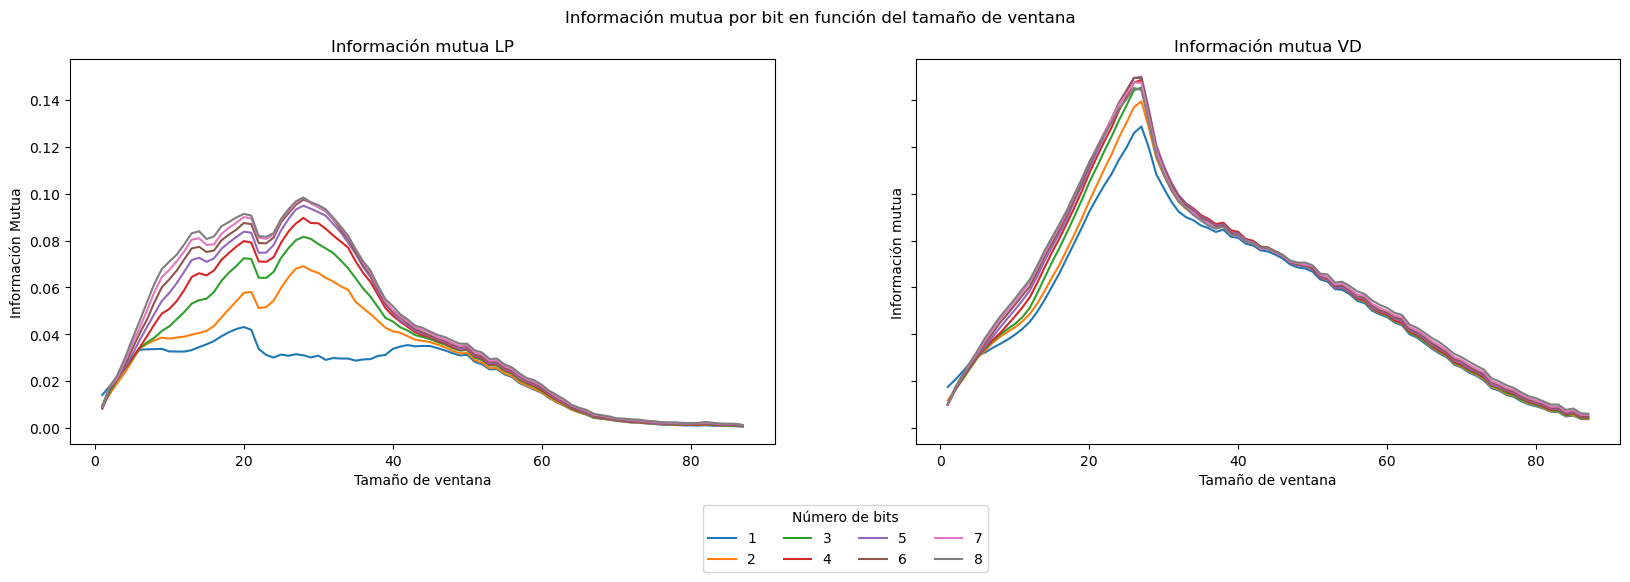

In [54]:
display_heatmap(lista_entropy, lista_entropia_SAX_bin, entropy_thog_bin)

No hay mucha diferencia entre los valores obtenidos y los anteriores. Para terminar, comparamos las dos series con mayor información mútua entre ellas. Nos quedamos con el tamaño de ventana 27.

In [55]:
best_sax = list_SAX_bin[26]
best_spikes = lista_ventanas[26]
best_sax['LP'].loc[best_sax['LP'] == 'b'] = 0
best_sax['LP'].loc[best_sax['LP'] == 'c'] = 1
best_sax['VD'].loc[best_sax['VD'] == 'b'] = 0
best_sax['VD'].loc[best_sax['VD'] == 'c'] = 1

In [67]:
def compare_series_LP(df1,df2, rango = (0,10000)):
    fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
    x = rango[0]
    y = rango[1]
    ax1.plot(range(x,y), df1['LP'][x:y], label = 'Discretización')
    ax1.set_title('Descretización original LP')
    
    ax2.plot(range(x,y), df2['LP'][x:y], label = 'SAX')
    ax2.set_title('SAX LP')
#compare_series_LP(best_spikes, best_sax)

Arrastramos el problema del ruido que en la anterior hemos eliminado con el threshold.

In [71]:
def superponerAllLP(listaSAX, lista1, listaBin , rango = (3300,4000), ventana = 27):
    x = rango[0]
    y = rango[1]
    copia2 = lista1.copy()
    copia2['aux'] = copia2.index // ventana
    copia = listaSAX.copy()
    copia['aux'] = copia.index
    copia3 = listaBin.copy()
    copia3['aux'] = copia3.index
    copia = copia.merge(copia2, how='left', left_on=['aux'], right_on=['aux'])
    copia = copia.merge(copia3, how='left', left_on=['aux'], right_on=['aux'])
    fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
    ax1.set_title('Comparación entre la serie original LP y las series transformadas')
    ax1.plot(range(x,y), copia['LP_x'][x:y], label = 'SAX')
    ax1.plot(range(x,y), copia['LP_y'][x:y], label = 'Original')
    ax2.plot(range(x,y), copia['LP'][x:y], label = 'Discretización')
    ax2.plot(range(x,y), copia['LP_y'][x:y], label = 'Original')
    ax1.legend(bbox_to_anchor = (1.0, 1))
    ax2.legend(bbox_to_anchor = (1.0, 1));
#superponerAllLP(best_sax, trozoC, best_spikes);

SAX va fatal

In [69]:
def compare_series_VD(df1,df2, rango = (0,10000)):
    fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
    x = rango[0]
    y = rango[1]
    ax1.plot(range(x,y), df1['VD'][x:y], label = 'Discretización')
    ax1.set_title('Descretización original VD')
    
    ax2.plot(range(x,y), df2['VD'][x:y], label = 'SAX')
    ax2.set_title('SAX VD')
#compare_series_VD(best_spikes, best_sax)

In [73]:
def superponerAllVD(listaSAX, lista1, listaBin , rango = (7000,8000), ventana = 27):
    x = rango[0]
    y = rango[1]
    copia2 = lista1.copy()
    copia2['aux'] = copia2.index // ventana
    copia = listaSAX.copy()
    copia['aux'] = copia.index
    copia3 = listaBin.copy()
    copia3['aux'] = copia3.index
    copia = copia.merge(copia2, how='left', left_on=['aux'], right_on=['aux'])
    copia = copia.merge(copia3, how='left', left_on=['aux'], right_on=['aux'])
    fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
    ax1.set_title('Comparación entre la serie original VD y las series transformadas')
    ax1.plot(range(x,y), copia['VD_x'][x:y], label = 'SAX')
    ax1.plot(range(x,y), copia['VD_y'][x:y], label = 'Original')
    ax2.plot(range(x,y), copia['VD'][x:y], label = 'Discretización')
    ax2.plot(range(x,y), copia['VD_y'][x:y], label = 'Original')
    ax1.legend(bbox_to_anchor = (1.0, 1))
    ax2.legend(bbox_to_anchor = (1.0, 1));
#superponerAllVD(best_sax, trozoC, best_spikes);

Prácticamente iguales puesto que no arrastramos ruido, pero SAX falla en algunas (no sé por qué)

## SAX con valor absoluto

Como SAX no etiqueta correctamente los spickes ya que hay valores negativos vamos a tomar valores absolutos para que de esta manera sí que etiquete correctamente los spikes

In [21]:
PAA_trozoC_abs = trozoC.abs().copy()
PAA_trozoC_abs['LP'] = (PAA_trozoC_abs['LP'] - PAA_trozoC_abs['LP'].mean())/PAA_trozoC_abs['LP'].std()
PAA_trozoC_abs['VD'] = (PAA_trozoC_abs['VD'] - PAA_trozoC_abs['VD'].mean())/PAA_trozoC_abs['VD'].std()


In [23]:
#list_PAA_abs = [sax(PAA_window(PAA_trozoC_abs, i)) for i in range(1,88)]

In [22]:
#with open('list_PAA_abs', 'wb') as f:
#   pickle.dump(list_PAA_abs, f)
with open('list_PAA_abs', 'rb') as f:
    list_PAA_abs = pickle.load(f)

In [25]:
#lista_entropia_SAX_abs= [entropia(frame,range(1,9)) for frame in list_PAA_abs] 

In [23]:
#with open('lista_entropia_SAX_abs', 'wb') as f:
#    pickle.dump(lista_entropia_SAX_abs, f)
with open('lista_entropia_SAX_abs', 'rb') as f:
    lista_entropia_SAX_abs = pickle.load(f)

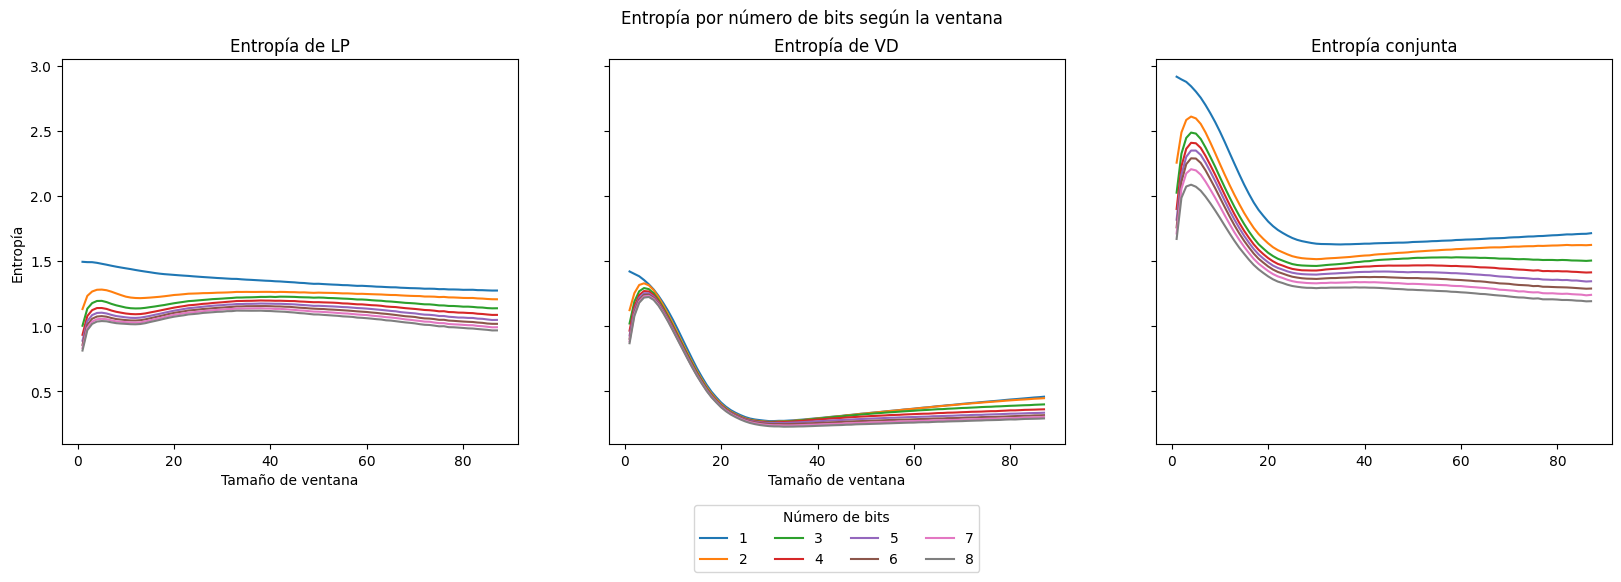

In [27]:
display_Entropy_togh(list_PAA_abs, lista_entropia_SAX_abs) 

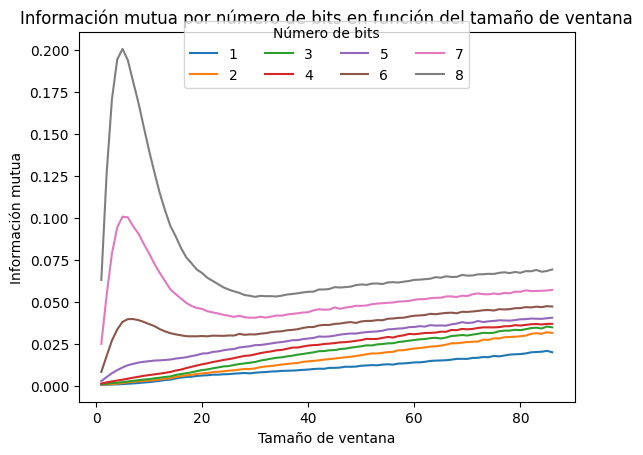

In [24]:
display_MI_togh(list_PAA_abs, lista_entropia_SAX_abs)

In [44]:
entropy_thog_abs = [entropia_conj(lista_ventanas[i],list_PAA_abs[i],range(1,9)) for i in range(0,87) ]

In [45]:
with open('entropy_thog_abs', 'wb') as f:
    pickle.dump(entropy_thog_abs, f)
#with open('entropy_thog_abs', 'rb') as f:
#    entropy_thog_abs = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.38693857312664104 y se alcanza en la ventana 87
La información mútua máxima para LP con 2 bits es 0.38961248443454943 y se alcanza en la ventana 87
La información mútua máxima para LP con 3 bits es 0.35572045374308675 y se alcanza en la ventana 87
La información mútua máxima para LP con 4 bits es 0.33451848289373576 y se alcanza en la ventana 87
La información mútua máxima para LP con 5 bits es 0.31976347289732165 y se alcanza en la ventana 87
La información mútua máxima para LP con 6 bits es 0.31342760516277285 y se alcanza en la ventana 87
La información mútua máxima para LP con 7 bits es 0.3105638213896679 y se alcanza en la ventana 87
La información mútua máxima para LP con 8 bits es 0.31108835707586624 y se alcanza en la ventana 87
La información mútua máxima para VD con 1 bits es 0.42523843921295823 y se alcanza en la ventana 87
La información mútua máxima para VD con 2 bits es 0.41797451133623587 y se alcanza en la ventana 87
L

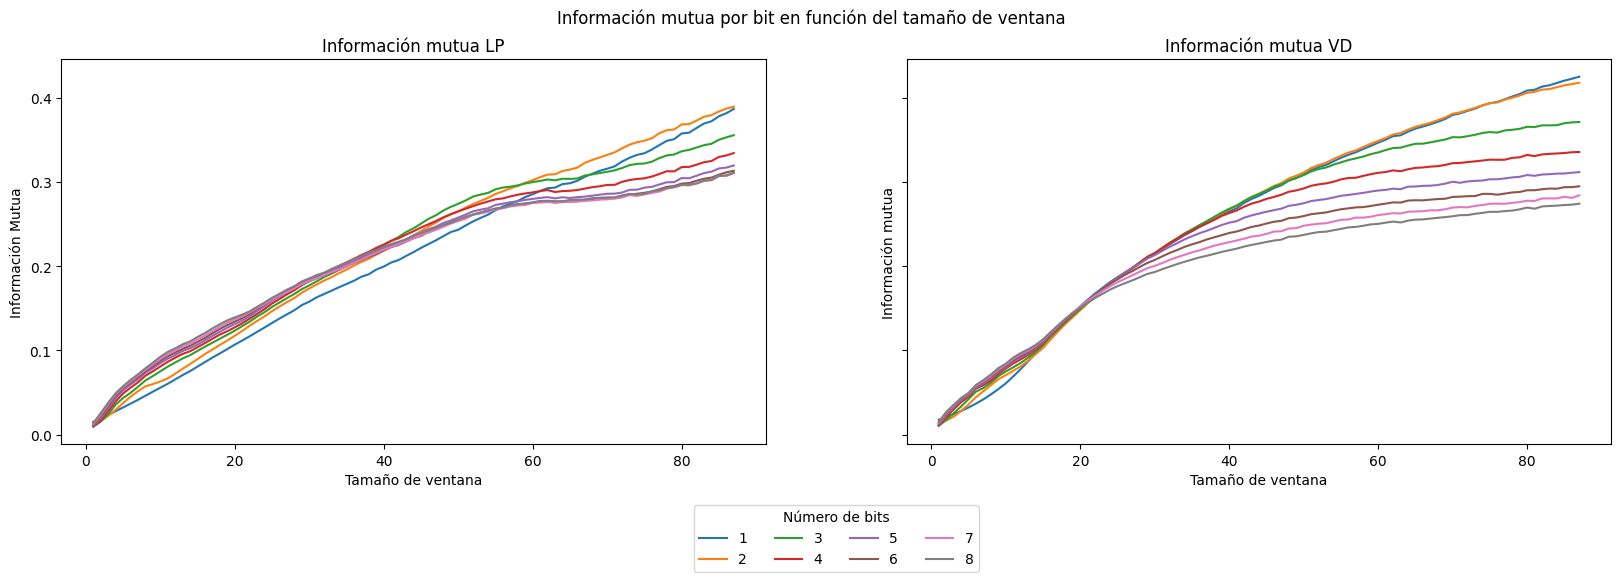

In [52]:
display_heatmap(lista_entropy, lista_entropia_SAX_abs, entropy_thog_abs)

C:\Users\Javier\AppData\Local\Temp\ipykernel_2668\3733316995.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copia['VD_new'].loc[copia['VD_x'] == 'b'] = 0
C:\Users\Javier\AppData\Local\Temp\ipykernel_2668\3733316995.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copia['VD_new'].loc[copia['VD_x'] == 'c'] = 0.5


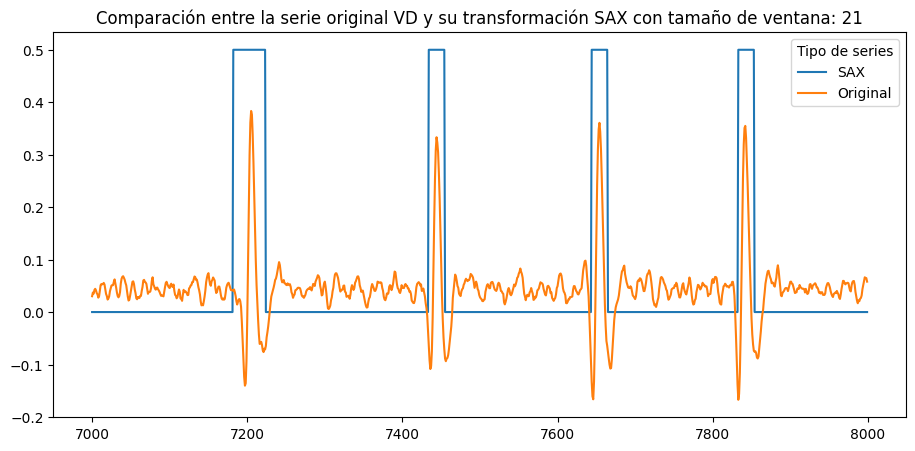

In [53]:
superponerVD(list_PAA_abs[20], trozoC, (7000,8000), 21);

C:\Users\Javier\AppData\Local\Temp\ipykernel_2668\2131111957.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copia['LP_new'].loc[copia['LP_x'] == 'b'] = 0
C:\Users\Javier\AppData\Local\Temp\ipykernel_2668\2131111957.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copia['LP_new'].loc[copia['LP_x'] == 'c'] = 0.5


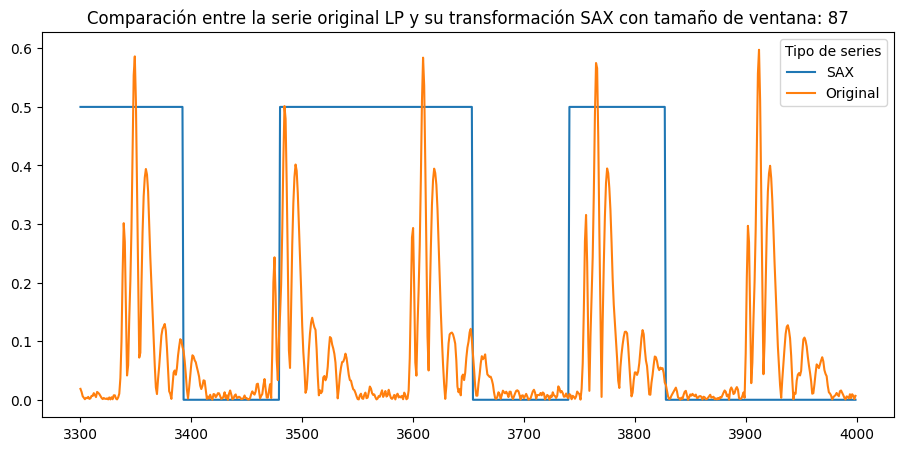

In [64]:
superponer(list_PAA_abs[86], trozoC.abs(), (3300,4000), 87);

Cambiamos las letras a por b

In [69]:
list_SAX_bin_abs = list_PAA_abs.copy()
for i in range(len(list_SAX_bin_abs)):
    list_SAX_bin_abs[i]['LP'].loc[list_SAX_bin_abs[i]['LP'] == 'a'] = 'b'
    list_SAX_bin_abs[i]['VD'].loc[list_SAX_bin_abs[i]['VD'] == 'a'] = 'b'

Recalculamos las entropias

In [59]:
#lista_entropia_SAX_bin_abs = [entropia(frame,range(1,9)) for frame in list_SAX_bin_abs] 

Calculamos las entropias conjuntas

In [70]:
#with open('lista_entropia_SAX_bin_abs', 'wb') as f:
#    pickle.dump(lista_entropia_SAX_bin_abs, f)
with open('lista_entropia_SAX_bin_abs', 'rb') as f:
    lista_entropia_SAX_bin_abs = pickle.load(f)

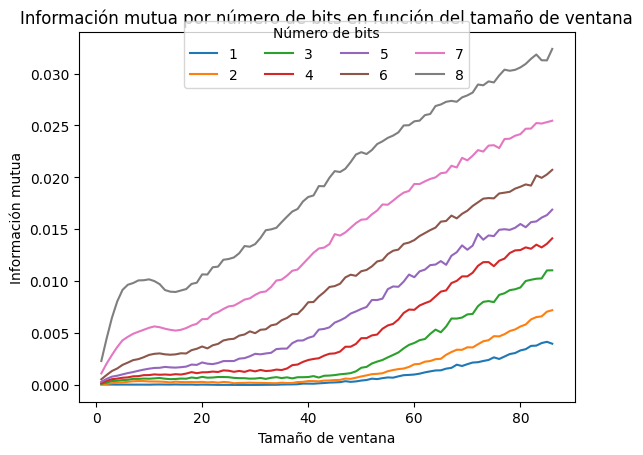

In [71]:
display_MI_togh(list_SAX_bin_abs, lista_entropia_SAX_bin_abs)

In [62]:
entropy_thog_bin_abs = [entropia_conj(lista_ventanas[i],list_SAX_bin_abs[i],range(1,9)) for i in range(0,87)]

In [63]:
with open('entropy_thog_bin_abs', 'wb') as f:
    pickle.dump(entropy_thog_bin_abs, f)
#with open('entropy_thog_bin_abs', 'rb') as f:
#    entropy_thog_bin_abs = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.3829642958501407 y se alcanza en la ventana 87
La información mútua máxima para LP con 2 bits es 0.3860471990345429 y se alcanza en la ventana 87
La información mútua máxima para LP con 3 bits es 0.350222033563627 y se alcanza en la ventana 87
La información mútua máxima para LP con 4 bits es 0.3261428073364956 y se alcanza en la ventana 87
La información mútua máxima para LP con 5 bits es 0.309176975030171 y se alcanza en la ventana 87
La información mútua máxima para LP con 6 bits es 0.29921048601068395 y se alcanza en la ventana 87
La información mútua máxima para LP con 7 bits es 0.29250839167403875 y se alcanza en la ventana 87
La información mútua máxima para LP con 8 bits es 0.28921679438737935 y se alcanza en la ventana 87
La información mútua máxima para VD con 1 bits es 0.42523843921295823 y se alcanza en la ventana 87
La información mútua máxima para VD con 2 bits es 0.41797451133623587 y se alcanza en la ventana 87
La info

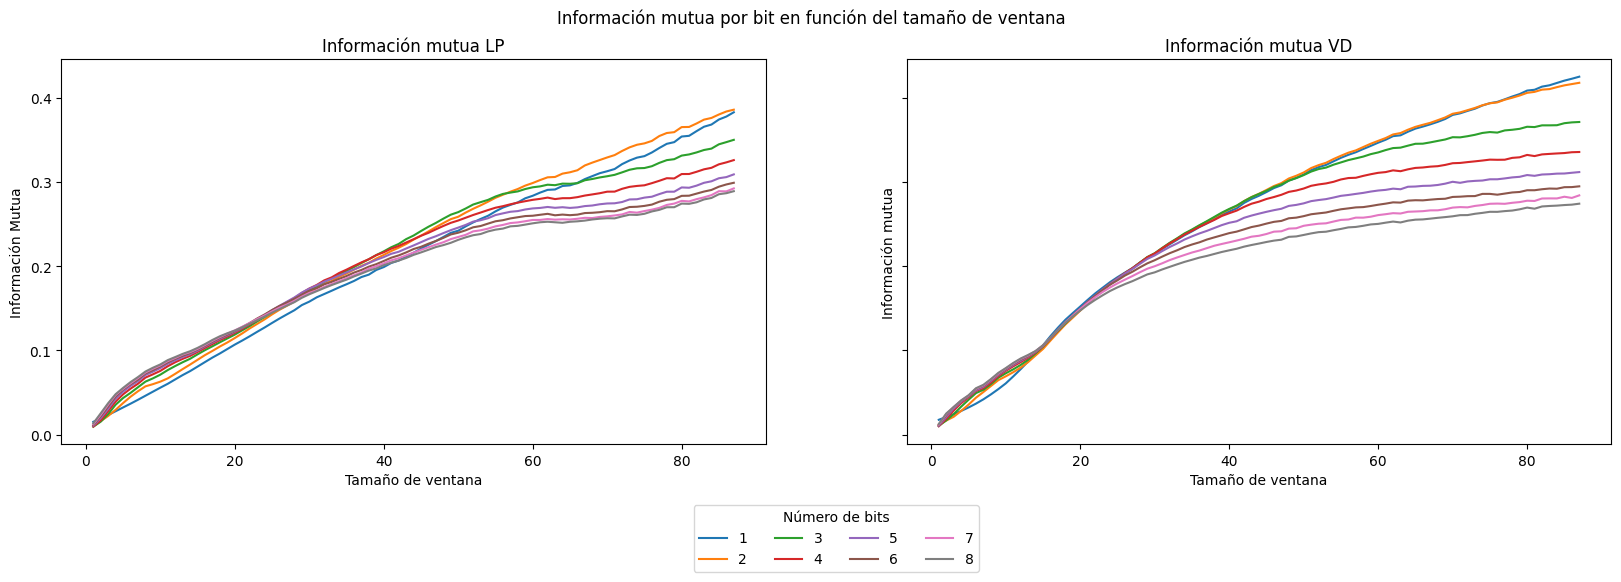

In [65]:
display_heatmap(lista_entropy, lista_entropia_SAX_bin_abs, entropy_thog_bin_abs)

In [66]:
best_sax_abs = list_SAX_bin_abs[86]
best_spikes_abs = lista_ventanas[86]
best_sax_abs['LP'].loc[best_sax_abs['LP'] == 'b'] = 0
best_sax_abs['LP'].loc[best_sax_abs['LP'] == 'c'] = 1
best_sax_abs['VD'].loc[best_sax_abs['VD'] == 'b'] = 0
best_sax_abs['VD'].loc[best_sax_abs['VD'] == 'c'] = 1

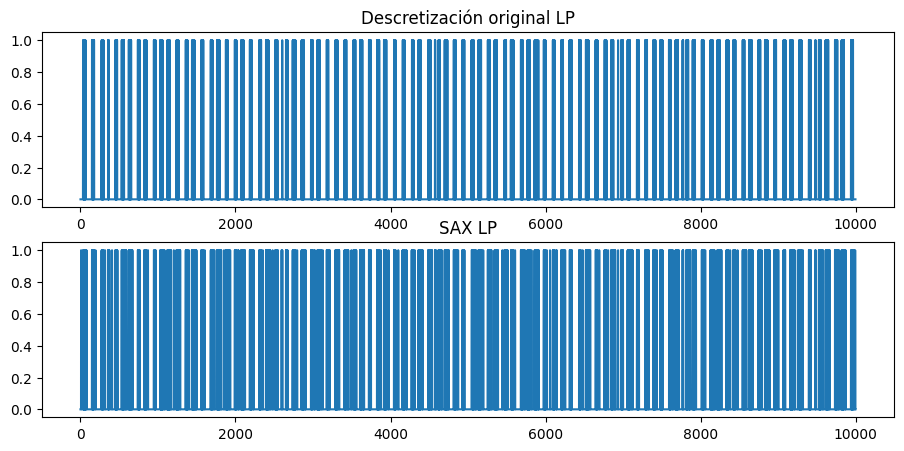

In [68]:
compare_series_LP(best_spikes_abs, best_sax_abs)

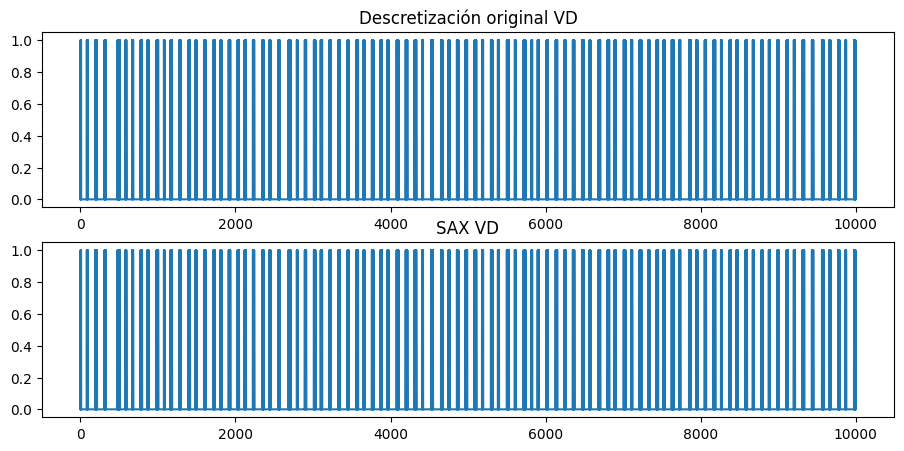

In [70]:
compare_series_VD(best_spikes_abs, best_sax_abs)

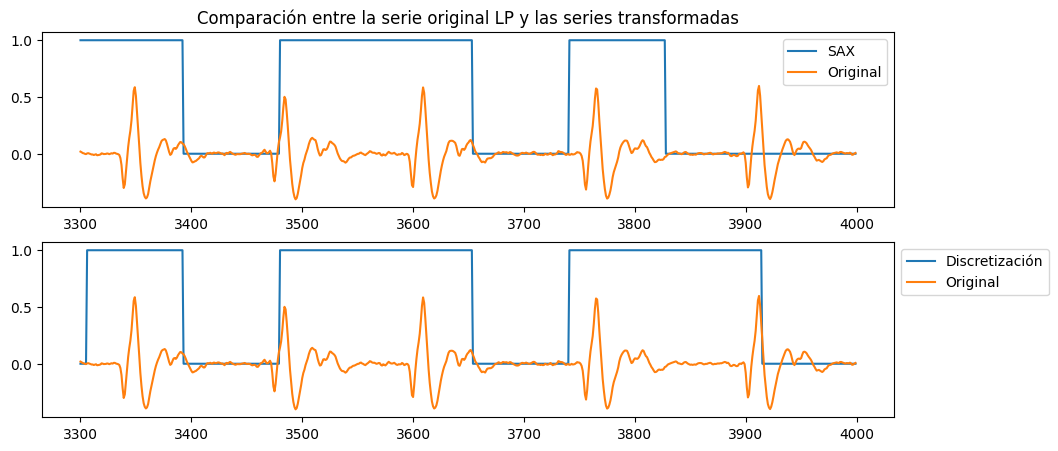

In [76]:
superponerAllLP(best_sax_abs, trozoC, best_spikes_abs, ventana=87);

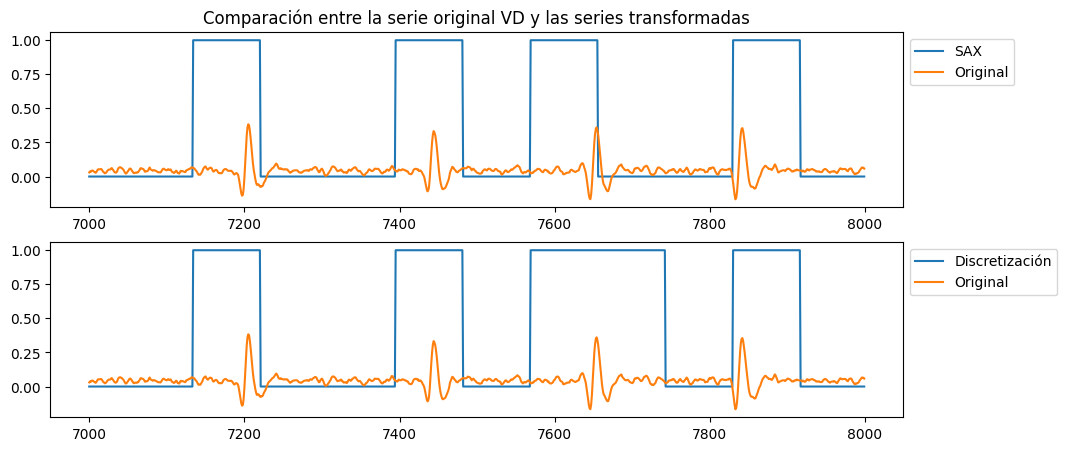

In [75]:
superponerAllVD(best_sax_abs, trozoC, best_spikes_abs, ventana=87);

# TROZO G

In [82]:
trozoG = pd.read_csv('TrozoG.txt', names = ["LP", "VD"], delimiter = '\t',
                     skiprows = range(3), index_col = False, decimal = ",")

C:\Users\Javier\AppData\Local\Temp\ipykernel_2668\1789327271.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  trozoG = pd.read_csv('TrozoG.txt', names = ["LP", "VD"], delimiter = '\t',


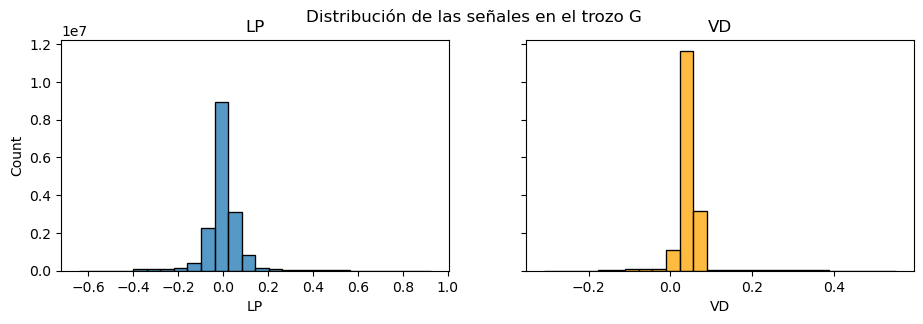

In [67]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (11,3))
fig.suptitle('Distribución de las señales en el trozo G')
ax1.set_title('LP')
ax2.set_title('VD')
sns.histplot(data = trozoG['LP'], ax = ax1, bins = int(np.floor(np.log(len(trozoG)))) + 10)
sns.histplot(data = trozoG['VD'], ax = ax2, bins = int(np.floor(np.log(len(trozoG)))) + 10, color = 'orange');

In [83]:
q99G_lp = trozoG['LP'].quantile(.99)
q99G_vd = trozoG['VD'].quantile(.99)

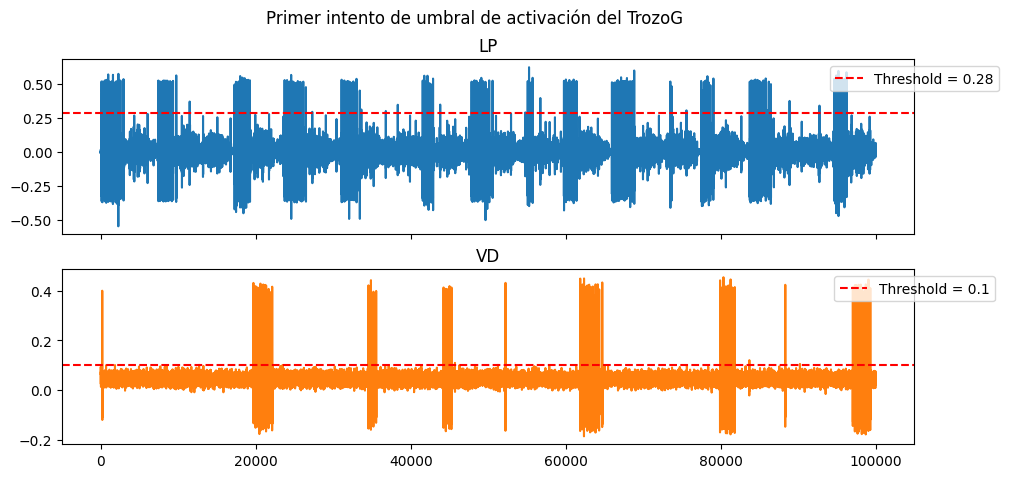

In [84]:
cant = 100000
partC = trozoG[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Primer intento de umbral de activación del TrozoG')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'])
ax1.axhline(y = q99G_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_lp,2)))
ax2.plot(range(cant), partC['VD'], 'tab:orange')
ax2.set_title('VD')
ax2.axhline(y = q99G_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center');

Se nos quedan cortos los dos umbrales.

In [85]:
q99G_lp = trozoG['LP'].quantile(.994)
q99G_vd = trozoG['VD'].quantile(.993)

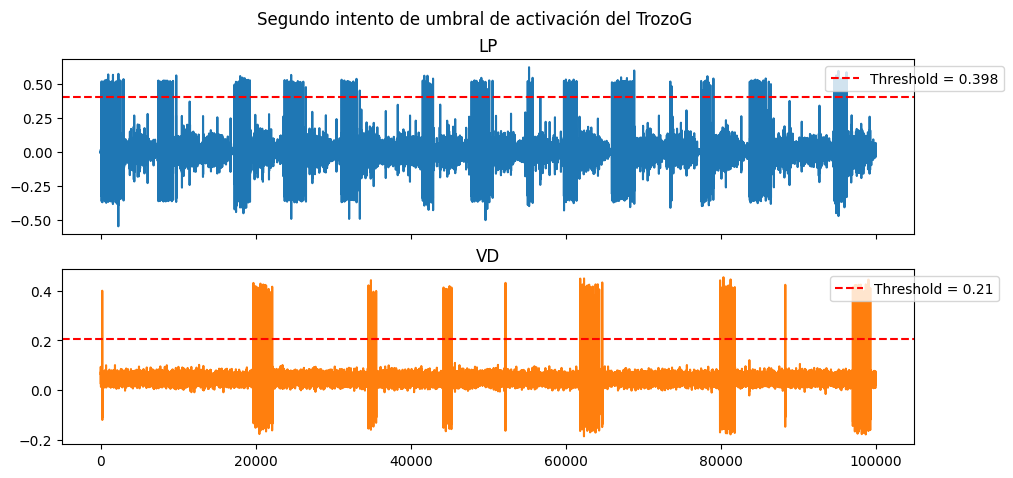

In [86]:
cant = 100000
partG = trozoG[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Segundo intento de umbral de activación del TrozoG')
ax1.set_title('LP')
ax1.plot(range(cant), partG['LP'])
ax1.axhline(y = q99G_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_lp,3)))
ax2.plot(range(cant), partG['VD'], 'tab:orange')
ax2.set_title('VD')
ax2.axhline(y = q99G_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center');

Subimos un poco el Threshold para LP.

In [87]:
q99G_lp = trozoG['LP'].quantile(.9945)
q99G_vd = trozoG['VD'].quantile(.993)

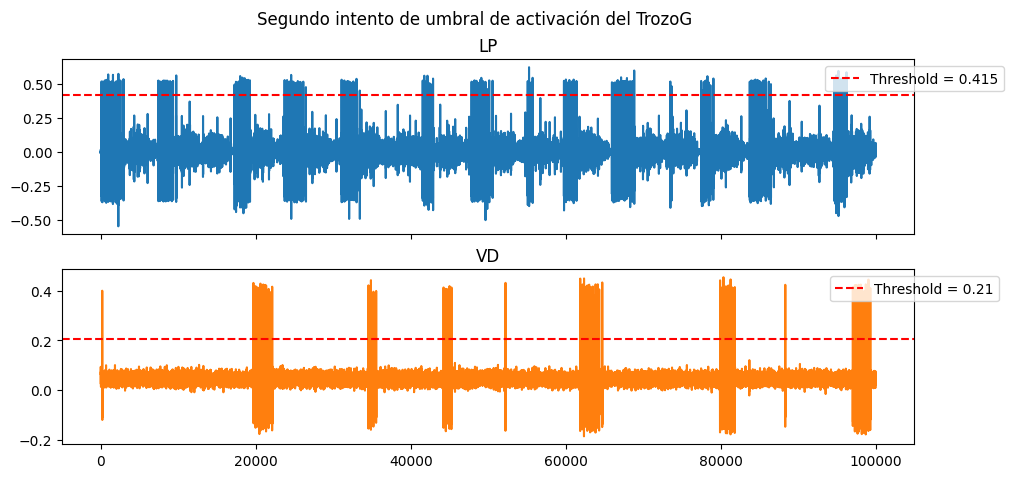

In [88]:
cant = 100000
partG = trozoG[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Segundo intento de umbral de activación del TrozoG')
ax1.set_title('LP')
ax1.plot(range(cant), partG['LP'])
ax1.axhline(y = q99G_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_lp,3)))
ax2.plot(range(cant), partG['VD'], 'tab:orange')
ax2.set_title('VD')
ax2.axhline(y = q99G_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center');

Transformamos las señales.

In [89]:
trozoG_transf = trozoG.copy()
trozoG_transf['LP'] = series_to_bin(trozoG_transf['LP'], q99G_lp)
trozoG_transf['VD'] = series_to_bin(trozoG_transf['VD'], q99G_vd)

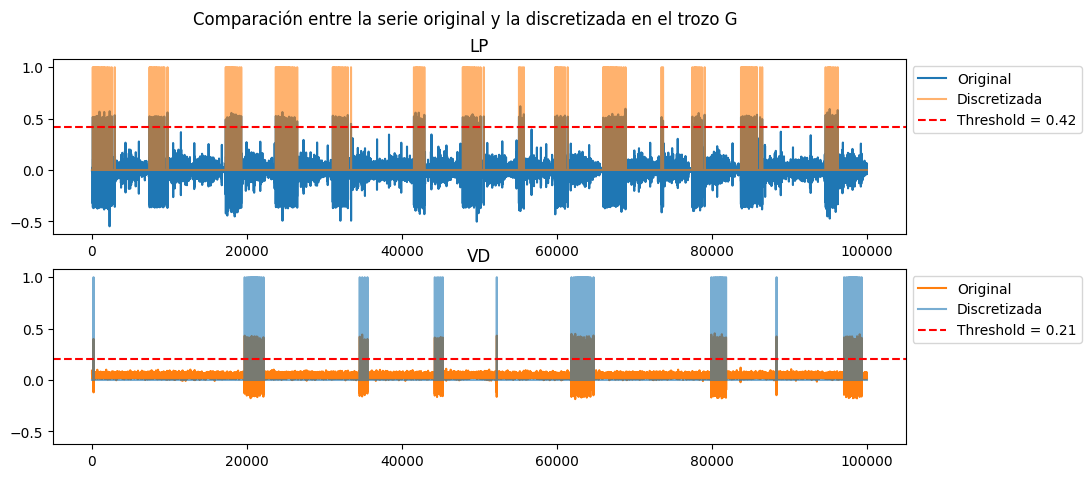

In [90]:
cant = 100000
partC = trozoG[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
fig.suptitle('Comparación entre la serie original y la discretizada en el trozo G')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'], label = 'Original')
ax1.plot(range(cant), trozoG_transf['LP'][0:cant], alpha = 0.6, label = 'Discretizada')
ax1.axhline(y = q99G_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_lp,2)))
ax2.set_title('VD')
ax2.plot(range(cant), partG['VD'],'tab:orange',label = 'Original')
ax2.plot(range(cant), trozoG_transf['VD'][0:cant], alpha = 0.6, label = 'Discretizada')
ax2.axhline(y = q99G_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

### Etiquetado de spikes

In [91]:
index_lp = find_peaks(trozoG_transf['LP'])[0]
index_vd = find_peaks(trozoG_transf['VD'])[0]
trozoG_def = trozoG_transf.copy()
trozoG_def['LP'] = 0
trozoG_def['VD'] = 0
trozoG_def.loc[index_lp,['LP']] = 1
trozoG_def.loc[index_vd,['VD']] = 1

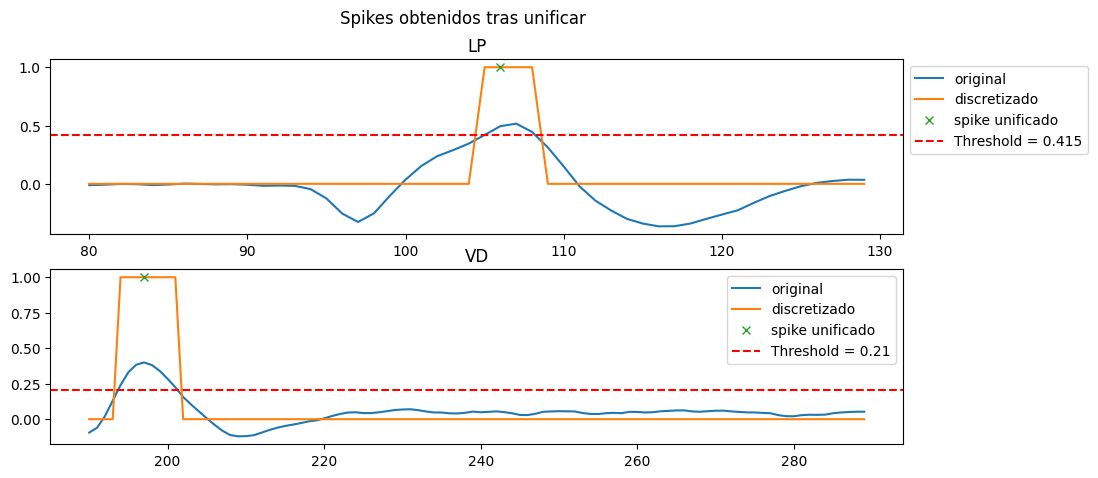

In [92]:
cant = 10000
partC = trozoG_transf[80:130]
index_lp_low = index_lp[(index_lp > 80) & (index_lp<130)]
index_vd_low = index_vd[(index_vd > 190) & (index_vd<290)]
fig, (ax1, ax2) = plt.subplots(2, sharex = False, figsize = (11,5))
fig.suptitle('Spikes obtenidos tras unificar')
ax1.set_title('LP')
ax1.plot(range(80,130), trozoG['LP'][80:130], label = 'original')
ax1.plot(range(80,130), partC['LP'], label = 'discretizado')
ax1.plot(index_lp_low, trozoG_def.loc[index_lp_low,['LP']], 'x', label = 'spike unificado')
ax1.axhline(y = q99G_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_lp,3)))
ax2.plot(range(190,290), trozoG['VD'][190:290], label = 'original')
ax2.plot(range(190,290), trozoG_transf['VD'][190:290], label = 'discretizado')
ax2.plot(index_vd_low, trozoG_def.loc[index_vd_low,['VD']], 'x', label = 'spike unificado')
ax2.set_title('VD')
ax2.axhline(y = q99G_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99G_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

### Selección de la ventana

In [93]:
dist_lp = finddist_spike(trozoG_def[trozoG_def['LP'] == 1].index)
dist_vd = finddist_spike(trozoG_def[trozoG_def['VD'] == 1].index)
q05_lp = np.quantile(dist_lp, 0.05)
q05_vd = np.quantile(dist_vd, 0.05)
print('El tamaño de ventana mínimo para tener el 5% de spikes en LP en la misma bin es: ' + str(q05_lp))
print('El tamaño de ventana mínimo para tener el 5% de spikes en VD en la misma bin es: ' + str(q05_vd))
print('El tamaño de ventana que tomaremos será ' + str(min(q05_lp, q05_vd)))

NameError: name 'finddist_spike' is not defined

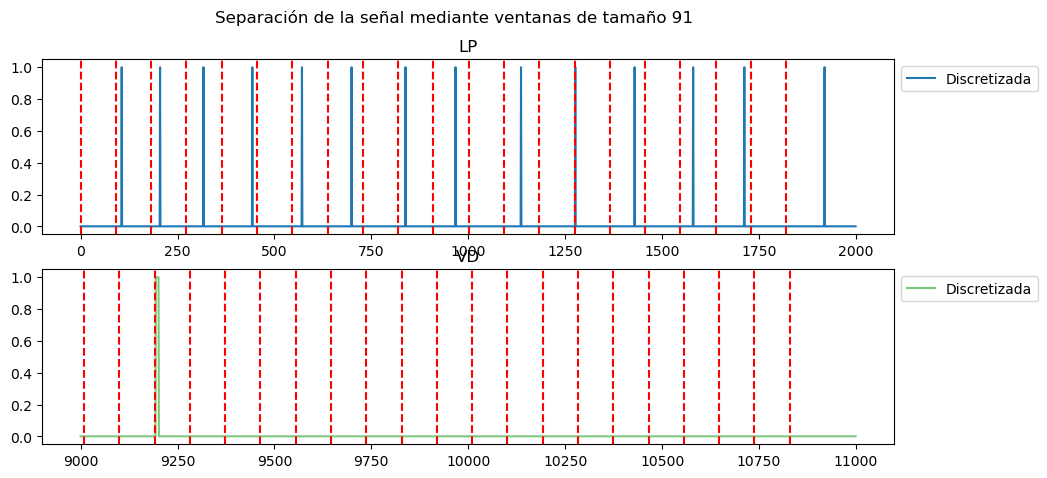

In [ ]:
ini = 0
fin = 2000
cant = fin - ini
ventana = 91
partC = trozoG_def[ini:fin]
fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
fig.suptitle('Separación de la señal mediante ventanas de tamaño 91')
ax1.set_title('LP')
ax1.plot(range(ini, fin), partC['LP'], label = 'Discretizada')
for i in range(ini + (-ini % ventana),fin - (fin%ventana),ventana):
    ax1.axvline(x = i, color = 'red', linestyle = '--')
    

ax2.set_title('VD')
ini = 9000
fin = 11000
cant = fin - ini
partC = trozoG_def[ini:fin]
ax2.plot(range(ini, fin), trozoG_transf['VD'][0:cant], 'tab:green' , alpha = 0.6, label = 'Discretizada')
for i in range(ini + (-ini % ventana),fin - (fin%ventana),ventana):
    ax2.axvline(x = i, color = 'red', linestyle = '--')
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

In [94]:
lista_ventanasG = [agrup_ventana(trozoG_transf, i) for i in range(1,92)]

In [95]:
#Solo hemos calculado las entropias una vez
#lista_entropyG = [entropia(frame, range(1,9)) for frame in lista_ventanasG]
#with open('lista_entropiasG', 'wb') as f:
#    pickle.dump(lista_entropyG, f)
with open('lista_entropiasG', 'rb') as f:
    lista_entropyG = pickle.load(f)

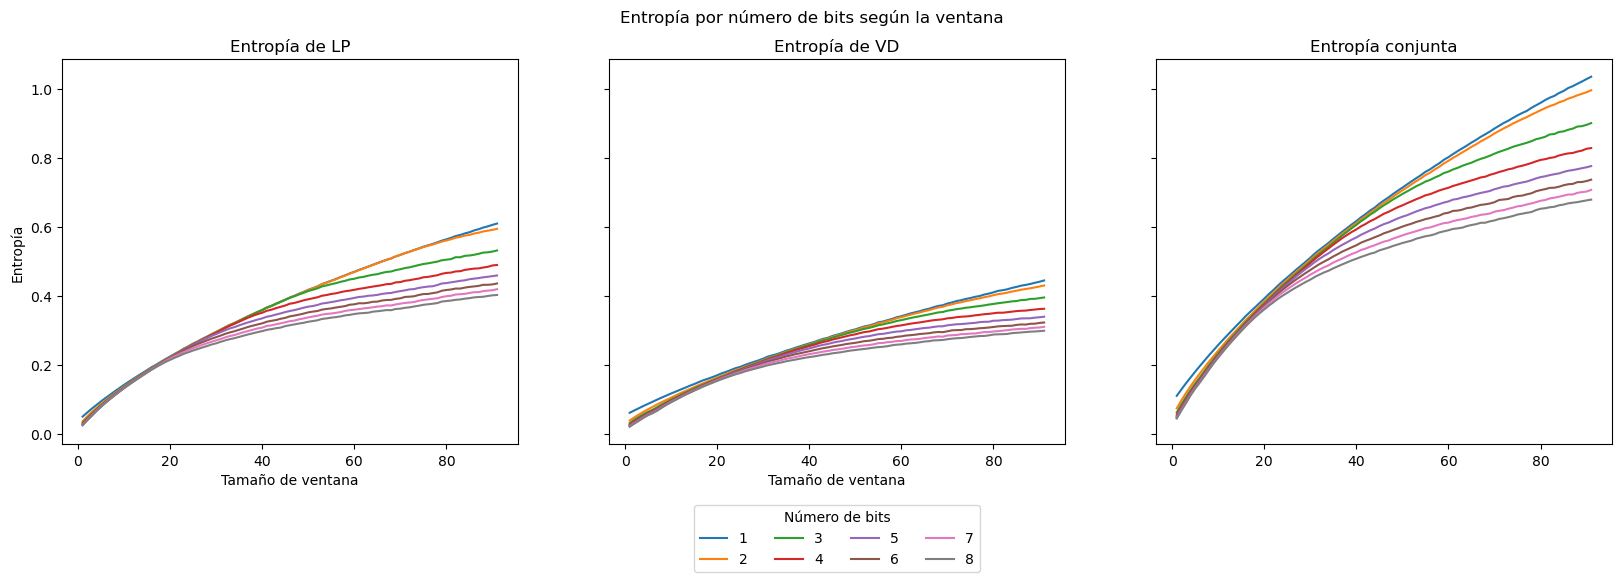

In [106]:
display_Entropy_togh(lista_ventanasG, lista_entropyG)

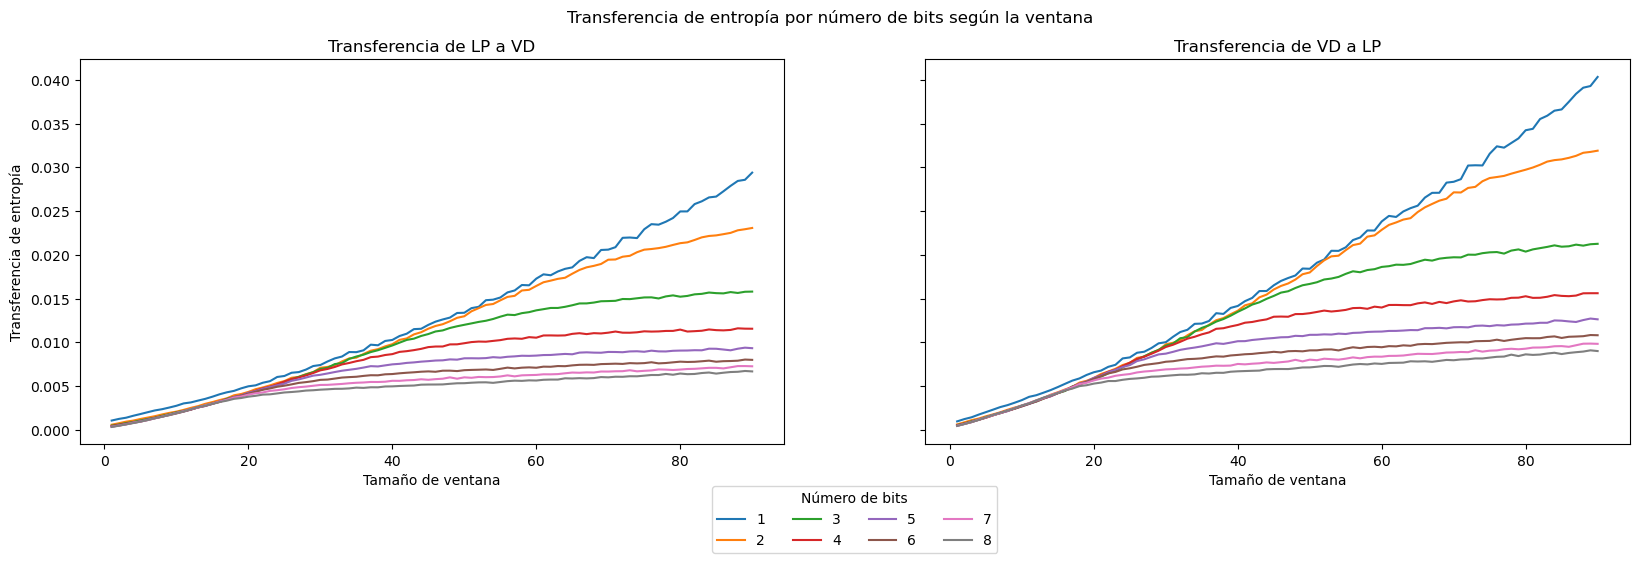

In [114]:
display_Snorm_togh(lista_ventanasG, lista_entropyG)

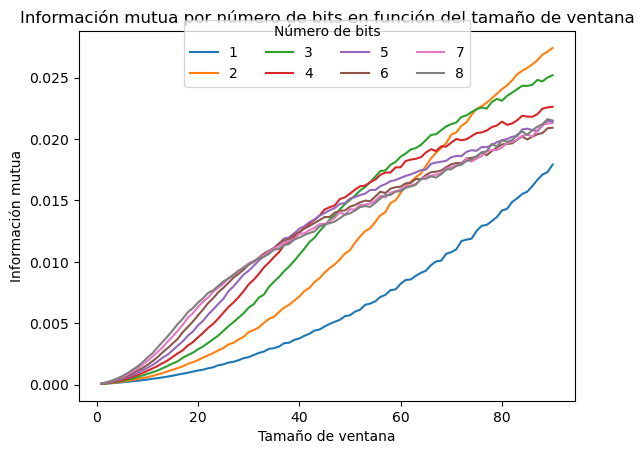

In [118]:
display_MI_togh(lista_ventanasG, lista_entropyG)

### SAX Trozo G

In [27]:
PAA_trozoG = trozoG.copy()
PAA_trozoG['LP'] = (PAA_trozoG['LP'] - PAA_trozoG['LP'].mean())/PAA_trozoG['LP'].std()
PAA_trozoG['VD'] = (PAA_trozoG['VD'] - PAA_trozoG['VD'].mean())/PAA_trozoG['VD'].std()

In [33]:
list_PAAG = [sax(PAA_window(PAA_trozoG, i)) for i in range(1,92)]

In [34]:
with open('list_PAAG', 'wb') as f:
   pickle.dump(list_PAAG, f)
with open('list_PAAG', 'rb') as f:
    list_PAAG = pickle.load(f)

In [140]:
lista_entropia_SAXG= [entropia(frame,range(1,9)) for frame in list_PAAG] 

In [26]:
#with open('lista_entropia_SAXG', 'wb') as f:
#    pickle.dump(lista_entropia_SAXG, f)
with open('lista_entropia_SAXG', 'rb') as f:
    lista_entropia_SAXG = pickle.load(f)

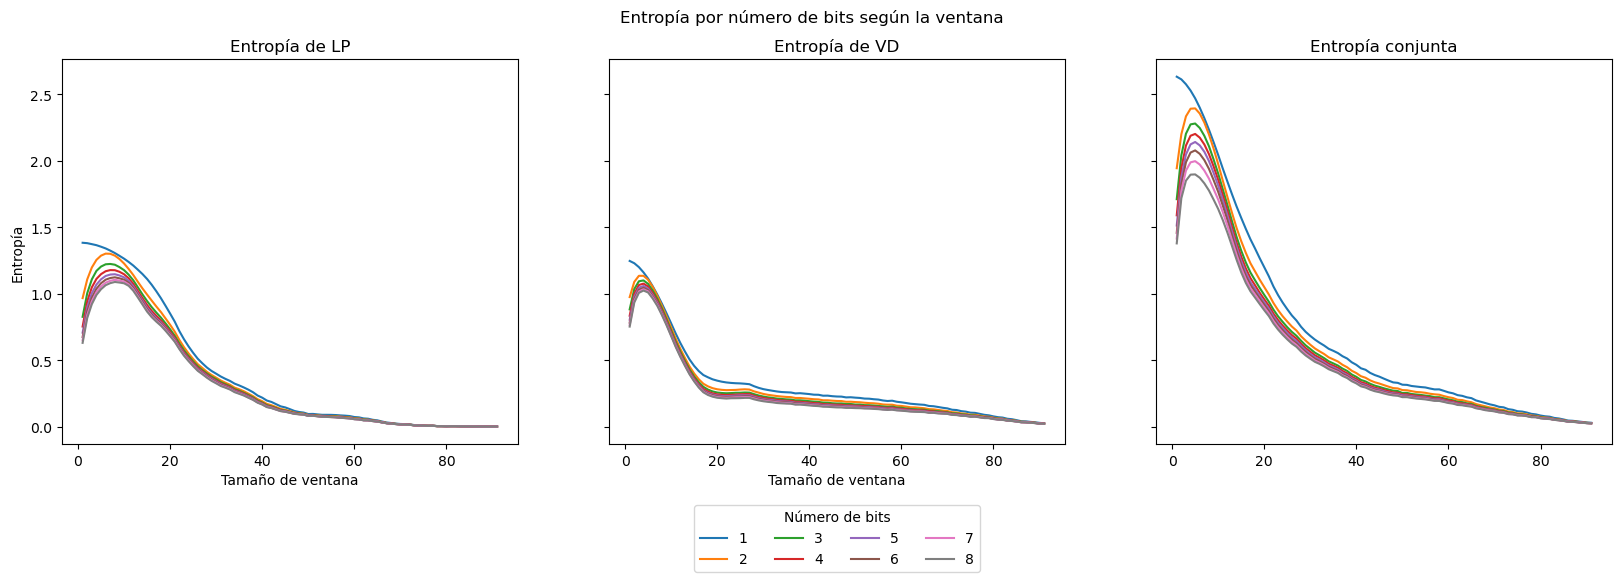

In [126]:
display_Entropy_togh(list_PAAG, lista_entropia_SAXG) 

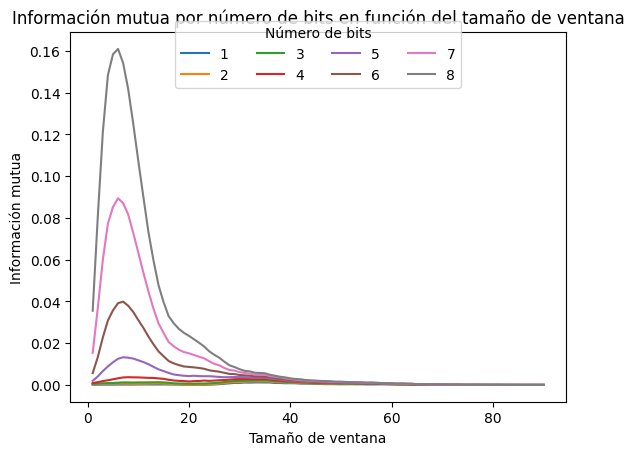

In [35]:
display_MI_togh(list_PAAG, lista_entropia_SAXG)

In [137]:
entropy_thogG = [entropia_conj(lista_ventanasG[i],list_PAAG[i],range(1,9)) for i in range(0,91) ]

In [138]:
with open('entropy_thogG', 'wb') as f:
    pickle.dump(entropy_thogG, f)
with open('entropy_thogG', 'rb') as f:
    entropy_thogG = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.0560140213042708 y se alcanza en la ventana 20
La información mútua máxima para LP con 2 bits es 0.08644371564835829 y se alcanza en la ventana 29
La información mútua máxima para LP con 3 bits es 0.10563910950158673 y se alcanza en la ventana 29
La información mútua máxima para LP con 4 bits es 0.11474131028715673 y se alcanza en la ventana 29
La información mútua máxima para LP con 5 bits es 0.12189057212395973 y se alcanza en la ventana 29
La información mútua máxima para LP con 6 bits es 0.12574762070267767 y se alcanza en la ventana 29
La información mútua máxima para LP con 7 bits es 0.12668778296521058 y se alcanza en la ventana 29
La información mútua máxima para LP con 8 bits es 0.12804545922886357 y se alcanza en la ventana 29
La información mútua máxima para VD con 1 bits es 0.12605390761593532 y se alcanza en la ventana 26
La información mútua máxima para VD con 2 bits es 0.13779335972485734 y se alcanza en la ventana 26
L

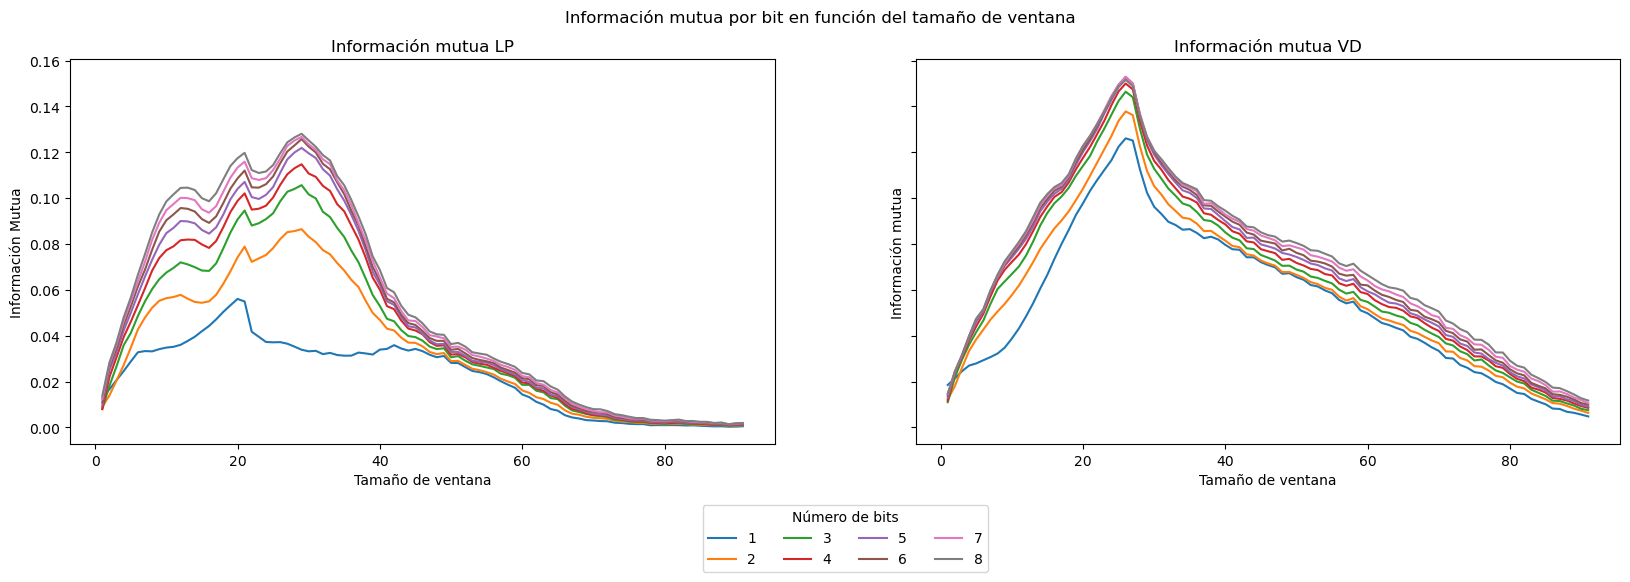

In [145]:
display_heatmap(lista_entropyG, lista_entropia_SAXG, entropy_thogG)

Binarizamos

In [36]:
list_SAX_binG = list_PAAG.copy()
for i in range(len(list_SAX_binG)):
    list_SAX_binG[i]['LP'].loc[list_SAX_binG[i]['LP'] == 'a'] = 'b'
    list_SAX_binG[i]['VD'].loc[list_SAX_binG[i]['VD'] == 'a'] = 'b'

In [147]:
#lista_entropia_SAX_binG = [entropia(frame,range(1,9)) for frame in list_SAX_binG] 

In [37]:
#with open('lista_entropia_SAX_binG', 'wb') as f:
#    pickle.dump(lista_entropia_SAX_binG, f)
with open('lista_entropia_SAX_binG', 'rb') as f:
    lista_entropia_SAX_binG = pickle.load(f)

In [149]:
#entropy_thog_binG = [entropia_conj(lista_ventanasG[i],list_SAX_binG[i],range(1,9)) for i in range(0,91)]

In [150]:
#with open('entropy_thog_binG', 'wb') as f:
#    pickle.dump(entropy_thog_binG, f)
#with open('entropy_thog_binG', 'rb') as f:
#    entropy_thog_binG = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.0486023827963854 y se alcanza en la ventana 20
La información mútua máxima para LP con 2 bits es 0.0666717083223573 y se alcanza en la ventana 29
La información mútua máxima para LP con 3 bits es 0.07840972857451438 y se alcanza en la ventana 29
La información mútua máxima para LP con 4 bits es 0.08573844954007775 y se alcanza en la ventana 29
La información mútua máxima para LP con 5 bits es 0.09086791678445491 y se alcanza en la ventana 29
La información mútua máxima para LP con 6 bits es 0.09318821591542203 y se alcanza en la ventana 29
La información mútua máxima para LP con 7 bits es 0.0938947086975255 y se alcanza en la ventana 29
La información mútua máxima para LP con 8 bits es 0.09465604462321414 y se alcanza en la ventana 29
La información mútua máxima para VD con 1 bits es 0.1081232554814181 y se alcanza en la ventana 27
La información mútua máxima para VD con 2 bits es 0.12088140220274843 y se alcanza en la ventana 26
La i

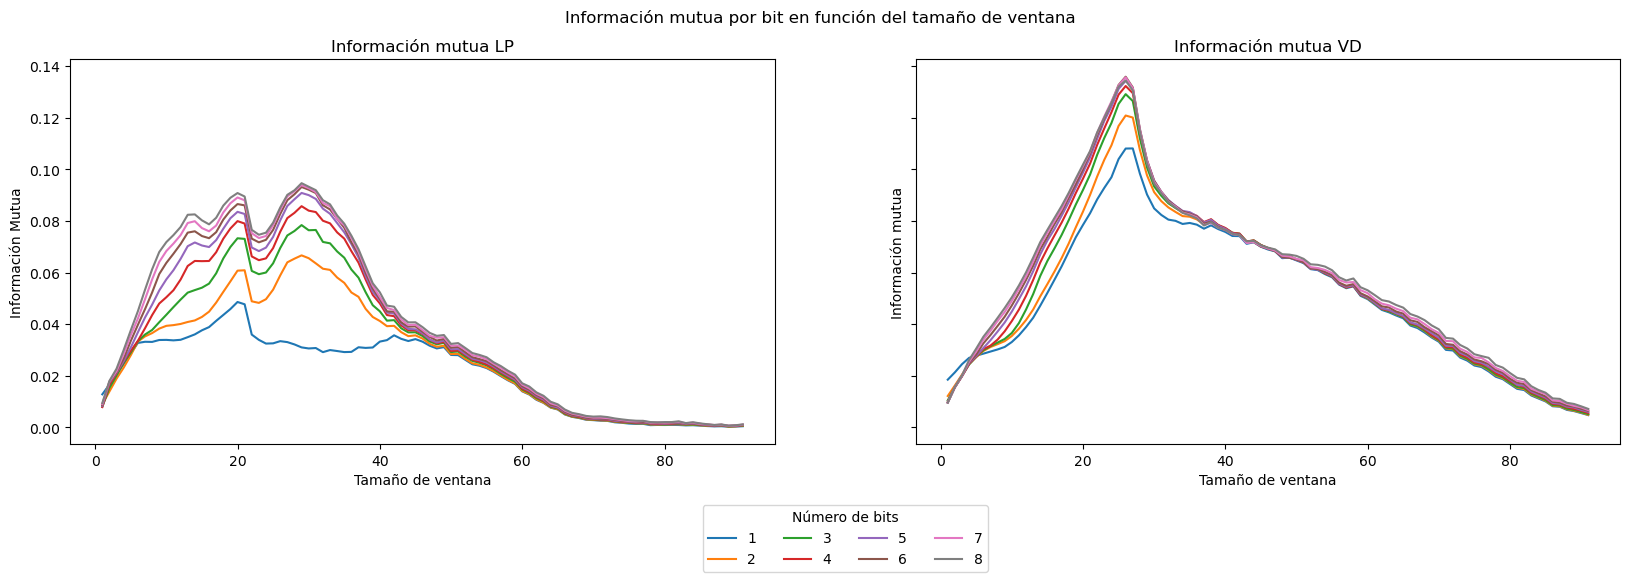

In [151]:
display_heatmap(lista_entropyG, lista_entropia_SAX_binG, entropy_thog_binG)

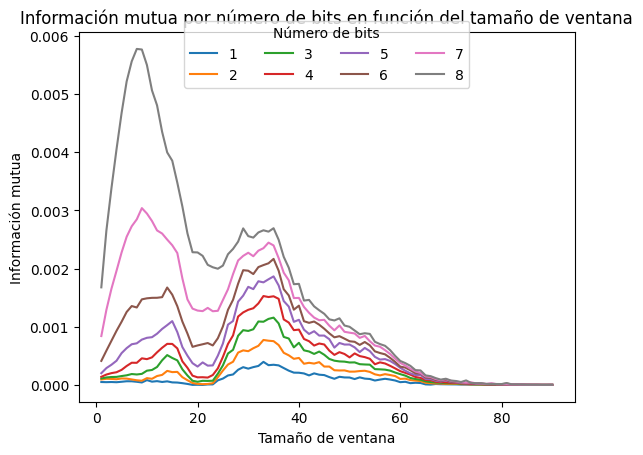

In [38]:
display_MI_togh(list_SAX_binG, lista_entropia_SAX_binG)

Mejor LP en 29, mejor VD en 26. Me quedo con la de 28.

In [152]:
best_saxG = list_SAX_binG[27]
best_spikesG = lista_ventanasG[27]
best_saxG['LP'].loc[best_saxG['LP'] == 'b'] = 0
best_saxG['LP'].loc[best_saxG['LP'] == 'c'] = 1
best_saxG['VD'].loc[best_saxG['VD'] == 'b'] = 0
best_saxG['VD'].loc[best_saxG['VD'] == 'c'] = 1

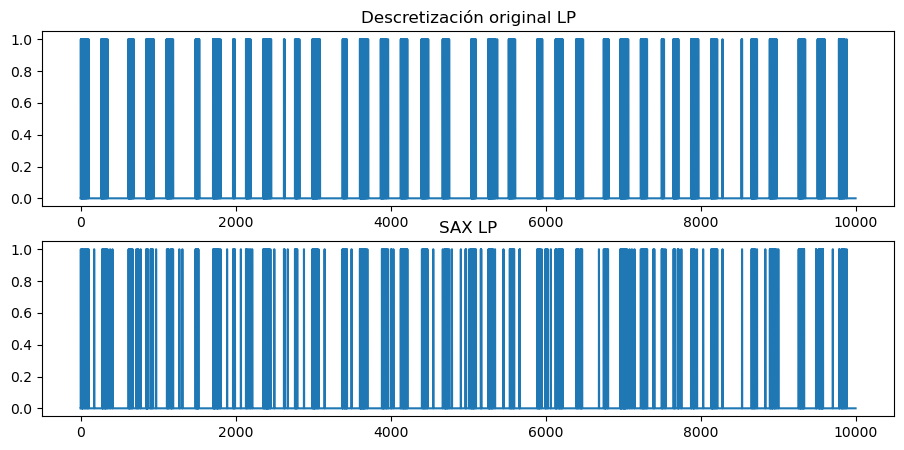

In [153]:
compare_series_LP(best_spikesG, best_saxG)

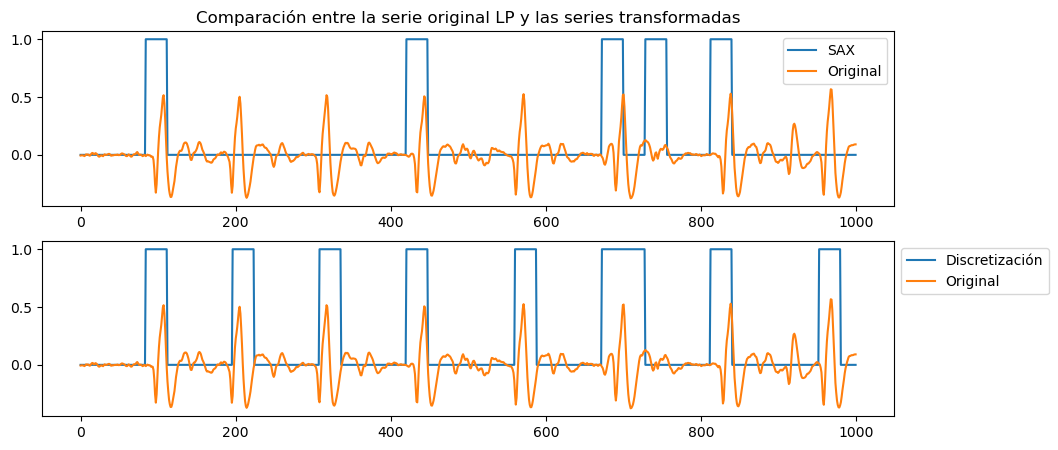

In [158]:
superponerAllLP(best_saxG, trozoG, best_spikesG, ventana = 28, rango = (0,1000));

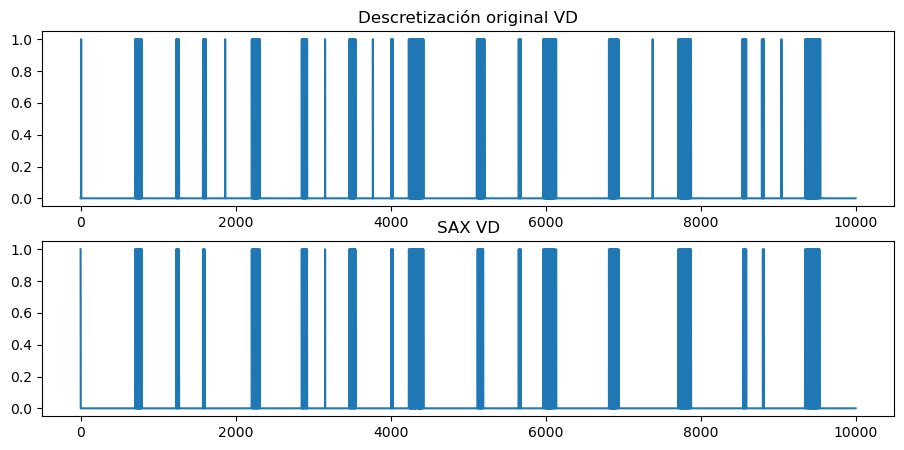

In [159]:
compare_series_VD(best_spikesG, best_saxG)

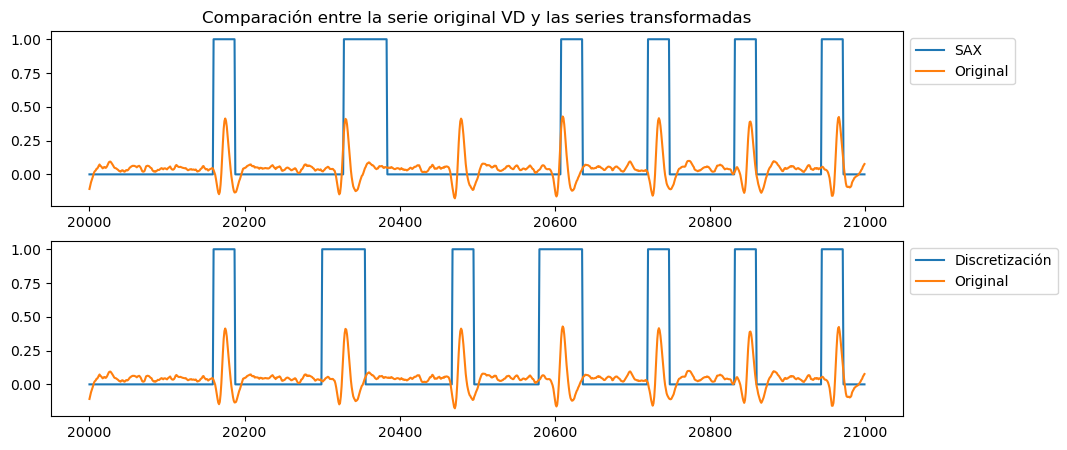

In [172]:
superponerAllVD(best_saxG, trozoG, best_spikesG, ventana = 28, rango=(20000,21000));

## SAX con valor absoluto

In [97]:
PAA_trozoG_abs = trozoG.abs().copy()
PAA_trozoG_abs['LP'] = (PAA_trozoG_abs['LP'] - PAA_trozoG_abs['LP'].mean())/PAA_trozoG_abs['LP'].std()
PAA_trozoG_abs['VD'] = (PAA_trozoG_abs['VD'] - PAA_trozoG_abs['VD'].mean())/PAA_trozoG_abs['VD'].std()

In [98]:
#list_PAAG_abs = [sax(PAA_window(PAA_trozoG_abs, i)) for i in range(1,92)]

In [39]:
#with open('list_PAAG_abs', 'wb') as f:
#   pickle.dump(list_PAAG_abs, f)
with open('list_PAAG_abs', 'rb') as f:
    list_PAAG_abs = pickle.load(f)

In [100]:
#lista_entropia_SAXG_abs= [entropia(frame,range(1,9)) for frame in list_PAAG_abs] 

In [40]:
#with open('lista_entropia_SAXG_abs', 'wb') as f:
#    pickle.dump(lista_entropia_SAXG_abs, f)
with open('lista_entropia_SAXG_abs', 'rb') as f:
    lista_entropia_SAXG_abs = pickle.load(f)

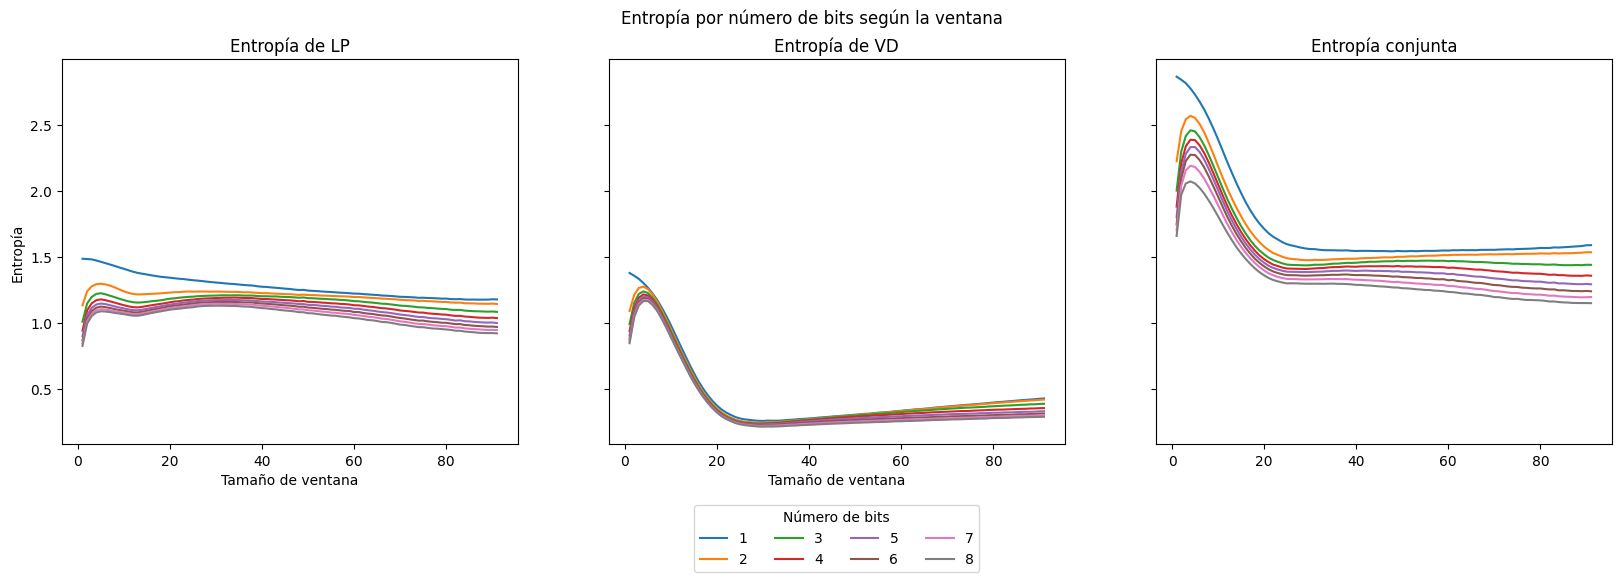

In [102]:
#display_Entropy_togh(list_PAAG_abs, lista_entropia_SAXG_abs) 

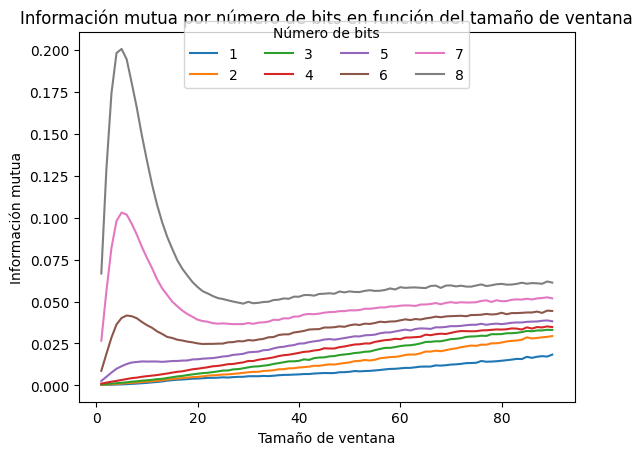

In [41]:
display_MI_togh(list_PAAG_abs, lista_entropia_SAXG_abs)

In [103]:
#entropy_thogG_abs = [entropia_conj(lista_ventanasG[i],list_PAAG_abs[i],range(1,9)) for i in range(0,91) ]

In [104]:
#with open('entropy_thogG_abs', 'wb') as f:
#    pickle.dump(entropy_thogG_abs, f)
with open('entropy_thogG_abs', 'rb') as f:
    entropy_thogG_abs = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.4292779604710333 y se alcanza en la ventana 91
La información mútua máxima para LP con 2 bits es 0.427693355672325 y se alcanza en la ventana 91
La información mútua máxima para LP con 3 bits es 0.38989778253586893 y se alcanza en la ventana 91
La información mútua máxima para LP con 4 bits es 0.36393893442131464 y se alcanza en la ventana 91
La información mútua máxima para LP con 5 bits es 0.34821233181272787 y se alcanza en la ventana 91
La información mútua máxima para LP con 6 bits es 0.33933603531077444 y se alcanza en la ventana 91
La información mútua máxima para LP con 7 bits es 0.33750856945897795 y se alcanza en la ventana 91
La información mútua máxima para LP con 8 bits es 0.33582536396090845 y se alcanza en la ventana 91
La información mútua máxima para VD con 1 bits es 0.40230576163374154 y se alcanza en la ventana 91
La información mútua máxima para VD con 2 bits es 0.3963953146431537 y se alcanza en la ventana 91
La i

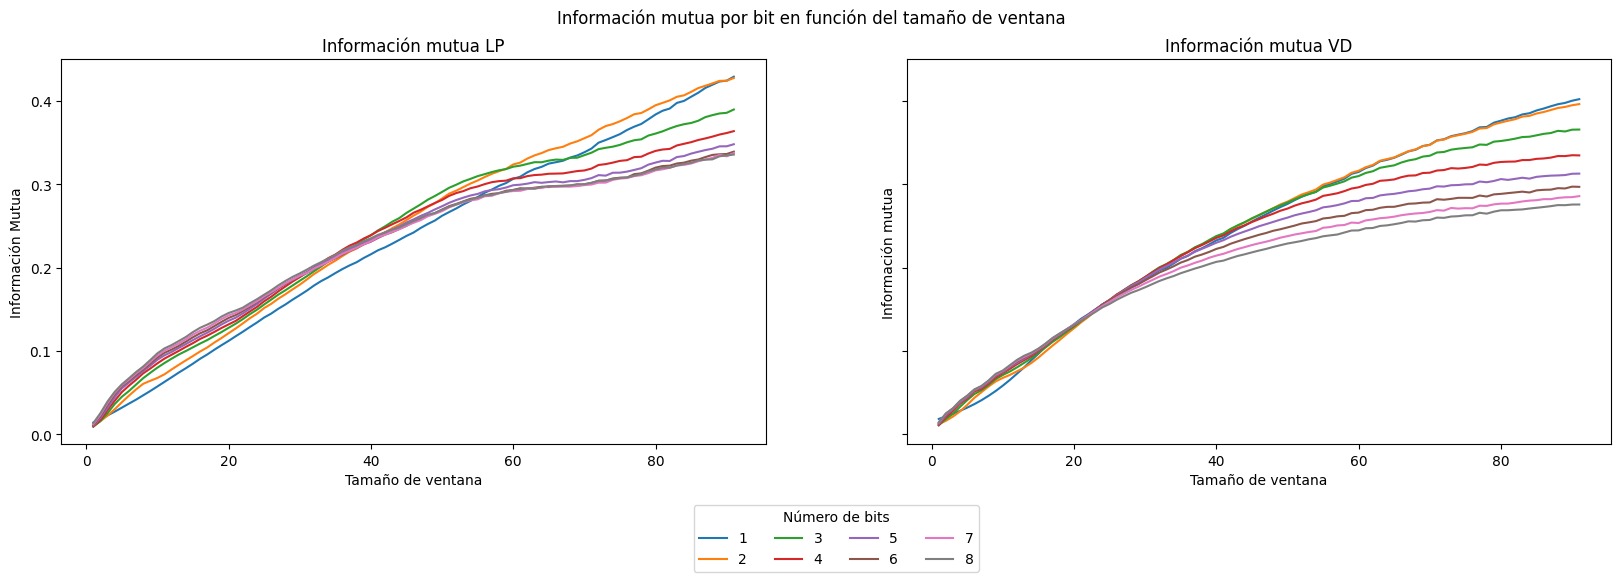

In [105]:
display_heatmap(lista_entropyG, lista_entropia_SAXG_abs, entropy_thogG_abs)

Cambiamos la a por b

In [45]:
list_SAX_binG_abs = list_PAAG_abs.copy()
for i in range(len(list_SAX_binG_abs)):
    list_SAX_binG_abs[i]['LP'].loc[list_SAX_binG_abs[i]['LP'] == 'a'] = 'b'
    list_SAX_binG_abs[i]['VD'].loc[list_SAX_binG_abs[i]['VD'] == 'a'] = 'b'

Recalculamos la entropia

In [107]:
#lista_entropia_SAX_binG_abs = [entropia(frame,range(1,9)) for frame in list_SAX_binG_abs] 

In [43]:
#with open('lista_entropia_SAX_binG_abs', 'wb') as f:
#    pickle.dump(lista_entropia_SAX_binG_abs, f)
with open('lista_entropia_SAX_binG_abs', 'rb') as f:
    lista_entropia_SAX_binG_abs = pickle.load(f)

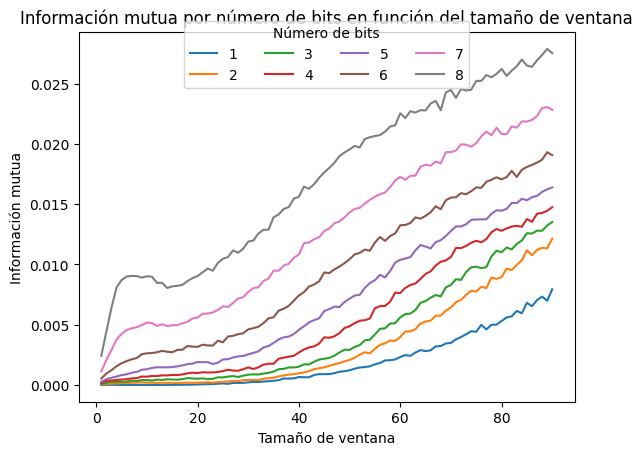

In [46]:
display_MI_togh(list_SAX_binG_abs, lista_entropia_SAX_binG_abs)

In [109]:
#entropy_thog_binG_abs = [entropia_conj(lista_ventanasG[i],list_SAX_binG_abs[i],range(1,9)) for i in range(0,91)]

In [42]:
#with open('entropy_thog_binG_abs', 'wb') as f:
#    pickle.dump(entropy_thog_binG_abs, f)
with open('entropy_thog_binG_abs', 'rb') as f:
    entropy_thog_binG_abs = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.4262929182938049 y se alcanza en la ventana 91
La información mútua máxima para LP con 2 bits es 0.4242499979001846 y se alcanza en la ventana 91
La información mútua máxima para LP con 3 bits es 0.3840981543493022 y se alcanza en la ventana 91
La información mútua máxima para LP con 4 bits es 0.35559997668480103 y se alcanza en la ventana 91
La información mútua máxima para LP con 5 bits es 0.3368212012265065 y se alcanza en la ventana 91
La información mútua máxima para LP con 6 bits es 0.32425133677411794 y se alcanza en la ventana 91
La información mútua máxima para LP con 7 bits es 0.3185750523746856 y se alcanza en la ventana 91
La información mútua máxima para LP con 8 bits es 0.3133254554968248 y se alcanza en la ventana 91
La información mútua máxima para VD con 1 bits es 0.402305517173115 y se alcanza en la ventana 91
La información mútua máxima para VD con 2 bits es 0.3963951604818031 y se alcanza en la ventana 91
La inform

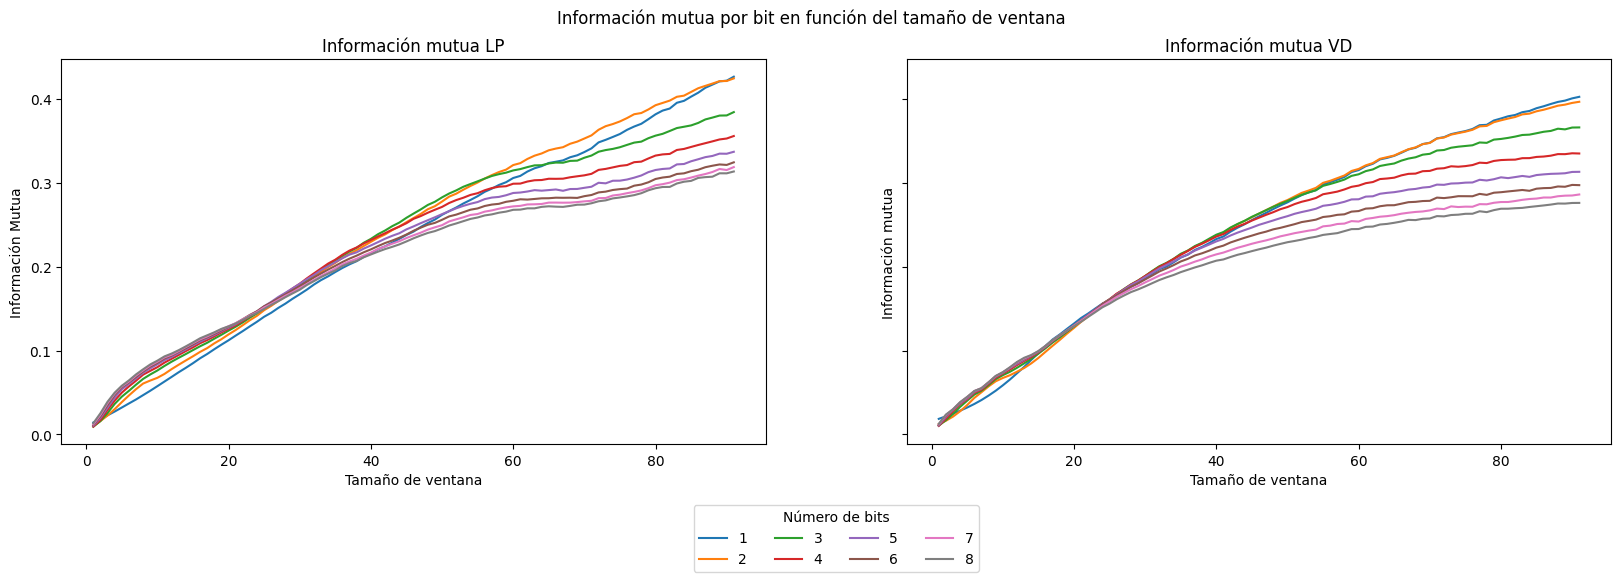

In [111]:
display_heatmap(lista_entropyG, lista_entropia_SAX_binG_abs, entropy_thog_binG_abs)

Nos quedamos con la ventana de tamaño 91

In [112]:
best_saxG_abs = list_SAX_binG_abs[90]
best_spikesG_abs = lista_ventanasG[90]
best_saxG_abs['LP'].loc[best_saxG_abs['LP'] == 'b'] = 0
best_saxG_abs['LP'].loc[best_saxG_abs['LP'] == 'c'] = 1
best_saxG_abs['VD'].loc[best_saxG_abs['VD'] == 'b'] = 0
best_saxG_abs['VD'].loc[best_saxG_abs['VD'] == 'c'] = 1

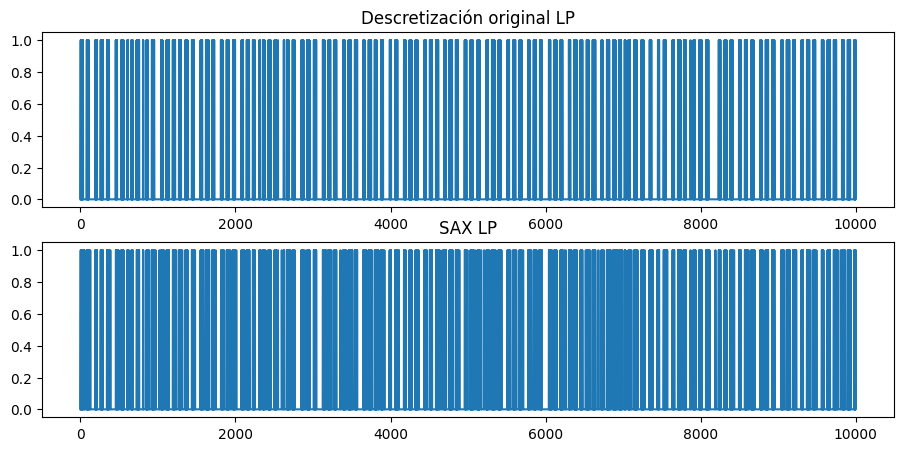

In [113]:
compare_series_LP(best_spikesG_abs, best_saxG_abs)

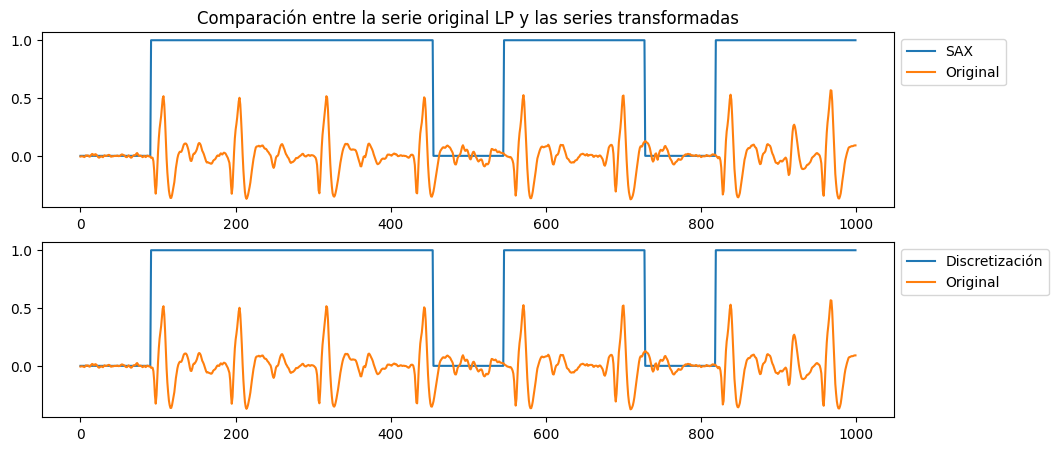

In [114]:
superponerAllLP(best_saxG_abs, trozoG, best_spikesG_abs, ventana = 91, rango = (0,1000));

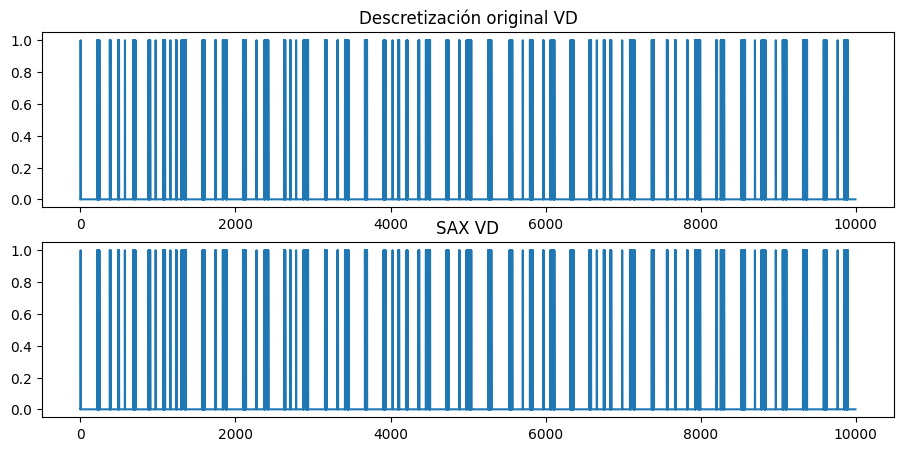

In [115]:
compare_series_VD(best_spikesG_abs, best_saxG_abs)

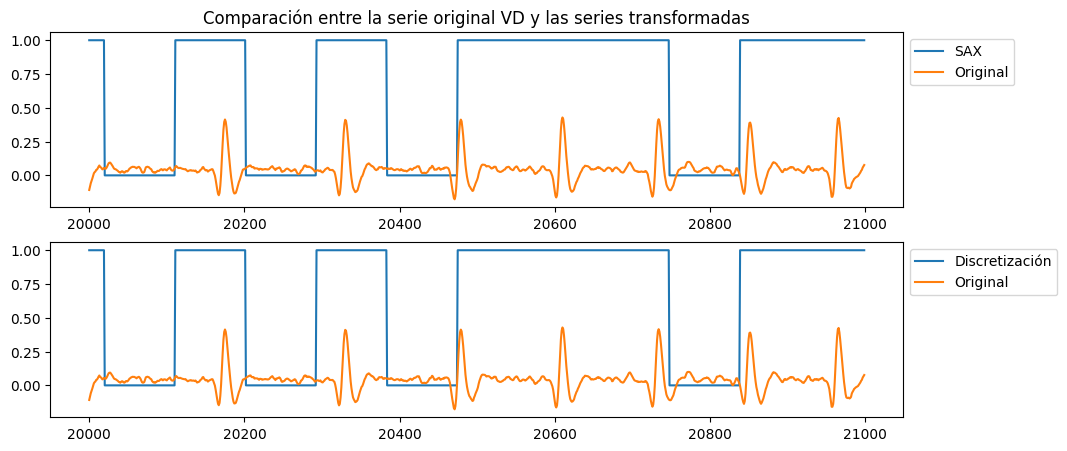

In [116]:
superponerAllVD(best_saxG_abs, trozoG, best_spikesG_abs, ventana = 91, rango=(20000,21000));

# Trozo R

In [118]:
trozoR = pd.read_csv('TrozoR.txt', names = ["LP", "VD"], delimiter = '\t',
                     skiprows = range(3), index_col = False, decimal = ",")

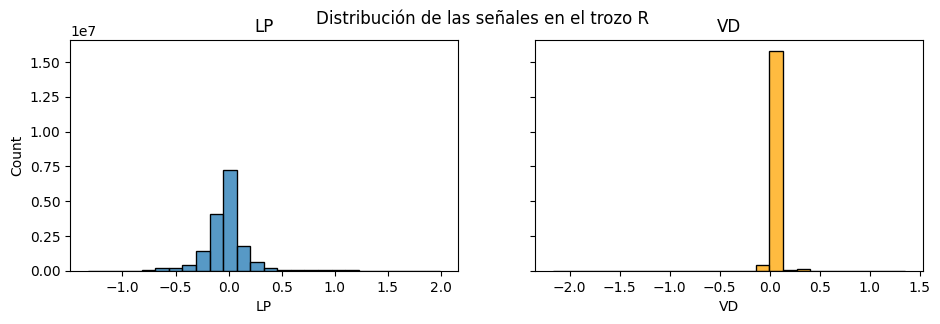

In [119]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (11,3))
fig.suptitle('Distribución de las señales en el trozo R')
ax1.set_title('LP')
ax2.set_title('VD')
sns.histplot(data = trozoR['LP'], ax = ax1, bins = int(np.floor(np.log(len(trozoR)))) + 10)
sns.histplot(data = trozoR['VD'], ax = ax2, bins = int(np.floor(np.log(len(trozoR)))) + 10, color = 'orange');

In [120]:
q99R_lp = trozoR['LP'].quantile(.99)
q99R_vd = trozoR['VD'].quantile(.99)

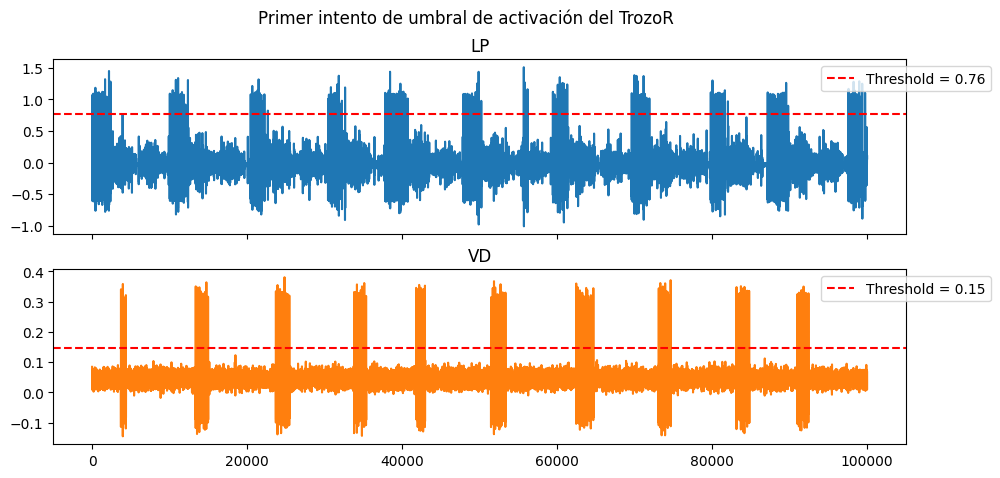

In [121]:
cant = 100000
partC = trozoR[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Primer intento de umbral de activación del TrozoR')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'])
ax1.axhline(y = q99R_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_lp,2)))
ax2.plot(range(cant), partC['VD'], 'tab:orange')
ax2.set_title('VD')
ax2.axhline(y = q99R_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center');

Parece que están casi bien los dos.

In [122]:
q99R_lp = trozoR['LP'].quantile(.994)
q99R_vd = trozoR['VD'].quantile(.993)

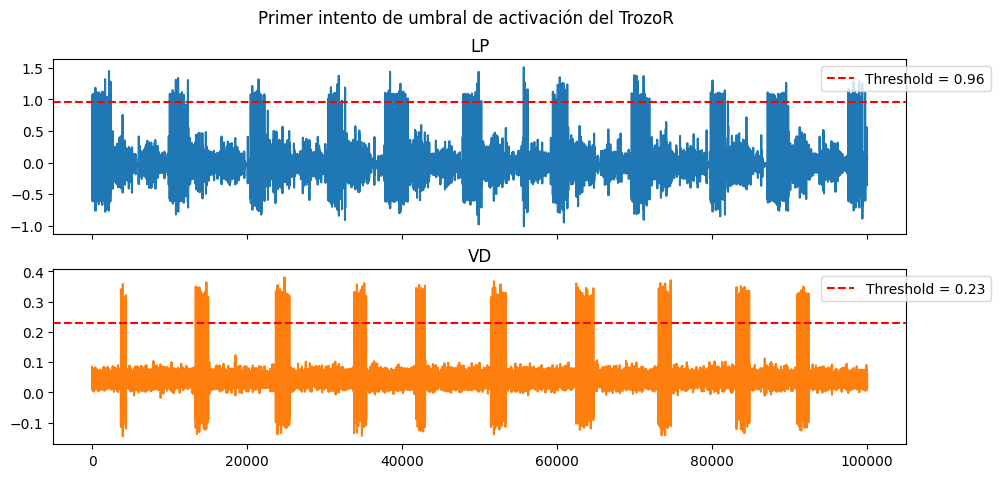

In [123]:
cant = 100000
partC = trozoR[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Primer intento de umbral de activación del TrozoR')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'])
ax1.axhline(y = q99R_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_lp,2)))
ax2.plot(range(cant), partC['VD'], 'tab:orange')
ax2.set_title('VD')
ax2.axhline(y = q99R_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center');

Pelín alto para LP

In [124]:
q99R_lp = trozoR['LP'].quantile(.993)
q99R_vd = trozoR['VD'].quantile(.993)

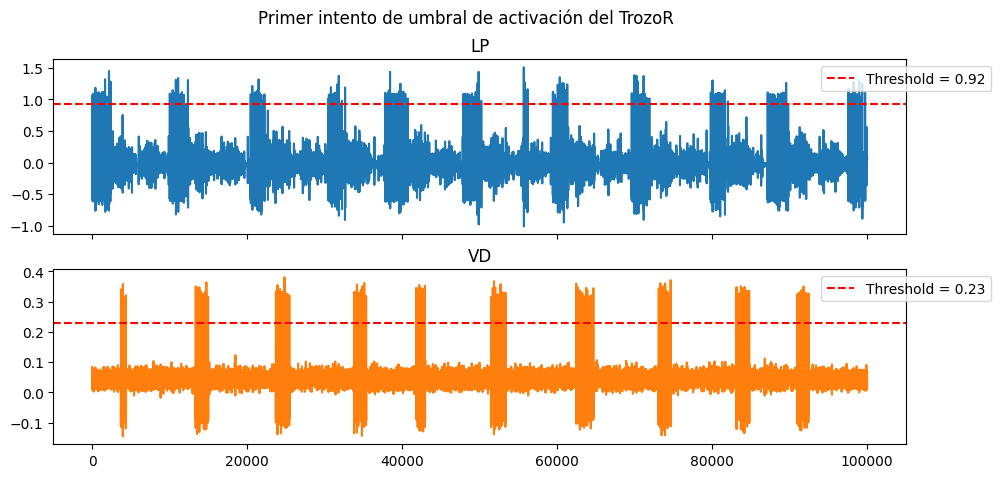

In [125]:
cant = 100000
partC = trozoR[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (11,5))
fig.suptitle('Primer intento de umbral de activación del TrozoR')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'])
ax1.axhline(y = q99R_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_lp,2)))
ax2.plot(range(cant), partC['VD'], 'tab:orange')
ax2.set_title('VD')
ax2.axhline(y = q99R_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center');

In [134]:
trozoR_transf = trozoR.copy()
trozoR_transf['LP'] = series_to_bin(trozoR_transf['LP'], q99R_lp)
trozoR_transf['VD'] = series_to_bin(trozoR_transf['VD'], q99R_vd)

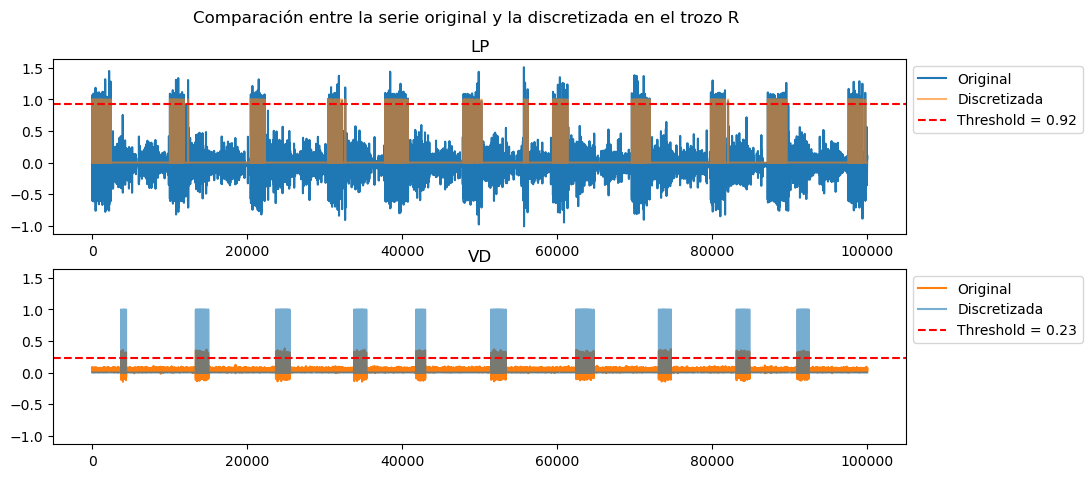

In [184]:
cant = 100000
partC = trozoR[0:cant]
fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
fig.suptitle('Comparación entre la serie original y la discretizada en el trozo R')
ax1.set_title('LP')
ax1.plot(range(cant), partC['LP'], label = 'Original')
ax1.plot(range(cant), trozoR_transf['LP'][0:cant], alpha = 0.6, label = 'Discretizada')
ax1.axhline(y = q99R_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_lp,2)))
ax2.set_title('VD')
ax2.plot(range(cant), partC['VD'],'tab:orange',label = 'Original')
ax2.plot(range(cant), trozoR_transf['VD'][0:cant], alpha = 0.6, label = 'Discretizada')
ax2.axhline(y = q99R_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

### Spikes trozoR

In [185]:
index_lp = find_peaks(trozoR_transf['LP'])[0]
index_vd = find_peaks(trozoR_transf['VD'])[0]
trozoR_def = trozoR_transf.copy()
trozoR_def['LP'] = 0
trozoR_def['VD'] = 0
trozoR_def.loc[index_lp,['LP']] = 1
trozoR_def.loc[index_vd,['VD']] = 1

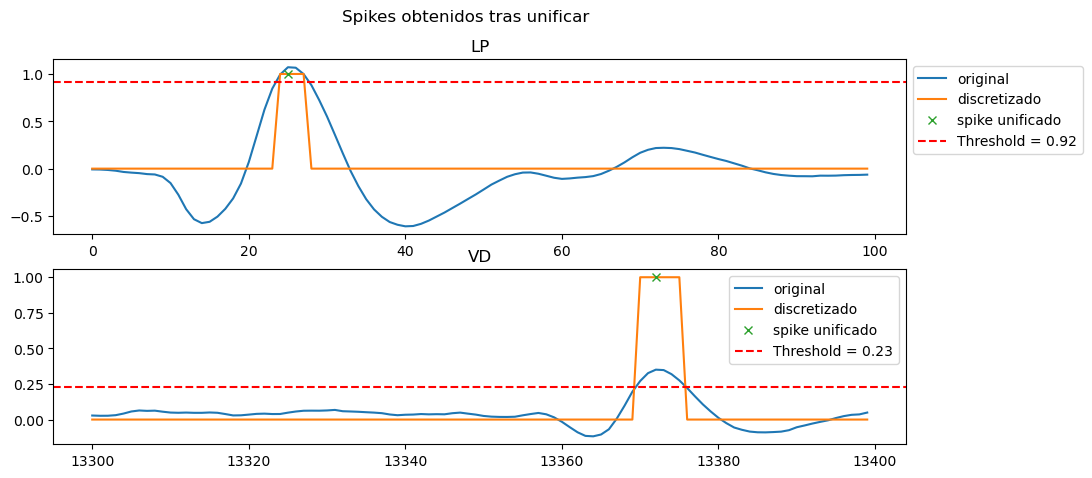

In [194]:
cant = 10000
partC = trozoR_transf[0:100]
index_lp_low = index_lp[(index_lp > 0) & (index_lp<100)]
index_vd_low = index_vd[(index_vd > 13300) & (index_vd<13400)]
fig, (ax1, ax2) = plt.subplots(2, sharex = False, figsize = (11,5))
fig.suptitle('Spikes obtenidos tras unificar')
ax1.set_title('LP')
ax1.plot(range(0,100), trozoR['LP'][0:100], label = 'original')
ax1.plot(range(0,100), partC['LP'], label = 'discretizado')
ax1.plot(index_lp_low, trozoR_def.loc[index_lp_low,['LP']], 'x', label = 'spike unificado')
ax1.axhline(y = q99R_lp, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_lp,3)))
ax2.plot(range(13300,13400), trozoR['VD'][13300:13400], label = 'original')
ax2.plot(range(13300,13400), trozoR_transf['VD'][13300:13400], label = 'discretizado')
ax2.plot(index_vd_low, trozoR_def.loc[index_vd_low,['VD']], 'x', label = 'spike unificado')
ax2.set_title('VD')
ax2.axhline(y = q99R_vd, color = 'r', linestyle = '--', label = 'Threshold = ' + str(round(q99R_vd,2)))
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

In [195]:
dist_lp = finddist_spike(trozoR_def[trozoR_def['LP'] == 1].index)
dist_vd = finddist_spike(trozoR_def[trozoR_def['VD'] == 1].index)
q05_lp = np.quantile(dist_lp, 0.05)
q05_vd = np.quantile(dist_vd, 0.05)
print('El tamaño de ventana mínimo para tener el 5% de spikes en LP en la misma bin es: ' + str(q05_lp))
print('El tamaño de ventana mínimo para tener el 5% de spikes en VD en la misma bin es: ' + str(q05_vd))
print('El tamaño de ventana que tomaremos será ' + str(min(q05_lp, q05_vd)))

El tamaño de ventana mínimo para tener el 5% de spikes en LP en la misma bin es: 108.0
El tamaño de ventana mínimo para tener el 5% de spikes en VD en la misma bin es: 86.0
El tamaño de ventana que tomaremos será 86.0


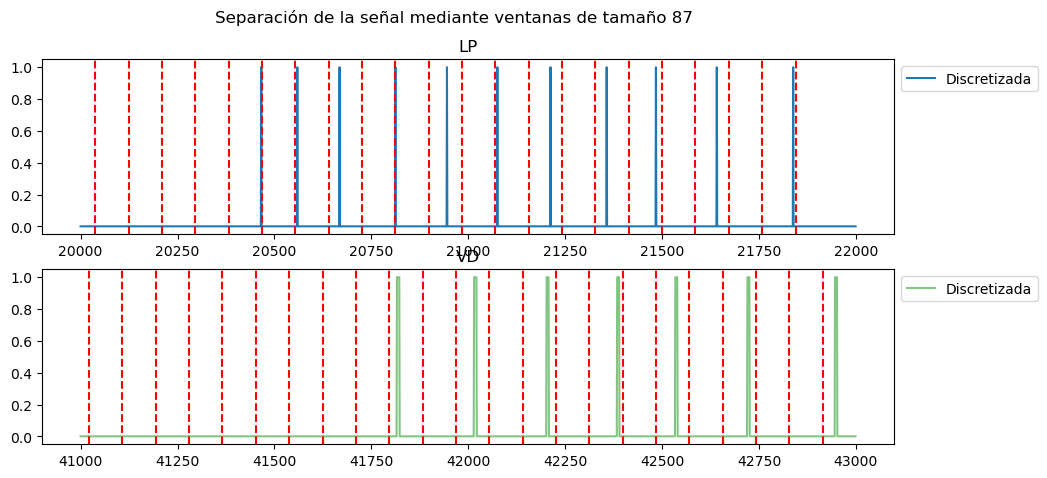

In [215]:
ini = 20000
fin = 22000
cant = fin - ini
ventana = 86
partC = trozoR_def[ini:fin]
fig, (ax1, ax2) = plt.subplots(2, sharey = True, figsize = (11,5))
fig.suptitle('Separación de la señal mediante ventanas de tamaño 87')
ax1.set_title('LP')
ax1.plot(range(ini, fin), partC['LP'], label = 'Discretizada')
for i in range(ini + (-ini % ventana),fin - (fin%ventana),ventana):
    ax1.axvline(x = i, color = 'red', linestyle = '--')
    

ax2.set_title('VD')
ini = 41000
fin = 43000
cant = fin - ini
partC = trozoR_def[ini:fin]
ax2.plot(range(ini, fin), trozoR_transf['VD'][ini:fin], 'tab:green' , alpha = 0.6, label = 'Discretizada')
for i in range(ini + (-ini % ventana),fin - (fin%ventana),ventana):
    ax2.axvline(x = i, color = 'red', linestyle = '--')
ax1.legend(bbox_to_anchor = (1.0, 1))
ax2.legend(bbox_to_anchor = (1.0, 1));

In [135]:
lista_ventanasR = [agrup_ventana(trozoR_transf, i) for i in range(1,87)]

In [136]:
#Solo hemos calculado las entropias una vez
#lista_entropyR = [entropia(frame, range(1,9)) for frame in lista_ventanasR]
#with open('lista_entropiasR', 'wb') as f:
#    pickle.dump(lista_entropyR, f)
with open('lista_entropiasR', 'rb') as f:
    lista_entropyR = pickle.load(f)

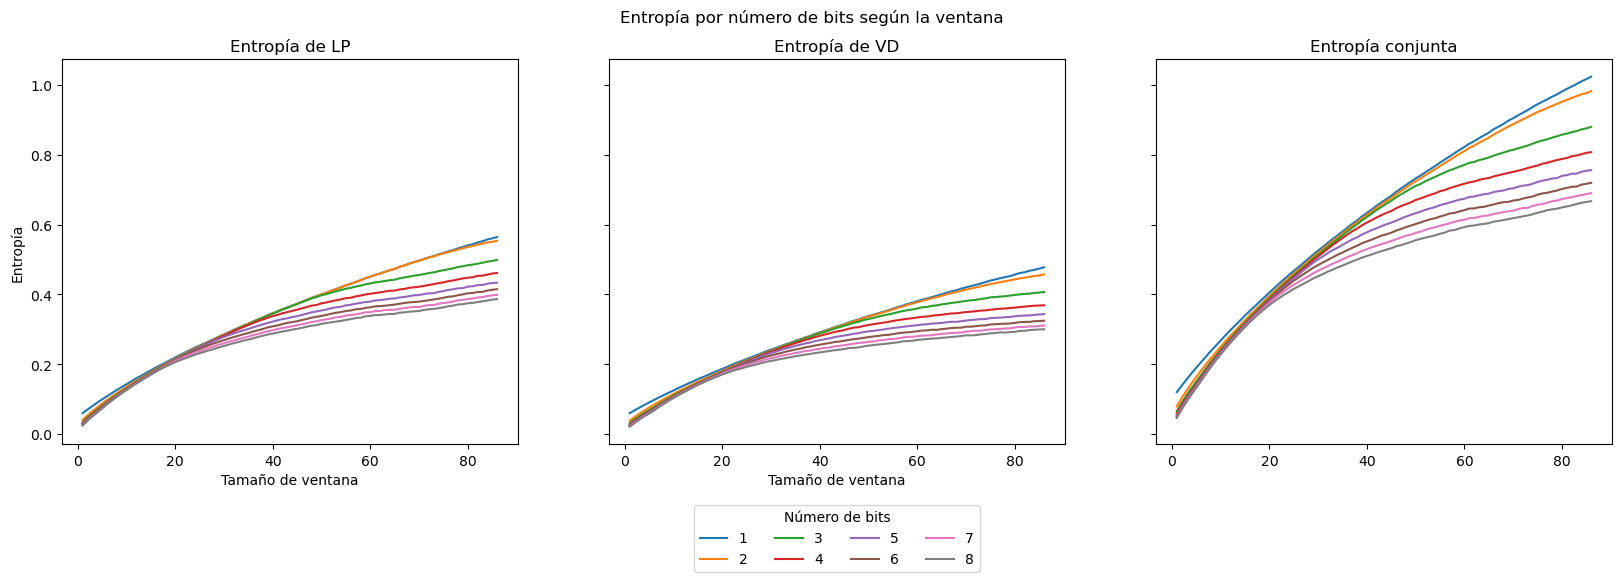

In [218]:
display_Entropy_togh(lista_ventanasR, lista_entropyR)

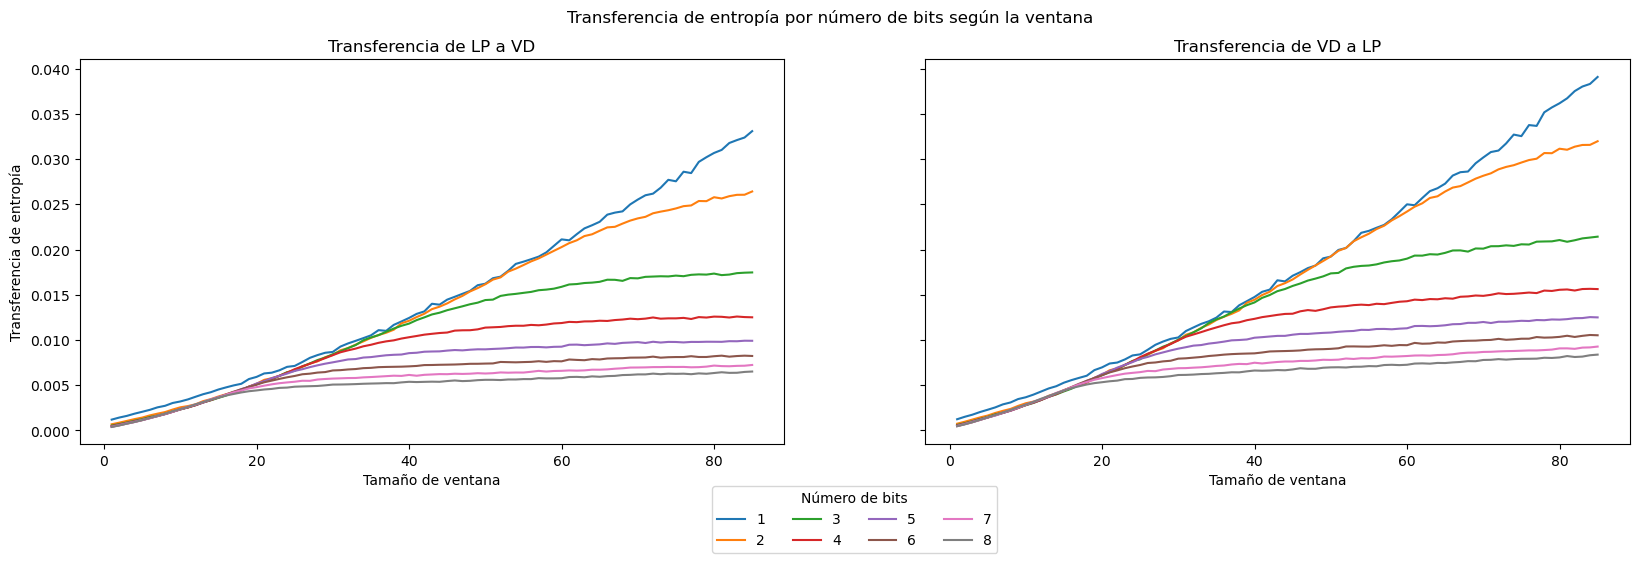

In [219]:
display_Snorm_togh(lista_ventanasR, lista_entropyR)

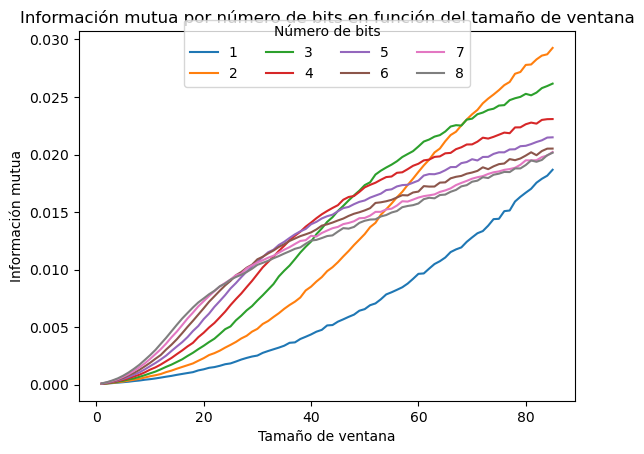

In [220]:
display_MI_togh(lista_ventanasR, lista_entropyR)

## SAX Trozo R

In [49]:
PAA_trozoR = trozoR.copy()
PAA_trozoR['LP'] = (PAA_trozoR['LP'] - PAA_trozoR['LP'].mean())/PAA_trozoR['LP'].std()
PAA_trozoR['VD'] = (PAA_trozoR['VD'] - PAA_trozoR['VD'].mean())/PAA_trozoR['VD'].std()

In [50]:
list_PAAR = [sax(PAA_window(PAA_trozoR, i)) for i in range(1,86)]

In [51]:
with open('list_PAAR', 'wb') as f:
   pickle.dump(list_PAAR, f)
with open('list_PAAR', 'rb') as f:
     list_PAAR = pickle.load(f)

In [226]:
#lista_entropia_SAXR= [entropia(frame,range(1,9)) for frame in list_PAAR] 

In [52]:
#with open('lista_entropia_SAXR', 'wb') as f:
#    pickle.dump(lista_entropia_SAXR, f)
with open('lista_entropia_SAXR', 'rb') as f:
    lista_entropia_SAXR = pickle.load(f)

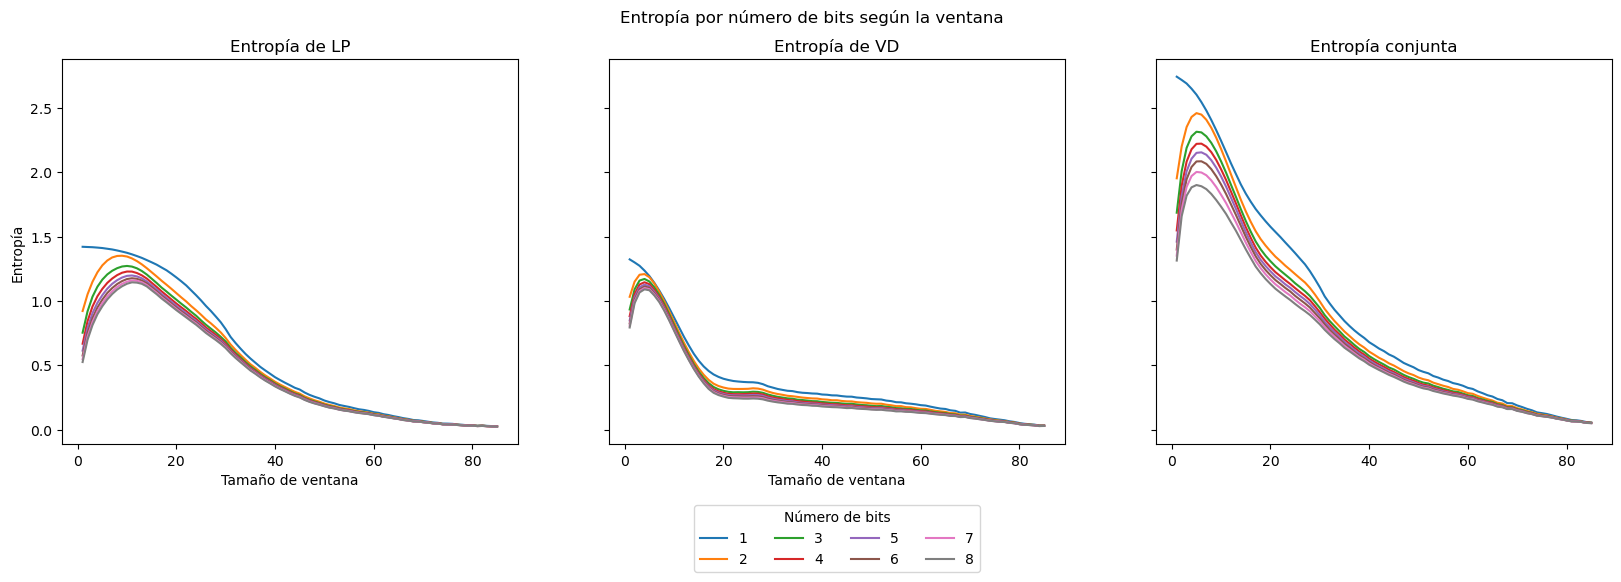

In [228]:
display_Entropy_togh(list_PAAR, lista_entropia_SAXR) 

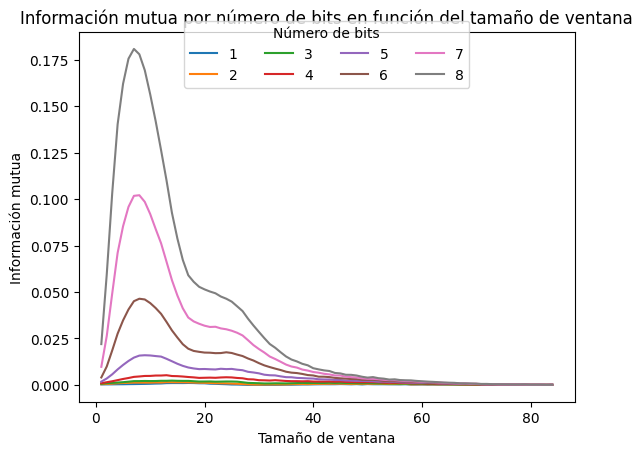

In [53]:
display_MI_togh(list_PAAR, lista_entropia_SAXR)

In [230]:
entropy_thogR = [entropia_conj(lista_ventanasR[i],list_PAAR[i],range(1,9)) for i in range(0,85) ]

ERROR! Session/line number was not unique in database. History logging moved to new session 411


In [231]:
with open('entropy_thogR', 'wb') as f:
    pickle.dump(entropy_thogR, f)
with open('entropy_thogR', 'rb') as f:
    entropy_thogR = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.07098348031125679 y se alcanza en la ventana 28
La información mútua máxima para LP con 2 bits es 0.09308110993899743 y se alcanza en la ventana 29
La información mútua máxima para LP con 3 bits es 0.10876939973251372 y se alcanza en la ventana 29
La información mútua máxima para LP con 4 bits es 0.11864232835026356 y se alcanza en la ventana 29
La información mútua máxima para LP con 5 bits es 0.12673983291960517 y se alcanza en la ventana 29
La información mútua máxima para LP con 6 bits es 0.1297242500705038 y se alcanza en la ventana 29
La información mútua máxima para LP con 7 bits es 0.13378475144215404 y se alcanza en la ventana 29
La información mútua máxima para LP con 8 bits es 0.13806801811163594 y se alcanza en la ventana 29
La información mútua máxima para VD con 1 bits es 0.1411130982766573 y se alcanza en la ventana 27
La información mútua máxima para VD con 2 bits es 0.15262731112967837 y se alcanza en la ventana 27
La

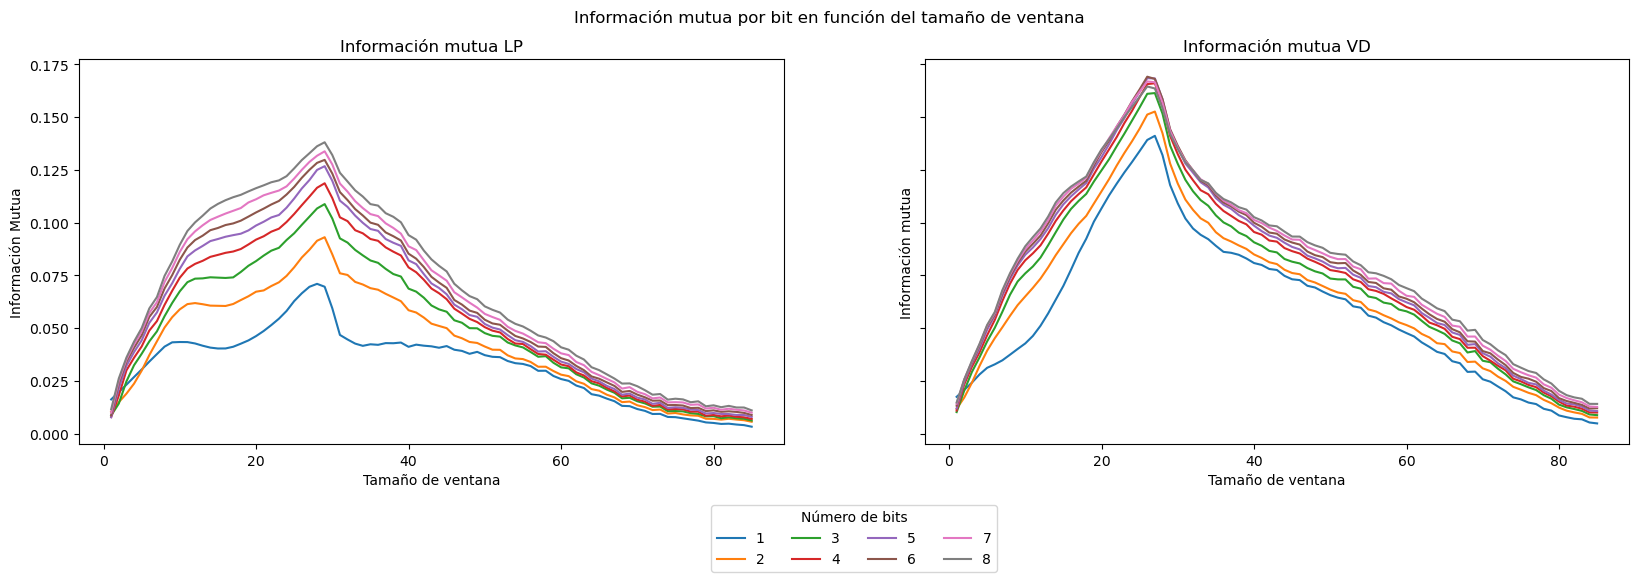

In [238]:
display_heatmap(lista_entropyR[:85], lista_entropia_SAXR, entropy_thogR)

Binarizar

In [54]:
list_SAX_binR = list_PAAR.copy()
for i in range(len(list_SAX_binR)):
    list_SAX_binR[i]['LP'].loc[list_SAX_binR[i]['LP'] == 'a'] = 'b'
    list_SAX_binR[i]['VD'].loc[list_SAX_binR[i]['VD'] == 'a'] = 'b'

In [240]:
#lista_entropia_SAX_binR = [entropia(frame,range(1,9)) for frame in list_SAX_binR] 

In [55]:
#with open('lista_entropia_SAX_binR', 'wb') as f:
#    pickle.dump(lista_entropia_SAX_binR, f)
with open('lista_entropia_SAX_binR', 'rb') as f:
    lista_entropia_SAX_binR = pickle.load(f)

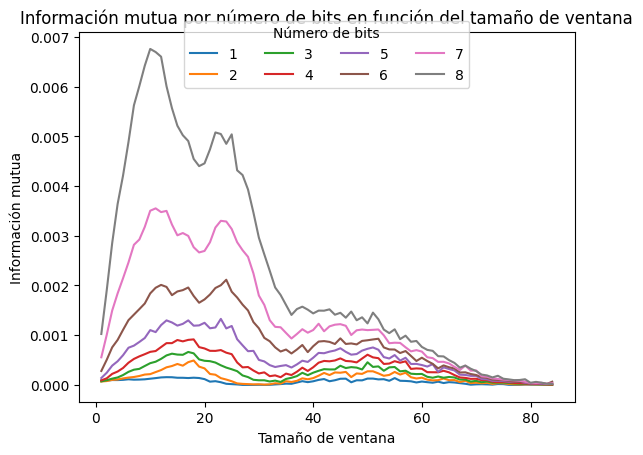

In [57]:
display_MI_togh(list_SAX_binR, lista_entropia_SAX_binR)

In [242]:
#entropy_thog_binR = [entropia_conj(lista_ventanasR[i],list_SAX_binR[i],range(1,9)) for i in range(0,85)]

In [243]:
#with open('entropy_thog_binR', 'wb') as f:
#    pickle.dump(entropy_thog_binR, f)
#with open('entropy_thog_binR', 'rb') as f:
#    entropy_thog_binR = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.06969506926726554 y se alcanza en la ventana 28
La información mútua máxima para LP con 2 bits es 0.08117837097677694 y se alcanza en la ventana 29
La información mútua máxima para LP con 3 bits es 0.09208136022555909 y se alcanza en la ventana 28
La información mútua máxima para LP con 4 bits es 0.09876965185167619 y se alcanza en la ventana 28
La información mútua máxima para LP con 5 bits es 0.10364760804457891 y se alcanza en la ventana 28
La información mútua máxima para LP con 6 bits es 0.10509464859706268 y se alcanza en la ventana 28
La información mútua máxima para LP con 7 bits es 0.1058758924449298 y se alcanza en la ventana 28
La información mútua máxima para LP con 8 bits es 0.10688724478664124 y se alcanza en la ventana 28
La información mútua máxima para VD con 1 bits es 0.12982634281938132 y se alcanza en la ventana 27
La información mútua máxima para VD con 2 bits es 0.14044691226666212 y se alcanza en la ventana 27
L

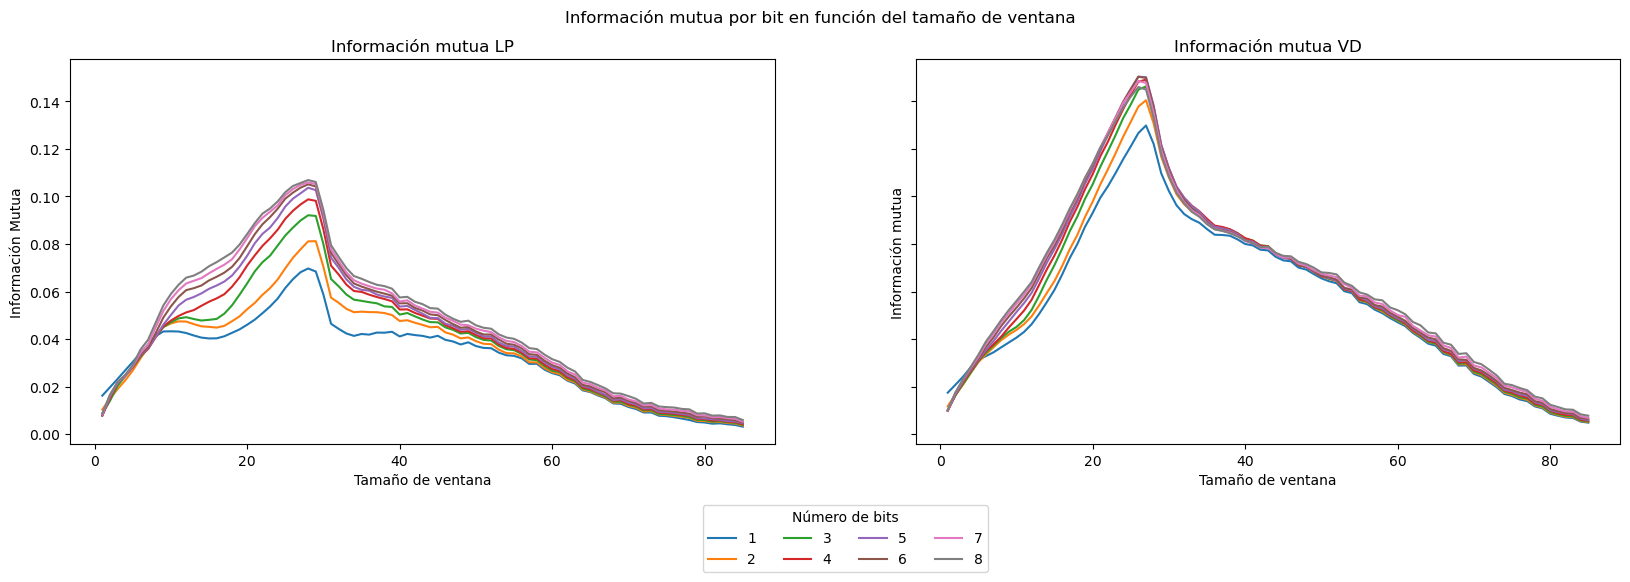

In [249]:
display_heatmap(lista_entropyR[:85], lista_entropia_SAX_binR, entropy_thog_binR)

Mejor LP en 28, mejor VD en 26, nos quedamos con la 27

In [252]:
best_saxR = list_SAX_binR[26]
best_spikesR = lista_ventanasR[26]
best_saxR['LP'].loc[best_saxR['LP'] == 'b'] = 0
best_saxR['LP'].loc[best_saxR['LP'] == 'c'] = 1
best_saxR['VD'].loc[best_saxR['VD'] == 'b'] = 0
best_saxR['VD'].loc[best_saxR['VD'] == 'c'] = 1

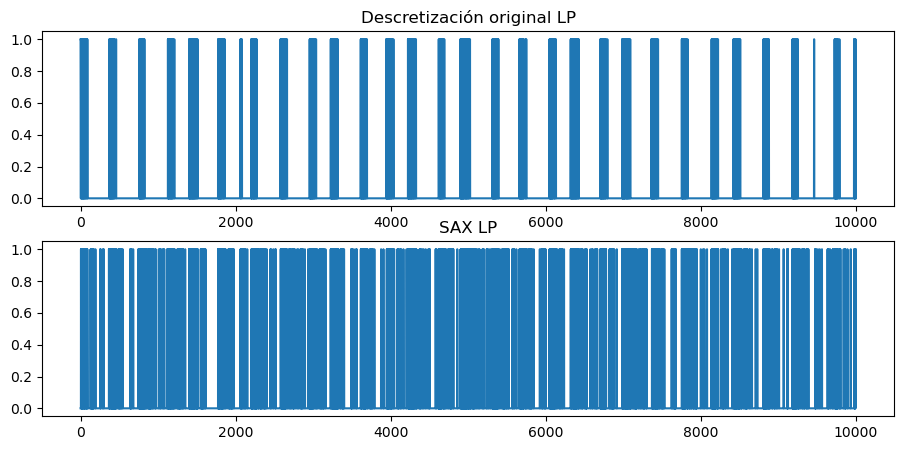

In [253]:
compare_series_LP(best_spikesR, best_saxR)

Tremendamente mal.

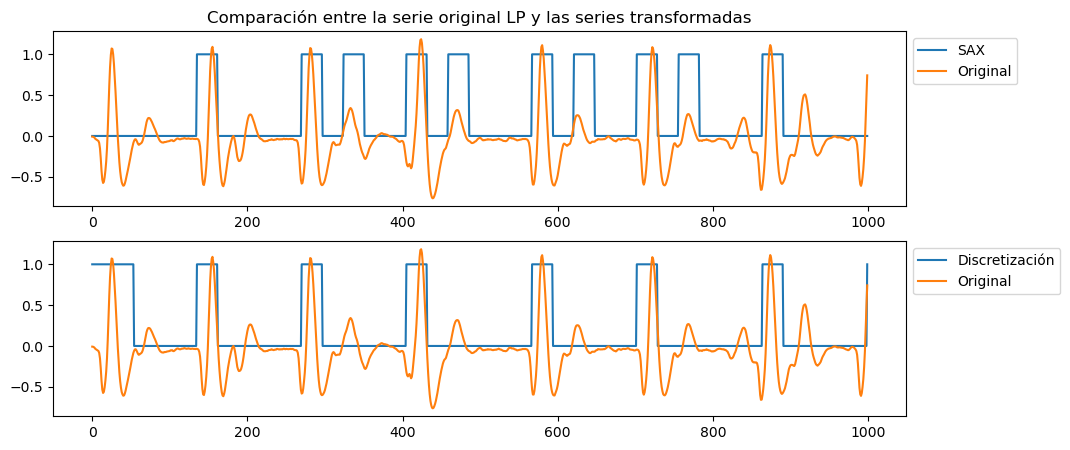

In [254]:
superponerAllLP(best_saxR, trozoR, best_spikesR, ventana = 27, rango = (0,1000));

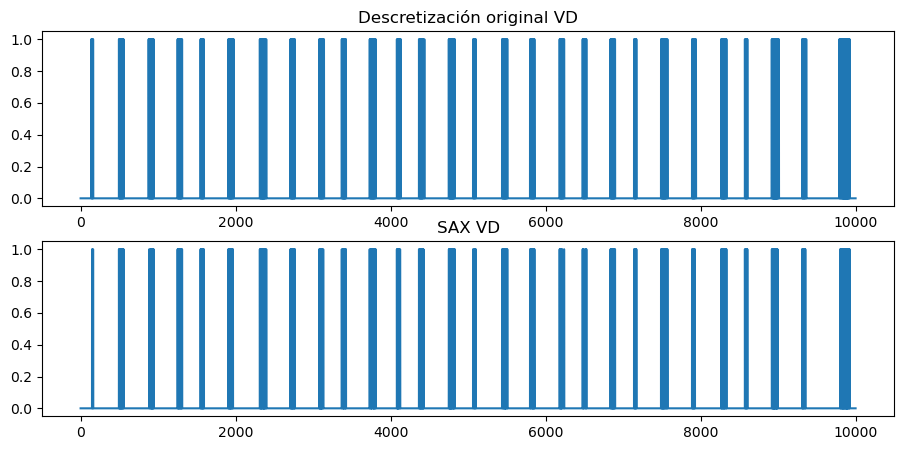

In [255]:
compare_series_VD(best_spikesR, best_saxR)

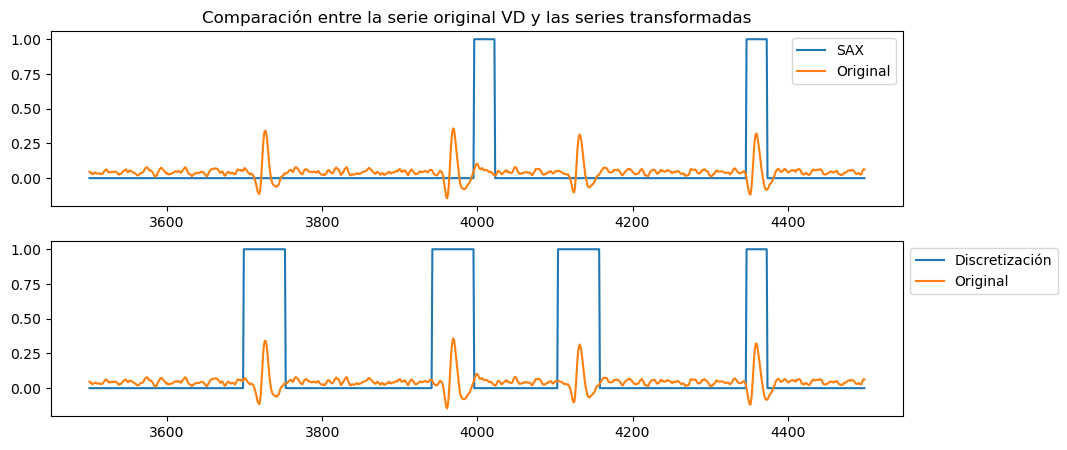

In [262]:
superponerAllVD(best_saxR, trozoR, best_spikesR, ventana = 27, rango=(3500,4500));

## SAX con valor absoluto

In [126]:
PAA_trozoR_abs = trozoR.abs().copy()
PAA_trozoR_abs['LP'] = (PAA_trozoR_abs['LP'] - PAA_trozoR_abs['LP'].mean())/PAA_trozoR_abs['LP'].std()
PAA_trozoR_abs['VD'] = (PAA_trozoR_abs['VD'] - PAA_trozoR_abs['VD'].mean())/PAA_trozoR_abs['VD'].std()

In [127]:
#list_PAAR_abs = [sax(PAA_window(PAA_trozoR_abs, i)) for i in range(1,86)]

In [58]:
#with open('list_PAAR_abs', 'wb') as f:
#   pickle.dump(list_PAAR_abs, f)
with open('list_PAAR_abs', 'rb') as f:
     list_PAAR_abs = pickle.load(f)

In [129]:
#lista_entropia_SAXR_abs= [entropia(frame,range(1,9)) for frame in list_PAAR_abs] 

In [59]:
#with open('lista_entropia_SAXR_abs', 'wb') as f:
#    pickle.dump(lista_entropia_SAXR_abs, f)
with open('lista_entropia_SAXR_abs', 'rb') as f:
    lista_entropia_SAXR_abs = pickle.load(f)

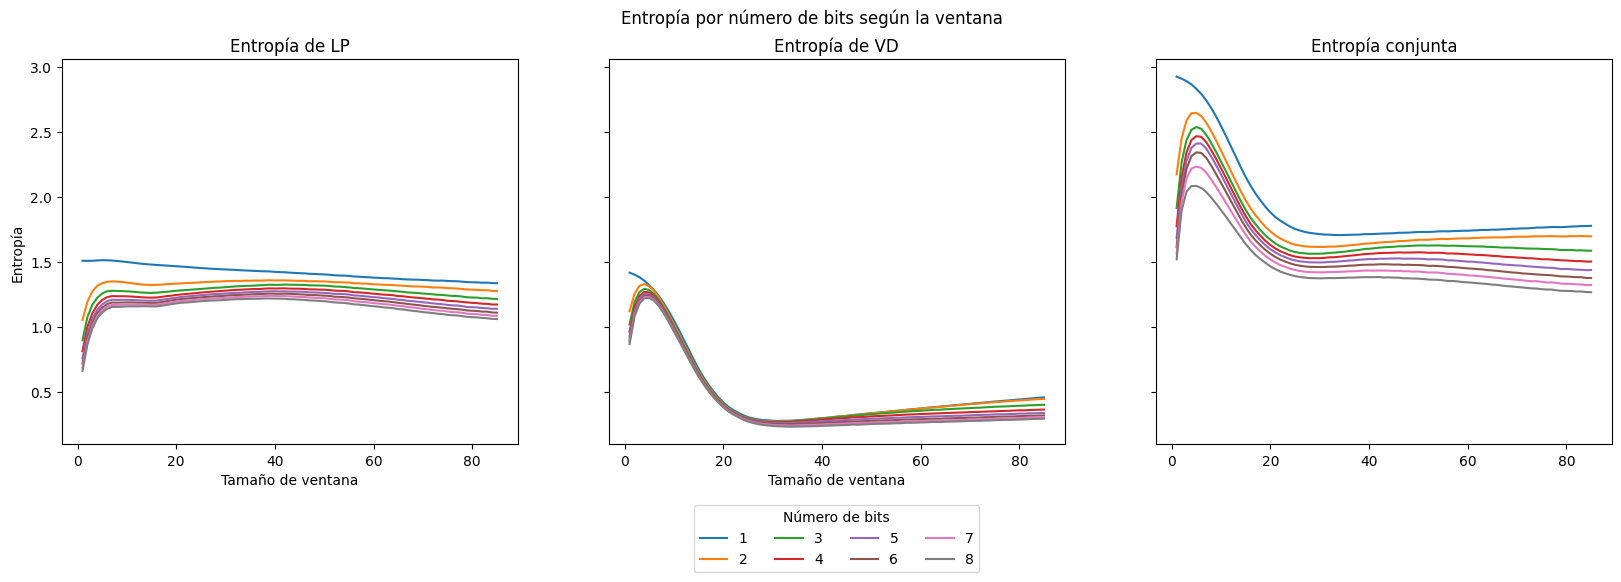

In [131]:
display_Entropy_togh(list_PAAR_abs, lista_entropia_SAXR_abs) 

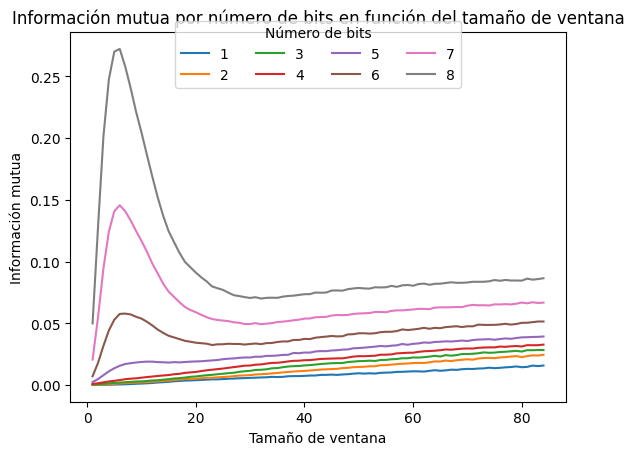

In [60]:
display_MI_togh(list_PAAR_abs, lista_entropia_SAXR_abs)

In [137]:
#entropy_thogR_abs = [entropia_conj(lista_ventanasR[i],list_PAAR_abs[i],range(1,9)) for i in range(0,85) ]

In [138]:
#with open('entropy_thogR_abs', 'wb') as f:
#    pickle.dump(entropy_thogR_abs, f)
with open('entropy_thogR_abs', 'rb') as f:
    entropy_thogR_abs = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.33735742522837975 y se alcanza en la ventana 85
La información mútua máxima para LP con 2 bits es 0.338198038796401 y se alcanza en la ventana 85
La información mútua máxima para LP con 3 bits es 0.31131630211217437 y se alcanza en la ventana 85
La información mútua máxima para LP con 4 bits es 0.29700953732381086 y se alcanza en la ventana 85
La información mútua máxima para LP con 5 bits es 0.2894325948978862 y se alcanza en la ventana 85
La información mútua máxima para LP con 6 bits es 0.28776068551010664 y se alcanza en la ventana 85
La información mútua máxima para LP con 7 bits es 0.2913513406034604 y se alcanza en la ventana 85
La información mútua máxima para LP con 8 bits es 0.29986350864103706 y se alcanza en la ventana 85
La información mútua máxima para VD con 1 bits es 0.42335913519512747 y se alcanza en la ventana 85
La información mútua máxima para VD con 2 bits es 0.4159715820192316 y se alcanza en la ventana 85
La in

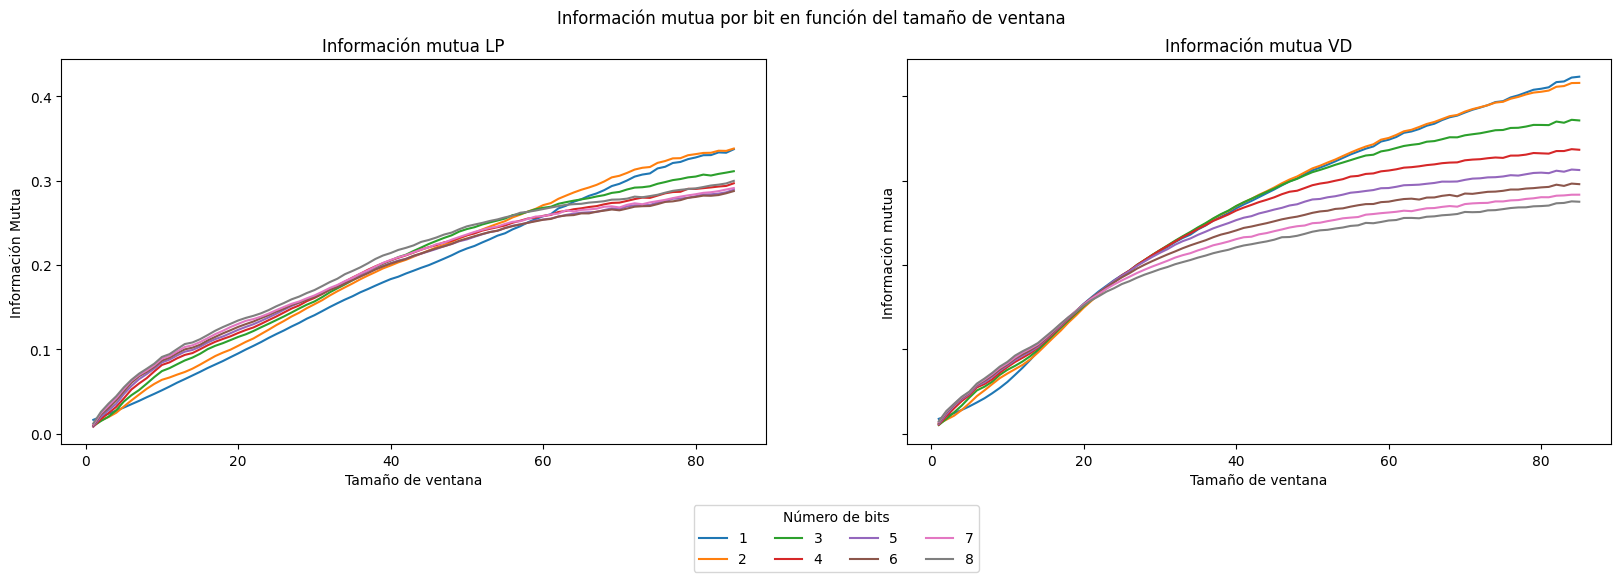

In [139]:
display_heatmap(lista_entropyR[:85], lista_entropia_SAXR_abs, entropy_thogR_abs)

Binarizamos

In [61]:
list_SAX_binR_abs = list_PAAR_abs.copy()
for i in range(len(list_SAX_binR_abs)):
    list_SAX_binR_abs[i]['LP'].loc[list_SAX_binR_abs[i]['LP'] == 'a'] = 'b'
    list_SAX_binR_abs[i]['VD'].loc[list_SAX_binR_abs[i]['VD'] == 'a'] = 'b'

In [141]:
#lista_entropia_SAX_binR_abs = [entropia(frame,range(1,9)) for frame in list_SAX_binR_abs] 

In [62]:
#with open('lista_entropia_SAX_binR_abs', 'wb') as f:
#    pickle.dump(lista_entropia_SAX_binR_abs, f)
with open('lista_entropia_SAX_binR_abs', 'rb') as f:
    lista_entropia_SAX_binR_abs = pickle.load(f)

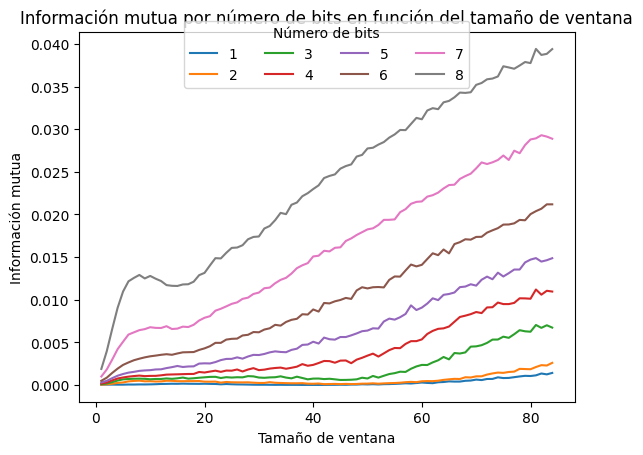

In [63]:
display_MI_togh(list_SAX_binR_abs, lista_entropia_SAX_binR_abs)

In [143]:
#entropy_thog_binR_abs = [entropia_conj(lista_ventanasR[i],list_SAX_binR_abs[i],range(1,9)) for i in range(0,85)]

In [144]:
#with open('entropy_thog_binR_abs', 'wb') as f:
#    pickle.dump(entropy_thog_binR_abs, f)
with open('entropy_thog_binR_abs', 'rb') as f:
    entropy_thog_binR_abs = pickle.load(f)

La información mútua máxima para LP con 1 bits es 0.3333130717499553 y se alcanza en la ventana 85
La información mútua máxima para LP con 2 bits es 0.33454689730436304 y se alcanza en la ventana 85
La información mútua máxima para LP con 3 bits es 0.30562223006091394 y se alcanza en la ventana 85
La información mútua máxima para LP con 4 bits es 0.28774643563976454 y se alcanza en la ventana 85
La información mútua máxima para LP con 5 bits es 0.27545309546908464 y se alcanza en la ventana 85
La información mútua máxima para LP con 6 bits es 0.26932468592181874 y se alcanza en la ventana 85
La información mútua máxima para LP con 7 bits es 0.2667097384902983 y se alcanza en la ventana 85
La información mútua máxima para LP con 8 bits es 0.2690509185634955 y se alcanza en la ventana 85
La información mútua máxima para VD con 1 bits es 0.42335913519512747 y se alcanza en la ventana 85
La información mútua máxima para VD con 2 bits es 0.4159715820192316 y se alcanza en la ventana 85
La i

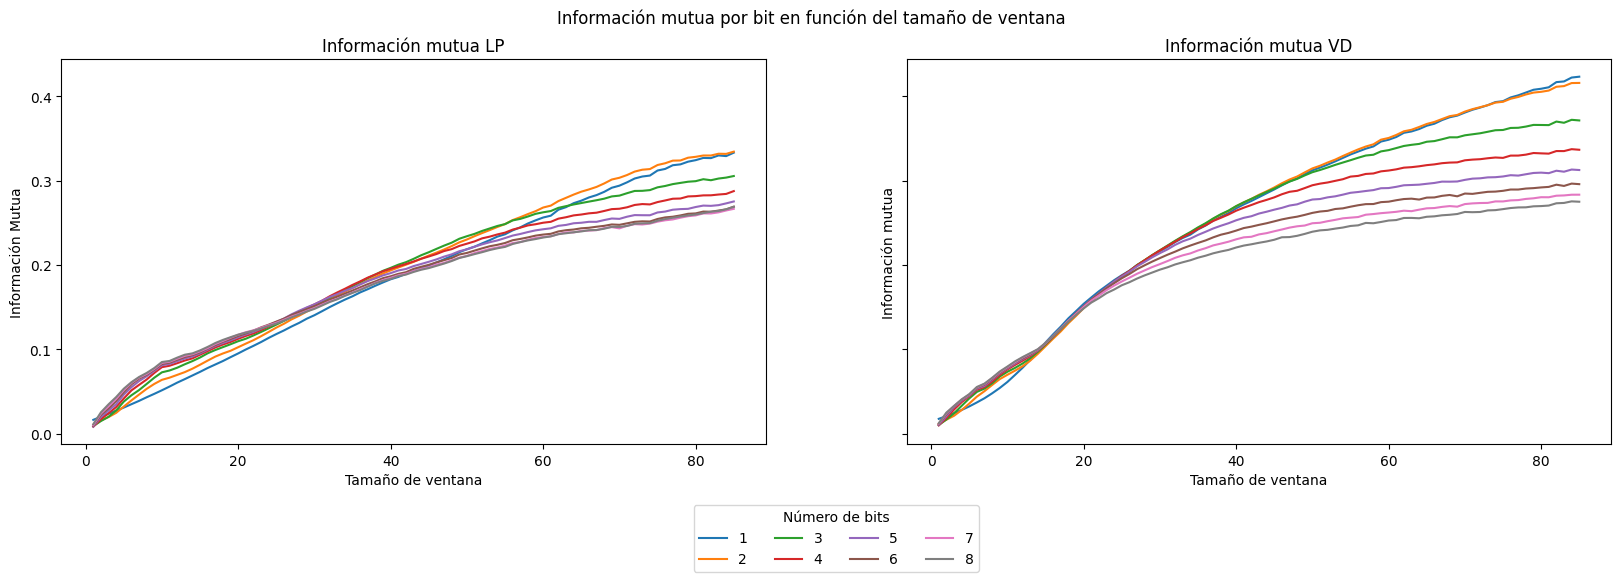

In [145]:
display_heatmap(lista_entropyR[:85], lista_entropia_SAX_binR_abs, entropy_thog_binR_abs)

Nos quedamos con el tamaño 85, que es donde se alcanza el maximo

In [147]:
best_saxR_abs = list_SAX_binR_abs[84]
best_spikesR_abs = lista_ventanasR[84]
best_saxR_abs['LP'].loc[best_saxR_abs['LP'] == 'b'] = 0
best_saxR_abs['LP'].loc[best_saxR_abs['LP'] == 'c'] = 1
best_saxR_abs['VD'].loc[best_saxR_abs['VD'] == 'b'] = 0
best_saxR_abs['VD'].loc[best_saxR_abs['VD'] == 'c'] = 1

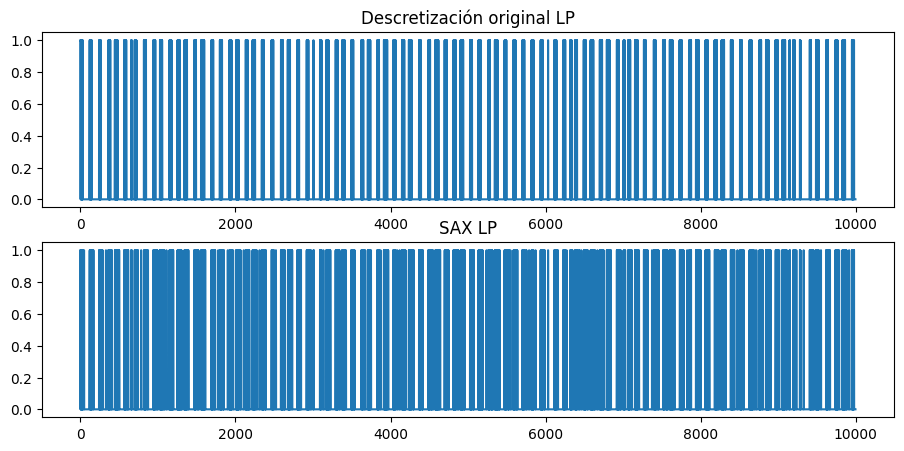

In [148]:
compare_series_LP(best_spikesR_abs, best_saxR_abs)

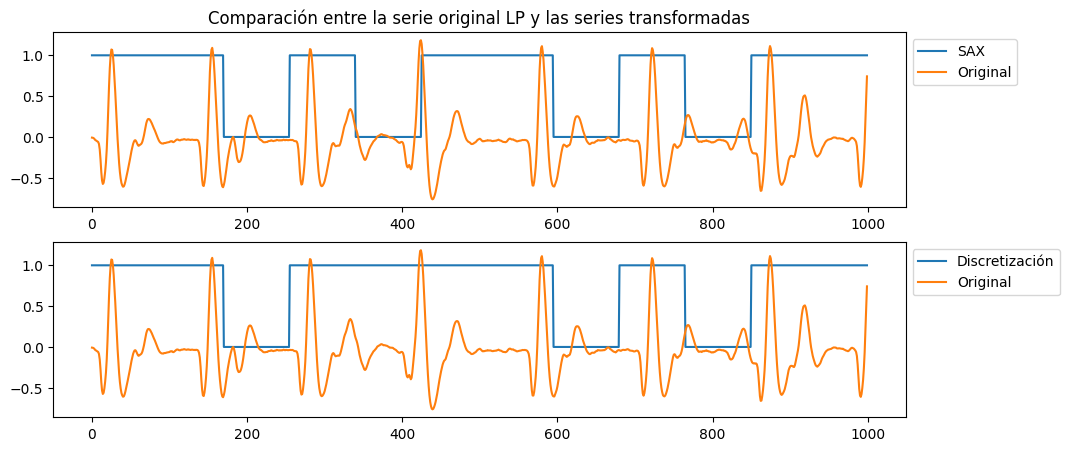

In [152]:
superponerAllLP(best_saxR_abs, trozoR, best_spikesR_abs, ventana = 85, rango = (0,1000));

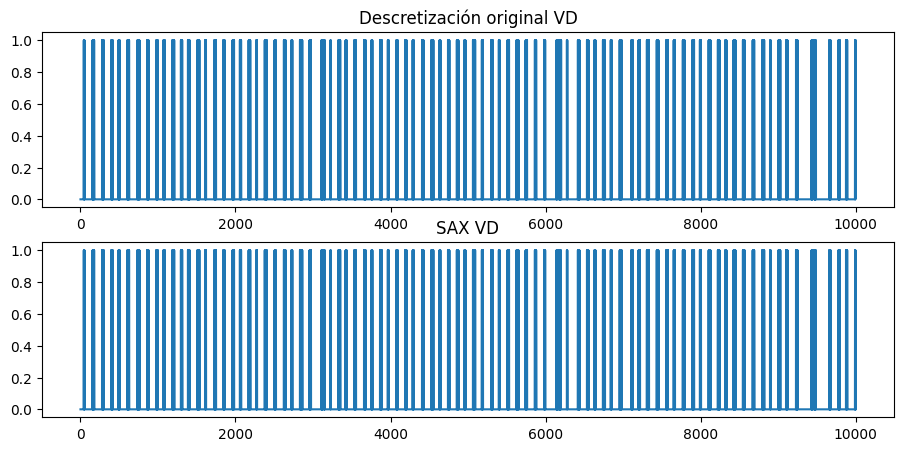

In [150]:
compare_series_VD(best_spikesR_abs, best_saxR_abs)

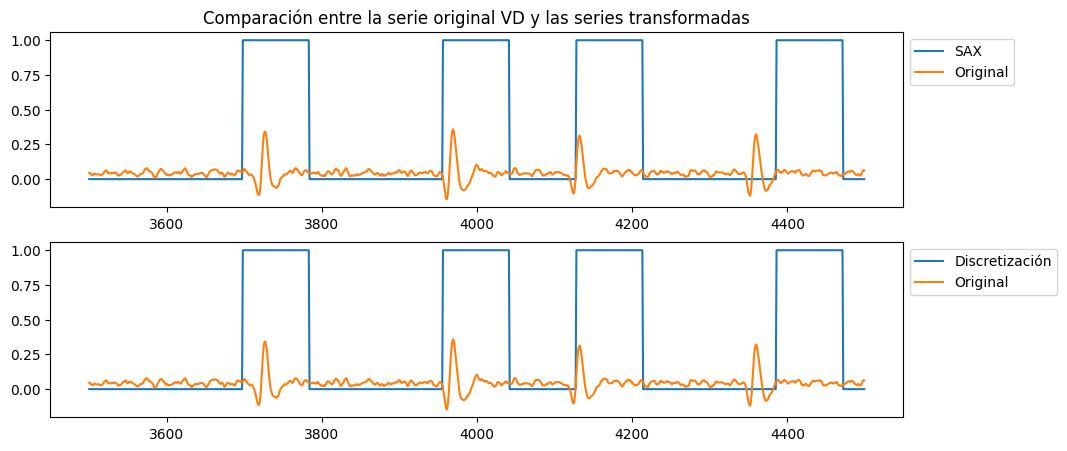

In [154]:
superponerAllVD(best_saxR_abs, trozoR, best_spikesR_abs, ventana = 85, rango=(3500,4500));